In [1]:
import pandas as pd
import numpy as np
from numpy.random import randint, rand
from sklearn.preprocessing import scale

In [2]:
Y = pd.read_csv('WindramTrainingData.csv', index_col=[0]).T.values
mData = pd.read_csv('WindramMetaData.csv', index_col=[0])

In [3]:
Y = scale(Y)

In [4]:
N, D = Y.shape
print('Time Points: %s, Genes: %s'%(N, D))

Time Points: 24, Genes: 100


In [5]:
mData['capture'].values

array([ 6,  6,  6,  6,  6,  6, 18, 18, 18, 18, 18, 18, 30, 30, 30, 30, 30,
       30, 42, 42, 42, 42, 42, 42], dtype=int64)

In [6]:
n_pop = N * 4
np.random.seed(10)
sigma_t = 3.
prior_mean = mData['capture'].values
print(type(prior_mean))
# N = 5
pop = [np.asanyarray([prior_mean[i] + sigma_t * np.random.randn(1) for i in range(0, N)]).reshape(-1) for _ in range(0, n_pop)]
# np.array(prior_mean).shape
# pop

<class 'numpy.ndarray'>


In [76]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
# from sklearn.preprocessing import SplineTransformer
from sklearn.metrics import mean_squared_error
from math import log

def objectiveFunction(x):
    x = x[:,None]
    x_1 = x.reshape((-1, 1))
    x_2 = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x)
    x_3 = PolynomialFeatures(degree=3, include_bias=False).fit_transform(x)
    
#     x_ = SplineTransformer(degree=2, n_knots=3).fit_transform(x)
    
    yhatforAll1 = pd.DataFrame()
    yhatforAll2 = pd.DataFrame()
    yhatforAll3 = pd.DataFrame()
    
    for i in range(0, D):
        y = Y[:,i]
        model1 = LinearRegression().fit(x_1, y)
        model2 = LinearRegression().fit(x_2, y)
        model3 = LinearRegression().fit(x_3, y)
#         num_params = len(model.coef_) + 1
#         print('Number of parameters: %d' % (num_params))
#         print(model.coef_)

        # predict the training set
        yhat1 = model1.predict(x_1)
        yhat2 = model2.predict(x_2)
        yhat3 = model3.predict(x_3)
        
        yhatforAll1 = pd.concat([yhatforAll1,pd.DataFrame(yhat1)], axis = 1)
        yhatforAll2 = pd.concat([yhatforAll2,pd.DataFrame(yhat2)], axis = 1)
        yhatforAll3 = pd.concat([yhatforAll3,pd.DataFrame(yhat3)], axis = 1)
        
        
#     print('MSE: %.3f' % mse)
    del model1, model2, model3, y, yhat1, yhat2, yhat3, x, x_1,x_2,x_3
    
    arr = np.arange(D)
    yhatforAll1 = pd.DataFrame(data=yhatforAll1.values, columns=arr)
    yhatforAll2 = pd.DataFrame(data=yhatforAll2.values, columns=arr)
    yhatforAll3 = pd.DataFrame(data=yhatforAll3.values, columns=arr)
    
    resid1 = sumsqr_new - np.square(yhatforAll1)
    resid2 = resid1 - np.square(yhatforAll2)
    resid3 = resid2 - np.square(yhatforAll3)
    print("yhatforAll1", np.square(yhatforAll1))
    print("sumsqr_new", sumsqr_new)
    print("SHAPE", Y.shape)
    print("RESIDUAL1", resid1)
    bic1 = findBIC(resid1,1,N)
    bic2 = findBIC(resid2,2,N)
    bic3 = findBIC(resid3,3,N)
    
    bic1_a = np.array(bic1)
    bic2_a = np.array(bic2)
    bic3_a = np.array(bic3)

    minBic = np.minimum(bic1_a,bic2_a)
    minBic = np.minimum(bic3_a, minBic)
    
    bicMIN = pd.DataFrame(minBic)
    cost = bicMIN.sum(axis=0)
    minC = np.minimum(cost)
    print ("COST", minC)
    return bicMIN

# tournament selection
def selection(pop, scores, k=3):
    # first random selection
    selection_ix = randint(len(pop))
    for ix in randint(0, len(pop), k-1):
        # check if better (e.g. perform a tournament)
        if scores[ix] < scores[selection_ix]:
            selection_ix = ix
    return pop[selection_ix]

In [46]:
#sumsqr_new, sqrsum_new, sumsqr, sqrsum = sqrsum_sumsqr(D, Y)
#sumsqr_new


In [62]:
def sqrsum_sumsqr(ntest, data):
    data = np.transpose(data)
    data = pd.DataFrame(data)
    #print(data.shape)
    squared = np.square(data)
    sumsqr = squared.sum(axis = 0)
    #print(squared, "_", sumsqr)
    colMeans = np.mean(data, axis = 0)
    sqrsum = np.square(colMeans)
#     print(sqrsum)
#     print(sumsqr)
    #sumsqr_df = pd.DataFrame(sumsqr)
    sqrsum_df = pd.DataFrame(sqrsum)
    
    cellNumber = len(data)
    sqrsum_df *=cellNumber
    #print(sqrsum_df)
    
    ntest = ntest
    #print(ntest)
    
    sumsqr_new = pd.DataFrame()
    sqrsum_new = pd.DataFrame()
    
    for i in range(int(ntest)):
        sumsqr_new = pd.concat([sumsqr_new,sumsqr], axis = 1)
    #print(sumsqr_new)
    
    for i in range(int(ntest)):
        sqrsum_new = pd.concat([sqrsum_new,sqrsum_df], axis = 1)
    #print(sqrsum_new)
    arr = np.arange(D)
    sumsqr_new = pd.DataFrame(data=sumsqr_new.values, columns=arr)
    
    return sumsqr_new, sqrsum_new, sumsqr, sqrsum

In [56]:
import math
def findBIC(res, k, n):   
      w = np.ones(n)
      ll = 0.5 * (np.sum(np.log(w)) - n * (np.log(2 * math.pi) + 1 - np.log(n) + np.log(res)))
      print(ll)
      val = (k+2)*np.log(n)-2*ll
      return(val)

In [15]:
# crossover two parents to create two children
def crossover(p1, p2, r_cross=0.9):
    # children are copies of parents by default
    c1, c2 = p1.copy(), p2.copy()
#     print('Sumon')
#     print(c1.shape)
    # check for recombination
    if rand() < r_cross:
        # select crossover point that is not on the end of the string
        pt = randint(1, len(p1)-2)
        # perform crossover
        c1 = np.concatenate( (p1[:pt], p2[pt:]), axis=None)
        c2 = np.concatenate( (p2[:pt], p1[pt:]), axis=None)
#         print(c1, c2)
    return [c1, c2]

# mutation operator
def mutation(offSpring, r_mut=0.05):
    sigma_mu = 2.
    for i in range(0, len(offSpring)):
        # check for a mutation
        if rand() < r_mut:
            offSpring[i] = offSpring[i] + sigma_mu * np.random.randn(1)

In [78]:
n_iter = 10
best, best_eval = 0, objectiveFunction(pop[0])
# print(best_eval)
for gen in range (0, n_iter):
    scores = [objectiveFunction(c) for c in pop]
    for j in range(0,n_pop):
        if scores[j] < best_eval:
            best, best_eval = pop[j], scores[j]
#     print(">%d, new best f(%s) = %.3f" % (gen,  best, best_eval))
    print(">%d, new best_eval = %.3f" % (gen, best_eval))
    
    # select parents
    selected = [selection(pop, scores) for _ in range(0,n_pop)]
#     print("Selected")
#     print(len(selected))
#     print(selected)
    # create the next generation
    children = list()
    for i in range(0, n_pop, 2):
        # get selected parents in pairs
        p1, p2 = selected[i], selected[i]
        # crossover and mutation
        for c in crossover(p1, p2, r_cross=0.95):
#             # mutation
            mutation(c, r_mut=0.1)
#             # store for next generation
            children.append(c)
#     print(len(children))
#     # replace population
    pop = children
#     return [best, best_eval]
print(best, best_eval)

yhatforAll1           0         1         2         3         4         5         6   \
0   1.896463  2.023711  0.041850  0.856971  2.220833  2.300085  2.429985   
1   1.560987  1.665726  0.034447  0.705377  1.827978  1.893211  2.000132   
2   1.450240  1.547548  0.032003  0.655332  1.698289  1.758893  1.858228   
3   1.056651  1.127550  0.023318  0.477478  1.237381  1.281537  1.353913   
4   0.811617  0.866075  0.017910  0.366753  0.950436  0.984353  1.039946   
5   0.671995  0.717084  0.014829  0.303660  0.786932  0.815015  0.861043   
6   0.072016  0.076848  0.001589  0.032543  0.084334  0.087343  0.092276   
7   0.703587  0.750796  0.015526  0.317936  0.823928  0.853330  0.901523   
8   0.305801  0.326319  0.006748  0.138185  0.358105  0.370884  0.391830   
9   0.174596  0.186310  0.003853  0.078896  0.204458  0.211755  0.223714   
10  0.014803  0.015796  0.000327  0.006689  0.017335  0.017953  0.018967   
11  0.025653  0.027375  0.000566  0.011592  0.030041  0.031113  0.032870   


           0          1          2          3          4          5   \
0  -55.754961 -55.730732 -56.084217 -55.999417 -55.623982 -55.746676   
1  -51.148841 -51.120684 -51.542812 -51.420723 -51.018196 -51.119901   
2  -52.212967 -52.189374 -52.546889 -52.437185 -52.110193 -52.182513   
3  -52.509575 -52.493790 -52.738220 -52.646911 -52.459019 -52.470886   
4  -52.554743 -52.543239 -52.720391 -52.645503 -52.528226 -52.514887   
5  -52.985487 -52.976609 -53.110886 -53.049606 -52.970464 -52.947976   
6  -51.292087 -51.291398 -51.276625 -51.282189 -51.293307 -51.278592   
7  -53.198657 -53.189449 -53.329521 -53.266731 -53.181722 -53.161486   
8  -52.035978 -52.032200 -52.075503 -52.048688 -52.038316 -52.006067   
9  -51.371627 -51.369592 -51.379523 -51.369408 -51.375493 -51.348425   
10 -44.633104 -44.632897 -44.590979 -44.617358 -44.626176 -44.625142   
11 -41.832223 -41.831784 -41.781112 -41.810276 -41.826817 -41.817324   
12 -52.589596 -52.588487 -52.591397 -52.602292 -52.574010 -52.59

yhatforAll1           0         1         2         3         4         5         6   \
0   1.896463  2.023711  0.041850  0.856971  2.220833  2.300085  2.429985   
1   1.560987  1.665726  0.034447  0.705377  1.827978  1.893211  2.000132   
2   1.450240  1.547548  0.032003  0.655332  1.698289  1.758893  1.858228   
3   1.056651  1.127550  0.023318  0.477478  1.237381  1.281537  1.353913   
4   0.811617  0.866075  0.017910  0.366753  0.950436  0.984353  1.039946   
5   0.671995  0.717084  0.014829  0.303660  0.786932  0.815015  0.861043   
6   0.072016  0.076848  0.001589  0.032543  0.084334  0.087343  0.092276   
7   0.703587  0.750796  0.015526  0.317936  0.823928  0.853330  0.901523   
8   0.305801  0.326319  0.006748  0.138185  0.358105  0.370884  0.391830   
9   0.174596  0.186310  0.003853  0.078896  0.204458  0.211755  0.223714   
10  0.014803  0.015796  0.000327  0.006689  0.017335  0.017953  0.018967   
11  0.025653  0.027375  0.000566  0.011592  0.030041  0.031113  0.032870   


           0          1          2          3          4          5   \
0  -55.754961 -55.730732 -56.084217 -55.999417 -55.623982 -55.746676   
1  -51.148841 -51.120684 -51.542812 -51.420723 -51.018196 -51.119901   
2  -52.212967 -52.189374 -52.546889 -52.437185 -52.110193 -52.182513   
3  -52.509575 -52.493790 -52.738220 -52.646911 -52.459019 -52.470886   
4  -52.554743 -52.543239 -52.720391 -52.645503 -52.528226 -52.514887   
5  -52.985487 -52.976609 -53.110886 -53.049606 -52.970464 -52.947976   
6  -51.292087 -51.291398 -51.276625 -51.282189 -51.293307 -51.278592   
7  -53.198657 -53.189449 -53.329521 -53.266731 -53.181722 -53.161486   
8  -52.035978 -52.032200 -52.075503 -52.048688 -52.038316 -52.006067   
9  -51.371627 -51.369592 -51.379523 -51.369408 -51.375493 -51.348425   
10 -44.633104 -44.632897 -44.590979 -44.617358 -44.626176 -44.625142   
11 -41.832223 -41.831784 -41.781112 -41.810276 -41.826817 -41.817324   
12 -52.589596 -52.588487 -52.591397 -52.602292 -52.574010 -52.59

COST 2662.931122580281
yhatforAll1           0         1         2         3         4         5         6   \
0   1.883486  1.929370  0.049527  0.806124  2.087583  2.271155  2.327115   
1   1.544068  1.581683  0.040602  0.660854  1.711385  1.861876  1.907752   
2   1.432183  1.467072  0.037660  0.612968  1.587376  1.726962  1.769513   
3   1.035423  1.060647  0.027227  0.443156  1.147623  1.248539  1.279302   
4   1.156726  1.184905  0.030417  0.495074  1.282070  1.394809  1.429176   
5   0.619071  0.634152  0.016279  0.264960  0.686155  0.746492  0.764885   
6   0.279176  0.285977  0.007341  0.119486  0.309428  0.336638  0.344932   
7   0.681215  0.697810  0.017913  0.291557  0.755033  0.821427  0.841666   
8   0.286137  0.293108  0.007524  0.122466  0.317144  0.345032  0.353533   
9   0.158071  0.161922  0.004157  0.067654  0.175200  0.190606  0.195303   
10  0.023557  0.024131  0.000619  0.010082  0.026110  0.028406  0.029106   
11  0.018422  0.018870  0.000484  0.007884  0.020418 

           0          1          2          3          4          5   \
0  -55.765506 -55.747118 -56.094794 -56.010801 -55.622447 -55.757760   
1  -51.160940 -51.142732 -51.547630 -51.433776 -51.030496 -51.132647   
2  -52.223114 -52.208842 -52.549126 -52.448020 -52.124726 -52.193186   
3  -52.516643 -52.509891 -52.736696 -52.653364 -52.480096 -52.478194   
4  -52.470581 -52.461793 -52.721531 -52.632498 -52.417871 -52.433987   
5  -52.996921 -52.995644 -53.111030 -53.053571 -52.998874 -52.959778   
6  -51.246071 -51.247165 -51.290828 -51.254160 -51.258602 -51.214356   
7  -53.203375 -53.201504 -53.329619 -53.269281 -53.201471 -53.166197   
8  -52.039116 -52.040118 -52.082607 -52.047610 -52.050919 -52.009074   
9  -51.374152 -51.375358 -51.390269 -51.367313 -51.382533 -51.350878   
10 -44.630814 -44.631111 -44.613809 -44.606939 -44.619221 -44.617507   
11 -41.834260 -41.834378 -41.811504 -41.805049 -41.816897 -41.819785   
12 -52.587149 -52.584805 -52.599463 -52.601511 -52.561602 -52.59

COST 2662.918899741579
yhatforAll1           0         1         2         3         4         5         6   \
0   1.791358  1.778640  0.063914  0.716859  1.977110  2.127421  2.152543   
1   1.602400  1.591024  0.057172  0.641243  1.768559  1.903015  1.925487   
2   1.519238  1.508452  0.054205  0.607963  1.676774  1.804252  1.825557   
3   1.193589  1.185115  0.042586  0.477646  1.317357  1.417509  1.434248   
4   1.272309  1.263276  0.045395  0.509148  1.404239  1.510997  1.528840   
5   0.491951  0.488459  0.017552  0.196867  0.542964  0.584243  0.591142   
6   0.428998  0.425953  0.015306  0.171675  0.473483  0.509480  0.515496   
7   0.630884  0.626405  0.022509  0.252465  0.696303  0.749239  0.758087   
8   0.255417  0.253603  0.009113  0.102212  0.281902  0.303333  0.306915   
9   0.108848  0.108075  0.003884  0.043558  0.120134  0.129268  0.130794   
10  0.004817  0.004783  0.000172  0.001928  0.005316  0.005721  0.005788   
11  0.005066  0.005030  0.000181  0.002027  0.005591 

           0          1          2          3          4          5   \
0  -55.787426 -55.792372 -56.095641 -56.015534 -55.680278 -55.781808   
1  -51.147414 -51.153216 -51.545423 -51.435193 -51.026420 -51.128422   
2  -52.202905 -52.207657 -52.546611 -52.448267 -52.105902 -52.181681   
3  -52.478929 -52.481639 -52.734318 -52.650424 -52.429824 -52.446582   
4  -52.443298 -52.446452 -52.718827 -52.631501 -52.384010 -52.413197   
5  -53.024696 -53.024614 -53.110567 -53.065024 -53.031805 -52.989753   
6  -51.210015 -51.209770 -51.294363 -51.246085 -51.220210 -51.171039   
7  -53.214647 -53.214920 -53.328795 -53.275895 -53.215960 -53.178383   
8  -52.045589 -52.045129 -52.085928 -52.054232 -52.056049 -52.016177   
9  -51.384354 -51.383927 -51.395746 -51.376737 -51.389554 -51.364269   
10 -44.634975 -44.635095 -44.626542 -44.619600 -44.618338 -44.628655   
11 -41.837767 -41.837909 -41.827110 -41.818190 -41.816986 -41.829568   
12 -52.584560 -52.585311 -52.602927 -52.601508 -52.562724 -52.59

yhatforAll1           0         1         2         3         4         5         6   \
0   1.717291  1.646864  0.055890  0.692209  1.812657  2.007697  2.030858   
1   1.534847  1.471902  0.049952  0.618669  1.620081  1.794400  1.815100   
2   1.454577  1.394924  0.047340  0.586314  1.535353  1.700557  1.720174   
3   1.221104  1.171026  0.039741  0.492205  1.288915  1.427602  1.444070   
4   1.174547  1.126378  0.038226  0.473439  1.239772  1.373171  1.389012   
5   0.465308  0.446225  0.015144  0.187557  0.491147  0.543994  0.550270   
6   0.404949  0.388342  0.013179  0.163228  0.427437  0.473429  0.478890   
7   0.928891  0.890797  0.030231  0.374419  0.980475  1.085973  1.098501   
8   0.495453  0.475134  0.016125  0.199708  0.522967  0.579238  0.585919   
9   0.099691  0.095602  0.003244  0.040183  0.105227  0.116549  0.117893   
10  0.003455  0.003313  0.000112  0.001393  0.003647  0.004039  0.004086   
11  0.003663  0.003513  0.000119  0.001477  0.003867  0.004283  0.004332   


           0          1          2          3          4          5   \
0  -55.780536 -55.814101 -56.095982 -56.017424 -55.702695 -55.789740   
1  -51.144227 -51.182427 -51.546806 -51.437763 -51.059610 -51.141642   
2  -52.202490 -52.233279 -52.548085 -52.450546 -52.136069 -52.194315   
3  -52.463643 -52.482943 -52.735910 -52.648982 -52.426251 -52.441605   
4  -52.460855 -52.478203 -52.720220 -52.635224 -52.428268 -52.436477   
5  -53.036676 -53.034103 -53.107723 -53.066018 -53.045637 -53.001590   
6  -51.223379 -51.219633 -51.290399 -51.247130 -51.234304 -51.184184   
7  -53.148336 -53.156098 -53.330016 -53.260766 -53.137812 -53.116310   
8  -51.998270 -51.995894 -52.083163 -52.035355 -52.007581 -51.959444   
9  -51.389912 -51.387081 -51.388682 -51.377064 -51.390630 -51.371421   
10 -44.631658 -44.635088 -44.614436 -44.619454 -44.607907 -44.632247   
11 -41.833681 -41.837932 -41.811799 -41.818010 -41.803885 -41.834174   
12 -52.577399 -52.584358 -52.599816 -52.601322 -52.555338 -52.58

COST 2662.921531027492
yhatforAll1           0         1         2         3         4         5         6   \
0   1.899282  1.955447  0.047836  0.801131  2.130629  2.294232  2.336599   
1   1.556597  1.602627  0.039205  0.656583  1.746202  1.880287  1.915009   
2   1.505661  1.550186  0.037922  0.635099  1.689063  1.818759  1.852346   
3   1.043164  1.074012  0.026274  0.440014  1.170230  1.260087  1.283357   
4   1.165594  1.200062  0.029357  0.491656  1.307572  1.407976  1.433976   
5   0.653895  0.673232  0.016469  0.275818  0.733545  0.789871  0.804457   
6   0.280355  0.288645  0.007061  0.118256  0.314504  0.338654  0.344908   
7   0.612954  0.631080  0.015438  0.258548  0.687617  0.740416  0.754089   
8   0.287369  0.295867  0.007238  0.121214  0.322373  0.347127  0.353537   
9   0.158387  0.163071  0.003989  0.066809  0.177680  0.191323  0.194856   
10  0.009092  0.009360  0.000229  0.003835  0.010199  0.010982  0.011185   
11  0.018141  0.018677  0.000457  0.007652  0.020350 

           0          1          2          3          4          5   \
0  -55.765982 -55.754907 -56.094985 -56.007060 -55.630865 -55.757005   
1  -51.160696 -51.148044 -51.547816 -51.430096 -51.035320 -51.130723   
2  -52.206461 -52.195340 -52.549016 -52.442602 -52.100508 -52.177117   
3  -52.515650 -52.508806 -52.736750 -52.652759 -52.478032 -52.475843   
4  -52.469713 -52.461820 -52.721610 -52.631227 -52.416900 -52.431721   
5  -52.989038 -52.985370 -53.111326 -53.053284 -52.986699 -52.950339   
6  -51.245187 -51.243739 -51.290813 -51.257459 -51.256153 -51.212425   
7  -53.218096 -53.214778 -53.328913 -53.274712 -53.218154 -53.180646   
8  -52.038276 -52.036876 -52.082592 -52.050679 -52.048562 -52.007247   
9  -51.373562 -51.372887 -51.390280 -51.370771 -51.381596 -51.349428   
10 -44.634286 -44.634227 -44.615195 -44.617928 -44.619931 -44.625944   
11 -41.834194 -41.834106 -41.811717 -41.811224 -41.821392 -41.818617   
12 -52.587366 -52.586669 -52.599632 -52.601799 -52.564940 -52.59

yhatforAll1           0         1         2         3         4         5         6   \
0   1.893796  1.930110  0.044762  0.769002  2.130652  2.268332  2.336305   
1   1.551048  1.580790  0.036660  0.629824  1.745037  1.857799  1.913470   
2   1.500114  1.528879  0.035457  0.609142  1.687732  1.796791  1.850635   
3   1.037797  1.057697  0.024529  0.421412  1.167594  1.243042  1.280291   
4   1.160145  1.182391  0.027421  0.471093  1.305243  1.389586  1.431227   
5   0.649033  0.661478  0.015340  0.263549  0.730207  0.777392  0.800688   
6   0.276648  0.281953  0.006539  0.112337  0.311248  0.331360  0.341290   
7   0.773067  0.787890  0.018272  0.313914  0.869754  0.925956  0.953703   
8   0.209973  0.213999  0.004963  0.085262  0.236234  0.251499  0.259036   
9   0.155418  0.158398  0.003673  0.063110  0.174856  0.186155  0.191734   
10  0.008292  0.008451  0.000196  0.003367  0.009329  0.009932  0.010229   
11  0.017022  0.017348  0.000402  0.006912  0.019151  0.020388  0.020999   


           0          1          2          3          4          5   \
0  -55.764480 -55.752006 -56.095025 -56.012776 -55.633103 -55.764163   
1  -51.160211 -51.147633 -51.548051 -51.436834 -51.038208 -51.138533   
2  -52.206221 -52.195412 -52.549245 -52.448562 -52.103093 -52.183921   
3  -52.516838 -52.511886 -52.736972 -52.656431 -52.479982 -52.479579   
4  -52.470599 -52.464289 -52.721854 -52.635499 -52.419017 -52.436198   
5  -52.990728 -52.989295 -53.111388 -53.054997 -52.988032 -52.951960   
6  -51.246885 -51.247348 -51.290613 -51.257519 -51.256942 -51.212671   
7  -53.183503 -53.181179 -53.330552 -53.267687 -53.172574 -53.145170   
8  -52.055686 -52.056253 -52.081674 -52.057298 -52.064228 -52.027604   
9  -51.374845 -51.375478 -51.389991 -51.370310 -51.382057 -51.349330   
10 -44.634403 -44.634169 -44.614605 -44.616555 -44.619602 -44.625550   
11 -41.834712 -41.834770 -41.810956 -41.809444 -41.821148 -41.818080   
12 -52.586265 -52.584767 -52.599498 -52.601705 -52.564232 -52.59

yhatforAll1           0         1         2         3         4         5         6   \
0   1.840666  1.877633  0.063698  0.803365  2.078265  2.245878  2.268205   
1   1.507168  1.537437  0.052157  0.657808  1.701718  1.838963  1.857245   
2   1.564801  1.596228  0.054151  0.682963  1.766791  1.909284  1.928264   
3   1.216979  1.241421  0.042114  0.531155  1.374071  1.484891  1.499653   
4   1.096279  1.118296  0.037938  0.478475  1.237791  1.337619  1.350917   
5   0.629793  0.642441  0.021794  0.274875  0.711089  0.768438  0.776078   
6   0.357575  0.364756  0.012374  0.156065  0.403732  0.436293  0.440630   
7   0.447744  0.456736  0.015495  0.195419  0.505540  0.546313  0.551744   
8   0.274664  0.280180  0.009505  0.119878  0.310118  0.335130  0.338461   
9   0.150190  0.153206  0.005197  0.065551  0.169577  0.183254  0.185075   
10  0.029341  0.029930  0.001015  0.012806  0.033128  0.035800  0.036156   
11  0.008109  0.008271  0.000281  0.003539  0.009155  0.009894  0.009992   


           0          1          2          3          4          5   \
0  -55.781217 -55.773136 -56.095726 -56.000079 -55.644552 -55.762411   
1  -51.177624 -51.168665 -51.545842 -51.423144 -51.051860 -51.138153   
2  -52.193774 -52.185097 -52.546875 -52.431143 -52.067264 -52.159098   
3  -52.473863 -52.467913 -52.734707 -52.639034 -52.409127 -52.432660   
4  -52.487304 -52.482176 -52.719002 -52.630154 -52.439557 -52.444815   
5  -52.993535 -52.991319 -53.111242 -53.054657 -52.992670 -52.954694   
6  -51.225681 -51.224594 -51.294861 -51.252725 -51.237302 -51.189585   
7  -53.252073 -53.250770 -53.328969 -53.286452 -53.259816 -53.218409   
8  -52.039986 -52.039326 -52.086372 -52.054437 -52.051273 -52.010348   
9  -51.374458 -51.374233 -51.395857 -51.375027 -51.382964 -51.351838   
10 -44.628478 -44.628519 -44.625201 -44.615163 -44.622099 -44.612932   
11 -41.837180 -41.837149 -41.827313 -41.822731 -41.817234 -41.827592   
12 -52.587743 -52.587102 -52.602865 -52.601727 -52.563557 -52.59

COST 2662.9162090692857
yhatforAll1           0         1         2         3         4         5         6   \
0   1.876692  1.894008  0.068309  0.840591  2.107047  2.269674  2.286163   
1   1.537364  1.551549  0.055958  0.688603  1.726068  1.859290  1.872798   
2   1.596010  1.610737  0.058093  0.714871  1.791913  1.930217  1.944240   
3   1.242029  1.253490  0.045208  0.556319  1.394482  1.502112  1.513025   
4   1.119163  1.129490  0.040736  0.501286  1.256535  1.353517  1.363350   
5   0.644087  0.650030  0.023444  0.288494  0.723146  0.778960  0.784619   
6   0.366572  0.369955  0.013343  0.164192  0.411567  0.443333  0.446554   
7   0.458534  0.462765  0.016690  0.205383  0.514817  0.554552  0.558580   
8   0.281963  0.284564  0.010263  0.126294  0.316572  0.341006  0.343484   
9   0.049883  0.050343  0.001816  0.022343  0.056005  0.060328  0.060766   
10  0.030815  0.031100  0.001122  0.013802  0.034598  0.037268  0.037539   
11  0.008777  0.008858  0.000319  0.003931  0.009854

           0          1          2          3          4          5   \
0  -55.779283 -55.777831 -56.095210 -56.002402 -55.649989 -55.763845   
1  -51.173727 -51.171466 -51.545928 -51.423543 -51.054359 -51.137792   
2  -52.190332 -52.188265 -52.546883 -52.431992 -52.070328 -52.159130   
3  -52.469884 -52.467872 -52.734768 -52.637034 -52.408252 -52.430746   
4  -52.483232 -52.481267 -52.718885 -52.627206 -52.437725 -52.442352   
5  -52.989925 -52.988421 -53.109707 -53.048822 -52.989288 -52.951048   
6  -51.222410 -51.221161 -51.291715 -51.244947 -51.234180 -51.185416   
7  -53.248991 -53.247777 -53.326699 -53.280045 -53.256801 -53.214785   
8  -52.037334 -52.036352 -52.083053 -52.047175 -52.048920 -52.006675   
9  -51.395001 -51.394718 -51.393012 -51.382975 -51.395942 -51.382083   
10 -44.627420 -44.627089 -44.618280 -44.606077 -44.624075 -44.609849   
11 -41.836855 -41.836752 -41.819181 -41.813436 -41.821458 -41.825031   
12 -52.588696 -52.588832 -52.601451 -52.601554 -52.567080 -52.59

yhatforAll1           0         1         2         3         4         5         6   \
0   1.889710  1.968218  0.062617  0.739462  2.147973  2.249841  2.392193   
1   1.511433  1.574226  0.050083  0.591438  1.717998  1.799474  1.913331   
2   1.466364  1.527283  0.048589  0.573802  1.666769  1.745815  1.856277   
3   1.150342  1.198133  0.038118  0.450140  1.307557  1.369568  1.456224   
4   1.099767  1.145456  0.036442  0.430349  1.250070  1.309354  1.392200   
5   0.386192  0.402237  0.012797  0.151121  0.438973  0.459791  0.488883   
6   0.395130  0.411546  0.013093  0.154618  0.449132  0.470432  0.500198   
7   0.605051  0.630188  0.020049  0.236762  0.687742  0.720358  0.765937   
8   0.236672  0.246505  0.007842  0.092612  0.269018  0.281776  0.299605   
9   0.133825  0.139385  0.004434  0.052367  0.152115  0.159329  0.169410   
10  0.024149  0.025152  0.000800  0.009450  0.027449  0.028751  0.030570   
11  0.080527  0.083873  0.002668  0.031511  0.091533  0.095874  0.101940   


           0          1          2          3          4          5   \
0  -55.775865 -55.741326 -56.095810 -56.020454 -55.623837 -55.768759   
1  -51.179591 -51.147441 -51.546412 -51.447239 -51.045629 -51.152526   
2  -52.221643 -52.194006 -52.547492 -52.457655 -52.107520 -52.195357   
3  -52.490859 -52.475243 -52.735178 -52.657284 -52.431531 -52.457297   
4  -52.486979 -52.472983 -52.719531 -52.643424 -52.434828 -52.452543   
5  -53.044272 -53.045893 -53.110874 -53.071267 -53.053605 -53.014409   
6  -51.215110 -51.216894 -51.294812 -51.248066 -51.225717 -51.180017   
7  -53.217886 -53.216496 -53.329364 -53.278194 -53.217415 -53.184120   
8  -52.046987 -52.049766 -52.086185 -52.054273 -52.058247 -52.020768   
9  -51.376979 -51.379735 -51.395549 -51.371549 -51.385297 -51.356155   
10 -44.629549 -44.630817 -44.624530 -44.607060 -44.622858 -44.614707   
11 -41.805625 -41.810435 -41.822214 -41.782261 -41.814933 -41.770242   
12 -52.563341 -52.557639 -52.603649 -52.596064 -52.536601 -52.56

yhatforAll1           0         1         2         3         4         5         6   \
0   1.734406  1.749921  0.045927  0.691858  1.922900  2.066598  2.121876   
1   1.513178  1.526715  0.040069  0.603610  1.677629  1.802998  1.851226   
2   1.467698  1.480828  0.038865  0.585468  1.627206  1.748807  1.795586   
3   1.148976  1.159255  0.030425  0.458329  1.273846  1.369040  1.405660   
4   1.098002  1.107824  0.029075  0.437995  1.217332  1.308303  1.343298   
5   0.620915  0.626469  0.016442  0.247684  0.688395  0.739839  0.759629   
6   0.389558  0.393043  0.010315  0.155396  0.431895  0.464171  0.476587   
7   0.600135  0.605503  0.015892  0.239395  0.665357  0.715079  0.734206   
8   0.322390  0.325274  0.008537  0.128602  0.357427  0.384138  0.394413   
9   0.167885  0.169387  0.004446  0.066970  0.186131  0.200040  0.205391   
10  0.015812  0.015953  0.000419  0.006307  0.017530  0.018841  0.019344   
11  0.076378  0.077061  0.002022  0.030467  0.084679  0.091007  0.093441   


           0          1          2          3          4          5   \
0  -55.783014 -55.777524 -56.096779 -56.018325 -55.664004 -55.775977   
1  -51.157016 -51.150844 -51.547962 -51.440824 -51.031688 -51.134662   
2  -52.202883 -52.197562 -52.549013 -52.452095 -52.096687 -52.180433   
3  -52.484179 -52.481064 -52.736881 -52.654226 -52.431756 -52.451820   
4  -52.481891 -52.479072 -52.721198 -52.640759 -52.436379 -52.448375   
5  -52.998769 -52.998189 -53.111828 -53.059237 -52.999379 -52.964091   
6  -51.223439 -51.223480 -51.294004 -51.250946 -51.233703 -51.188995   
7  -53.223437 -53.222935 -53.329666 -53.279296 -53.225148 -53.189651   
8  -52.034566 -52.034726 -52.085026 -52.050255 -52.044589 -52.005070   
9  -51.374904 -51.375193 -51.393137 -51.371322 -51.381428 -51.353186   
10 -44.632729 -44.632563 -44.619660 -44.615274 -44.613433 -44.626110   
11 -41.814973 -41.815368 -41.816079 -41.790972 -41.813011 -41.786027   
12 -52.555061 -52.553941 -52.603151 -52.594652 -52.526959 -52.55

yhatforAll1           0         1         2         3         4         5         6   \
0   1.783453  1.768210  0.064098  0.812079  1.939027  2.148262  2.178313   
1   1.460192  1.447712  0.052480  0.664885  1.587567  1.758877  1.783481   
2   1.516055  1.503097  0.054487  0.690322  1.648303  1.826167  1.851712   
3   1.178925  1.168848  0.042371  0.536812  1.281764  1.420076  1.439940   
4   1.061940  1.052863  0.038166  0.483544  1.154575  1.279161  1.297055   
5   0.609853  0.604640  0.021918  0.277691  0.663051  0.734599  0.744875   
6   0.346091  0.343132  0.012439  0.157589  0.376281  0.416884  0.422716   
7   0.639811  0.634342  0.022995  0.291332  0.695622  0.770685  0.781466   
8   0.265771  0.263499  0.009552  0.121016  0.288954  0.320135  0.324613   
9   0.145216  0.143974  0.005219  0.066123  0.157883  0.174920  0.177367   
10  0.061442  0.060917  0.002208  0.027977  0.066802  0.074010  0.075045   
11  0.007764  0.007697  0.000279  0.003535  0.008441  0.009352  0.009483   


           0          1          2          3          4          5   \
0  -55.782758 -55.766683 -56.095720 -56.007439 -55.640780 -55.766131   
1  -51.182330 -51.170069 -51.546003 -51.429884 -51.058273 -51.146905   
2  -52.197769 -52.184860 -52.547008 -52.437996 -52.071560 -52.166681   
3  -52.479323 -52.475376 -52.734852 -52.641830 -52.420772 -52.442300   
4  -52.493070 -52.491533 -52.719111 -52.631581 -52.452674 -52.454939   
5  -52.998995 -53.003291 -53.111036 -53.051253 -53.005330 -52.964585   
6  -51.230649 -51.236275 -51.294284 -51.246350 -51.246845 -51.199251   
7  -53.212437 -53.216450 -53.329115 -53.268560 -53.216870 -53.178140   
8  -52.043987 -52.048825 -52.085725 -52.048049 -52.057852 -52.018459   
9  -51.377315 -51.380950 -51.395005 -51.368073 -51.385108 -51.358351   
10 -44.619494 -44.622404 -44.622261 -44.594224 -44.615302 -44.600210   
11 -41.837112 -41.835155 -41.825202 -41.811882 -41.802048 -41.831634   
12 -52.586231 -52.582144 -52.602343 -52.601369 -52.554516 -52.59

yhatforAll1           0         1         2         3         4         5         6   \
0   1.851202  1.843275  0.075360  0.823209  2.092266  2.205595  2.220573   
1   1.513788  1.507306  0.061624  0.673164  1.710913  1.803587  1.815834   
2   1.572082  1.565350  0.063997  0.699087  1.776798  1.873040  1.885759   
3   1.220403  1.215177  0.049681  0.542699  1.379323  1.454036  1.463910   
4   1.098448  1.093745  0.044716  0.488467  1.241488  1.308735  1.317622   
5   0.627746  0.625058  0.025555  0.279151  0.709491  0.747921  0.753000   
6   0.353893  0.352378  0.014406  0.157372  0.399977  0.421643  0.424506   
7   0.658898  0.656076  0.026823  0.293004  0.744699  0.785037  0.790367   
8   0.270732  0.269573  0.011021  0.120392  0.305987  0.322561  0.324751   
9   0.146326  0.145700  0.005957  0.065070  0.165381  0.174339  0.175523   
10  0.060528  0.060269  0.002464  0.026916  0.068410  0.072116  0.072606   
11  0.006773  0.006744  0.000276  0.003012  0.007655  0.008070  0.008125   


           0          1          2          3          4          5   \
0  -55.778620 -55.775663 -56.093437 -56.011548 -55.648308 -55.770327   
1  -51.175688 -51.173792 -51.545458 -51.433006 -51.056297 -51.147414   
2  -52.191716 -52.189621 -52.546241 -52.441355 -52.071504 -52.167973   
3  -52.473371 -52.473176 -52.734625 -52.642114 -52.412332 -52.439214   
4  -52.487261 -52.487573 -52.718507 -52.630776 -52.442458 -52.450660   
5  -52.994711 -52.996165 -53.106843 -53.046641 -52.994415 -52.957867   
6  -51.227332 -51.229035 -51.285746 -51.239207 -51.238622 -51.191778   
7  -53.208104 -53.209496 -53.325319 -53.264252 -53.205940 -53.171607   
8  -52.041491 -52.042943 -52.076706 -52.041139 -52.052284 -52.011993   
9  -51.375796 -51.376913 -51.384120 -51.360912 -51.383611 -51.352941   
10 -44.618479 -44.619522 -44.602599 -44.583095 -44.619924 -44.593720   
11 -41.837525 -41.837400 -41.802694 -41.801544 -41.816548 -41.828018   
12 -52.538824 -52.538308 -52.603118 -52.585425 -52.514383 -52.53

yhatforAll1           0         1         2         3         4         5         6   \
0   1.738047  1.698453  0.076441  0.743185  1.846962  2.097037  2.010210   
1   1.517122  1.482561  0.066725  0.648718  1.612193  1.830481  1.754690   
2   1.315447  1.285480  0.057855  0.562482  1.397880  1.587150  1.521434   
3   0.948195  0.926594  0.041703  0.405446  1.007614  1.144043  1.096674   
4   1.285613  1.256326  0.056543  0.549725  1.366176  1.551154  1.486929   
5   0.627364  0.613072  0.027592  0.268259  0.666678  0.756945  0.725604   
6   0.992747  0.970132  0.043662  0.424497  1.054958  1.197797  1.148203   
7   0.352186  0.344163  0.015490  0.150594  0.374256  0.424930  0.407335   
8   0.257280  0.251419  0.011315  0.110012  0.273402  0.310420  0.297568   
9   0.276965  0.270656  0.012181  0.118430  0.294321  0.334172  0.320335   
10  0.003233  0.003159  0.000142  0.001382  0.003436  0.003901  0.003739   
11  0.003433  0.003354  0.000151  0.001468  0.003648  0.004142  0.003970   


           0          1          2          3          4          5   \
0  -55.785646 -55.794626 -56.093752 -56.023758 -55.682207 -55.764481   
1  -51.159299 -51.170091 -51.542692 -51.445523 -51.053280 -51.121415   
2  -52.248405 -52.256378 -52.544284 -52.459500 -52.184754 -52.209923   
3  -52.537387 -52.542155 -52.732535 -52.658383 -52.520360 -52.497503   
4  -52.433053 -52.440641 -52.716602 -52.633724 -52.374754 -52.394738   
5  -52.996945 -52.999384 -53.110583 -53.048995 -53.003224 -52.962080   
6  -51.060866 -51.066644 -51.293853 -51.208817 -51.036536 -51.015681   
7  -53.275684 -53.276622 -53.329394 -53.281210 -53.287726 -53.249745   
8  -52.048038 -52.048638 -52.087360 -52.040226 -52.059720 -52.024104   
9  -51.350304 -51.351030 -51.396304 -51.344876 -51.363262 -51.323782   
10 -44.633936 -44.634216 -44.630427 -44.602350 -44.606621 -44.634294   
11 -41.836516 -41.836864 -41.832025 -41.796324 -41.802271 -41.836808   
12 -52.577300 -52.578375 -52.603726 -52.599580 -52.550138 -52.58

yhatforAll1           0         1         2         3         4         5         6   \
0   1.695497  1.822621  0.074437  0.779911  1.891436  2.110117  2.067881   
1   1.476570  1.587280  0.064826  0.679207  1.647209  1.837653  1.800871   
2   1.276962  1.372706  0.056062  0.587390  1.424534  1.589233  1.557423   
3   0.914281  0.982832  0.040140  0.420560  1.019940  1.137861  1.115086   
4   1.247458  1.340989  0.054767  0.573818  1.391620  1.552513  1.521438   
5   0.598746  0.643639  0.026287  0.275417  0.667940  0.745165  0.730250   
6   0.561094  0.603163  0.024634  0.258097  0.625936  0.698305  0.684327   
7   0.329944  0.354682  0.014485  0.151771  0.368074  0.410629  0.402410   
8   0.237996  0.255840  0.010449  0.109476  0.265500  0.296196  0.290267   
9   0.341656  0.367273  0.015000  0.157158  0.381140  0.425205  0.416695   
10  0.069930  0.075173  0.003070  0.032167  0.078011  0.087030  0.085288   
11  0.001404  0.001509  0.000062  0.000646  0.001566  0.001747  0.001712   


           0          1          2          3          4          5   \
0  -55.787025 -55.776933 -56.094242 -56.011788 -55.656984 -55.755313   
1  -51.162971 -51.147046 -51.543452 -51.431630 -51.025505 -51.112520   
2  -52.252849 -52.237952 -52.544991 -52.450178 -52.166346 -52.205295   
3  -52.542916 -52.529160 -52.733176 -52.656095 -52.512371 -52.498237   
4  -52.437564 -52.422889 -52.717297 -52.625065 -52.357562 -52.390661   
5  -53.002347 -52.991392 -53.111097 -53.052901 -53.001349 -52.965949   
6  -51.178471 -51.166171 -51.295130 -51.229972 -51.179909 -51.137445   
7  -53.280101 -53.272763 -53.329770 -53.289730 -53.288545 -53.254811   
8  -52.052266 -52.045874 -52.087720 -52.051082 -52.060962 -52.029690   
9  -51.335143 -51.326300 -51.396263 -51.348223 -51.344974 -51.304733   
10 -44.618708 -44.614657 -44.627035 -44.591904 -44.616056 -44.601950   
11 -41.835526 -41.837589 -41.832406 -41.818036 -41.797317 -41.838687   
12 -52.573443 -52.574488 -52.603744 -52.599509 -52.543847 -52.57

yhatforAll1           0         1         2         3         4         5         6   \
0   1.630236  1.649508  0.048080  0.658630  1.821432  1.951248  2.018012   
1   1.446578  1.463679  0.042663  0.584431  1.616234  1.731426  1.790668   
2   1.402361  1.418940  0.041359  0.566567  1.566832  1.678502  1.735934   
3   1.209872  1.224175  0.035682  0.488799  1.351767  1.448110  1.497658   
4   1.156527  1.170199  0.034109  0.467247  1.292166  1.384260  1.431624   
5   0.586776  0.593713  0.017305  0.237063  0.655594  0.702319  0.726349   
6   0.346790  0.350890  0.010228  0.140106  0.387462  0.415077  0.429279   
7   0.660140  0.667944  0.019469  0.266702  0.737562  0.790129  0.817164   
8   0.282091  0.285426  0.008320  0.113967  0.315175  0.337638  0.349191   
9   0.208821  0.211289  0.006159  0.084365  0.233311  0.249940  0.258492   
10  0.015750  0.015936  0.000465  0.006363  0.017597  0.018851  0.019496   
11  0.064648  0.065413  0.001907  0.026118  0.072230  0.077378  0.080026   


           0          1          2          3          4          5   \
0  -55.794337 -55.792960 -56.096985 -56.021826 -55.687906 -55.787105   
1  -51.165644 -51.163344 -51.547391 -51.444398 -51.048638 -51.144082   
2  -52.211278 -52.209125 -52.548390 -52.455316 -52.112184 -52.189405   
3  -52.461418 -52.459176 -52.736174 -52.652078 -52.395845 -52.432377   
4  -52.460866 -52.458606 -52.720557 -52.638588 -52.403111 -52.430125   
5  -53.008066 -53.006280 -53.112209 -53.060799 -53.007638 -52.973632   
6  -51.236507 -51.235031 -51.295584 -51.253673 -51.244472 -51.203830   
7  -53.210951 -53.209086 -53.330408 -53.275820 -53.206307 -53.176347   
8  -52.045860 -52.044683 -52.086878 -52.052804 -52.053219 -52.018448   
9  -51.368534 -51.367567 -51.395897 -51.366481 -51.374707 -51.344225   
10 -44.631905 -44.632110 -44.625298 -44.614244 -44.610637 -44.628074   
11 -41.821249 -41.820695 -41.823431 -41.792962 -41.812686 -41.798093   
12 -52.569578 -52.569889 -52.603082 -52.599933 -52.541126 -52.57

yhatforAll1           0         1         2         3         4         5         6   \
0   1.677154  1.678269  0.048627  0.668383  1.844570  1.989791  2.053391   
1   1.488099  1.489088  0.043146  0.593041  1.636644  1.765495  1.821925   
2   1.442584  1.443543  0.041826  0.574902  1.586586  1.711496  1.766200   
3   1.124016  1.124763  0.032590  0.447946  1.236217  1.333543  1.376167   
4   1.072708  1.073421  0.031102  0.427498  1.179788  1.272671  1.313349   
5   0.603177  0.603577  0.017488  0.240379  0.663387  0.715614  0.738487   
6   0.452928  0.453230  0.013132  0.180502  0.498141  0.537359  0.554534   
7   0.678669  0.679120  0.019677  0.270465  0.746415  0.805179  0.830915   
8   0.289717  0.289910  0.008400  0.115459  0.318637  0.343723  0.354710   
9   0.194590  0.194720  0.005642  0.077549  0.214015  0.230864  0.238243   
10  0.016024  0.016034  0.000465  0.006386  0.017623  0.019011  0.019618   
11  0.066186  0.066230  0.001919  0.026376  0.072792  0.078523  0.081033   


           0          1          2          3          4          5   \
0  -55.785214 -55.781562 -56.096845 -56.021390 -55.676833 -55.779901   
1  -51.153790 -51.149971 -51.547599 -51.443821 -51.035321 -51.134930   
2  -52.200759 -52.197576 -52.548643 -52.454799 -52.100621 -52.181334   
3  -52.486910 -52.485672 -52.736412 -52.656514 -52.438658 -52.456619   
4  -52.485357 -52.484371 -52.720734 -52.643005 -52.443766 -52.453812   
5  -53.004121 -53.004695 -53.111766 -53.060548 -53.005221 -52.971128   
6  -51.209987 -51.210870 -51.294844 -51.246272 -51.217868 -51.174913   
7  -53.206555 -53.206968 -53.330152 -53.275549 -53.203389 -53.173476   
8  -52.043926 -52.044739 -52.085397 -52.052666 -52.052529 -52.017463   
9  -51.371248 -51.371950 -51.394015 -51.368270 -51.377660 -51.349125   
10 -44.632015 -44.631625 -44.621391 -44.614326 -44.610476 -44.628239   
11 -41.820548 -41.820992 -41.818449 -41.792967 -41.812591 -41.798057   
12 -52.569026 -52.567966 -52.602379 -52.599821 -52.540356 -52.57

yhatforAll1           0         1         2         3         4         5         6   \
0   1.708901  1.791492  0.043479  0.674485  1.967260  2.079503  2.142502   
1   1.389996  1.457175  0.035365  0.548617  1.600142  1.691439  1.742681   
2   1.445029  1.514868  0.036765  0.570338  1.663495  1.758407  1.811678   
3   1.255798  1.316491  0.031951  0.495650  1.445655  1.528138  1.574433   
4   1.027900  1.077579  0.026152  0.405702  1.183303  1.250817  1.288711   
5   0.558779  0.585785  0.014217  0.220544  0.643258  0.679960  0.700559   
6   0.287153  0.301031  0.007306  0.113336  0.330566  0.349427  0.360013   
7   0.587743  0.616149  0.014954  0.231976  0.676601  0.715205  0.736872   
8   0.230039  0.241156  0.005853  0.090794  0.264817  0.279926  0.288407   
9   0.397583  0.416798  0.010116  0.156922  0.457691  0.483805  0.498462   
10  0.002159  0.002264  0.000055  0.000852  0.002486  0.002627  0.002707   
11  0.063730  0.066810  0.001621  0.025154  0.073365  0.077551  0.079901   


           0          1          2          3          4          5   \
0  -55.792205 -55.772788 -56.096936 -56.018102 -55.652136 -55.778077   
1  -51.197891 -51.177065 -51.547260 -51.445941 -51.071661 -51.163344   
2  -52.211865 -52.191565 -52.548192 -52.452690 -52.084352 -52.181967   
3  -52.456286 -52.440221 -52.736104 -52.650140 -52.368427 -52.421403   
4  -52.500096 -52.488317 -52.720640 -52.645044 -52.449885 -52.461113   
5  -53.011144 -53.006829 -53.113950 -53.065177 -53.010905 -52.975190   
6  -51.246018 -51.244441 -51.298926 -51.262593 -51.255772 -51.214730   
7  -53.224578 -53.219976 -53.331863 -53.282315 -53.222528 -53.188730   
8  -52.052902 -52.051942 -52.090310 -52.060922 -52.061408 -52.026937   
9  -51.320580 -51.317771 -51.399067 -51.354294 -51.328572 -51.284200   
10 -44.634202 -44.633487 -44.632743 -44.625375 -44.605131 -44.633477   
11 -41.818567 -41.818516 -41.832431 -41.800823 -41.814389 -41.790940   
12 -52.579698 -52.577413 -52.604010 -52.601072 -52.549238 -52.58

yhatforAll1           0         1         2         3         4         5         6   \
0   1.676436  1.804363  0.050705  0.651777  1.944025  2.072697  2.166481   
1   1.364183  1.468283  0.041261  0.530377  1.581932  1.686638  1.762953   
2   1.418074  1.526285  0.042891  0.551329  1.644423  1.753266  1.832596   
3   1.232763  1.326834  0.037286  0.479282  1.429534  1.524153  1.593116   
4   1.009542  1.086579  0.030534  0.392497  1.170683  1.248169  1.304645   
5   0.549809  0.591765  0.016629  0.213759  0.637569  0.679769  0.710526   
6   0.283324  0.304945  0.008569  0.110153  0.328548  0.350294  0.366144   
7   0.578207  0.622330  0.017488  0.224800  0.670500  0.714879  0.747226   
8   0.227231  0.244571  0.006873  0.088344  0.263501  0.280942  0.293654   
9   0.391708  0.421599  0.011847  0.152291  0.454232  0.484297  0.506210   
10  0.002355  0.002534  0.000071  0.000915  0.002731  0.002911  0.003043   
11  0.063570  0.068421  0.001923  0.024715  0.073717  0.078596  0.082153   


           0          1          2          3          4          5   \
0  -55.784720 -55.777056 -56.096768 -56.015058 -55.645121 -55.778268   
1  -51.194026 -51.179496 -51.547214 -51.444241 -51.068111 -51.163718   
2  -52.207304 -52.194348 -52.548155 -52.450694 -52.080163 -52.182300   
3  -52.455003 -52.441202 -52.735987 -52.649625 -52.367202 -52.421757   
4  -52.501819 -52.487608 -52.720209 -52.646189 -52.451171 -52.461471   
5  -53.015662 -53.004369 -53.112344 -53.068953 -53.013816 -52.975437   
6  -51.250448 -51.241827 -51.296103 -51.267788 -51.257658 -51.214865   
7  -53.228974 -53.217599 -53.330372 -53.285901 -53.225418 -53.188983   
8  -52.056555 -52.049726 -52.087508 -52.065761 -52.062600 -52.027026   
9  -51.325605 -51.314916 -51.396639 -51.359269 -51.331308 -51.284403   
10 -44.631989 -44.634392 -44.628082 -44.629812 -44.599498 -44.633441   
11 -41.821161 -41.816439 -41.825411 -41.810128 -41.811366 -41.790883   
12 -52.577060 -52.579290 -52.603128 -52.600929 -52.546101 -52.58

COST 2662.872250265459
yhatforAll1           0         1         2         3         4         5         6   \
0   1.656442  1.757319  0.075252  0.735709  1.873292  2.032809  2.112985   
1   1.443688  1.531609  0.065587  0.641214  1.632686  1.771715  1.841593   
2   1.399964  1.485222  0.063600  0.621794  1.583238  1.718056  1.785817   
3   1.093714  1.160322  0.049688  0.485773  1.236896  1.342222  1.395160   
4   1.156741  1.227186  0.052551  0.513766  1.308174  1.419569  1.475558   
5   0.425945  0.451885  0.019351  0.189183  0.481707  0.522726  0.543342   
6   0.366117  0.388414  0.016633  0.162611  0.414047  0.449304  0.467025   
7   0.407244  0.432046  0.018501  0.180878  0.460558  0.499776  0.519488   
8   0.317843  0.337199  0.014440  0.141170  0.359453  0.390061  0.405445   
9   0.245125  0.260053  0.011136  0.108872  0.277215  0.300821  0.312686   
10  0.084932  0.090104  0.003858  0.037722  0.096050  0.104229  0.108340   
11  0.069039  0.073243  0.003136  0.030664  0.078077 

           0          1          2          3          4          5   \
0  -55.807270 -55.777258 -56.094367 -56.017920 -55.670249 -55.782486   
1  -51.185011 -51.150429 -51.543601 -51.439353 -51.040254 -51.143234   
2  -52.227182 -52.197184 -52.544916 -52.450566 -52.104395 -52.188101   
3  -52.499396 -52.480776 -52.732937 -52.651451 -52.438214 -52.458022   
4  -52.467457 -52.446720 -52.717352 -52.633266 -52.395236 -52.426296   
5  -53.038337 -53.036346 -53.110689 -53.064279 -53.046863 -53.007916   
6  -51.225096 -51.223779 -51.294719 -51.245223 -51.236805 -51.192320   
7  -53.261552 -53.259873 -53.328721 -53.284313 -53.270488 -53.232348   
8  -52.031925 -52.031348 -52.086320 -52.043610 -52.043479 -52.003523   
9  -51.354701 -51.354931 -51.395656 -51.356647 -51.366393 -51.328777   
10 -44.611175 -44.612641 -44.624546 -44.585678 -44.614265 -44.587823   
11 -41.814680 -41.816317 -41.825213 -41.780827 -41.814062 -41.788982   
12 -52.557628 -52.551763 -52.603576 -52.593944 -52.525691 -52.55

yhatforAll1           0         1         2         3         4         5         6   \
0   1.635975  1.686010  0.064388  0.753977  1.812866  1.999468  2.019980   
1   1.424713  1.468287  0.056074  0.656612  1.578761  1.741266  1.759130   
2   1.381307  1.423553  0.054365  0.636607  1.530661  1.688215  1.705534   
3   1.077409  1.110361  0.042404  0.496549  1.193905  1.316795  1.330304   
4   1.139931  1.174795  0.044865  0.525364  1.263187  1.393209  1.407502   
5   0.548469  0.565243  0.021587  0.252775  0.607772  0.670332  0.677208   
6   0.357039  0.367959  0.014052  0.164550  0.395644  0.436368  0.440845   
7   0.397641  0.409802  0.015650  0.183262  0.440636  0.485991  0.490977   
8   0.442803  0.456346  0.017428  0.204076  0.490681  0.541188  0.546740   
9   0.237775  0.245047  0.009358  0.109584  0.263484  0.290605  0.293586   
10  0.080700  0.083168  0.003176  0.037193  0.089426  0.098631  0.099643   
11  0.065238  0.067234  0.002568  0.030067  0.072292  0.079733  0.080551   


           0          1          2          3          4          5   \
0  -55.801842 -55.782767 -56.095695 -56.014532 -55.675771 -55.772848   
1  -51.181085 -51.159901 -51.545847 -51.434967 -51.050088 -51.135239   
2  -52.224274 -52.206063 -52.546997 -52.446649 -52.113629 -52.181855   
3  -52.500575 -52.490217 -52.734702 -52.648441 -52.447958 -52.458463   
4  -52.467914 -52.456116 -52.719232 -52.630070 -52.404979 -52.425518   
5  -53.013751 -53.012510 -53.110367 -53.054924 -53.018178 -52.981833   
6  -51.230247 -51.230769 -51.293329 -51.244424 -51.242325 -51.201222   
7  -53.265998 -53.266166 -53.327769 -53.283508 -53.275672 -53.239855   
8  -52.005917 -52.005709 -52.085214 -52.032569 -52.015489 -51.974998   
9  -51.359108 -51.360210 -51.393505 -51.356301 -51.369742 -51.337060   
10 -44.615137 -44.616379 -44.619175 -44.586040 -44.613465 -44.597734   
11 -41.818893 -41.820091 -41.818293 -41.781391 -41.811966 -41.800402   
12 -52.553469 -52.549203 -52.603338 -52.593087 -52.521203 -52.55

yhatforAll1           0         1         2         3         4         5         6   \
0   1.649364  1.777691  0.066700  0.612770  1.896192  2.009040  2.152547   
1   1.437737  1.549599  0.058142  0.534147  1.652896  1.751264  1.876358   
2   1.395407  1.503975  0.056430  0.518420  1.604231  1.699703  1.821114   
3   1.089576  1.174349  0.044063  0.404798  1.252632  1.327179  1.421981   
4   1.177605  1.269227  0.047622  0.437502  1.353834  1.434404  1.536865   
5   0.425003  0.458070  0.017187  0.157897  0.488605  0.517683  0.554662   
6   0.494185  0.532635  0.019985  0.183599  0.568140  0.601952  0.644950   
7   0.565817  0.609840  0.022882  0.210212  0.650492  0.689204  0.738435   
8   0.220637  0.237803  0.008923  0.081971  0.253655  0.268751  0.287948   
9   0.195375  0.210575  0.007901  0.072585  0.224612  0.237980  0.254979   
10  0.018562  0.020006  0.000751  0.006896  0.021339  0.022609  0.024224   
11  0.074048  0.079809  0.002995  0.027510  0.085129  0.090196  0.096638   


           0          1          2          3          4          5   \
0  -55.786974 -55.788014 -56.095181 -56.021032 -55.680318 -55.783344   
1  -51.165447 -51.160245 -51.544738 -51.446462 -51.049269 -51.145028   
2  -52.210654 -52.204815 -52.545949 -52.457535 -52.111123 -52.189532   
3  -52.494066 -52.482475 -52.733852 -52.661680 -52.439841 -52.460159   
4  -52.452846 -52.442607 -52.718294 -52.641578 -52.387088 -52.421965   
5  -53.044069 -53.031941 -53.111196 -53.078769 -53.044323 -53.009827   
6  -51.199268 -51.184251 -51.295125 -51.252274 -51.196431 -51.157167   
7  -53.232239 -53.219041 -53.329141 -53.288653 -53.226363 -53.195408   
8  -52.058590 -52.049596 -52.087102 -52.066989 -52.062140 -52.031768   
9  -51.371308 -51.362575 -51.396299 -51.377135 -51.374776 -51.344886   
10 -44.631612 -44.631769 -44.627304 -44.623673 -44.618262 -44.624950   
11 -41.818005 -41.809833 -41.825371 -41.807410 -41.814866 -41.787789   
12 -52.564562 -52.568468 -52.603649 -52.598073 -52.541069 -52.57

yhatforAll1           0         1         2         3         4         5         6   \
0   1.686767  1.748306  0.068090  0.639986  1.921518  1.996240  2.100733   
1   1.473489  1.527247  0.059481  0.559065  1.678558  1.743832  1.835113   
2   1.538416  1.594542  0.062102  0.583699  1.752521  1.820670  1.915973   
3   1.122026  1.162961  0.045293  0.425714  1.278181  1.327885  1.397393   
4   1.210972  1.255152  0.048884  0.459462  1.379505  1.433150  1.508168   
5   0.447427  0.463751  0.018061  0.169761  0.509696  0.529517  0.557234   
6   0.518052  0.536953  0.020912  0.196557  0.590151  0.613100  0.645193   
7   0.591037  0.612600  0.023858  0.224249  0.673293  0.699475  0.736089   
8   0.129242  0.133957  0.005217  0.049036  0.147229  0.152954  0.160961   
9   0.211433  0.219146  0.008535  0.080221  0.240858  0.250224  0.263322   
10  0.024104  0.024983  0.000973  0.009145  0.027458  0.028526  0.030019   
11  0.084445  0.087526  0.003409  0.032040  0.096197  0.099938  0.105170   


           0          1          2          3          4          5   \
0  -55.807898 -55.790129 -56.094571 -56.028399 -55.689958 -55.796995   
1  -51.183683 -51.163156 -51.543808 -51.453174 -51.057046 -51.158486   
2  -52.197147 -52.176762 -52.544978 -52.459849 -52.068226 -52.176365   
3  -52.495629 -52.484533 -52.733187 -52.661505 -52.439616 -52.463604   
4  -52.457705 -52.444841 -52.717557 -52.642986 -52.388406 -52.427455   
5  -53.033258 -53.032147 -53.111499 -53.068547 -53.039521 -53.002901   
6  -51.186855 -51.184745 -51.295335 -51.241278 -51.190678 -51.149760   
7  -53.222250 -53.219675 -53.329197 -53.280271 -53.221541 -53.189899   
8  -52.071463 -52.072176 -52.088674 -52.064144 -52.077660 -52.053316   
9  -51.361462 -51.362020 -51.397096 -51.363782 -51.371406 -51.336424   
10 -44.630381 -44.630748 -44.628928 -44.606048 -44.621408 -44.617520   
11 -41.806570 -41.808112 -41.827480 -41.780228 -41.813549 -41.772935   
12 -52.549720 -52.546008 -52.603475 -52.592475 -52.522881 -52.55

yhatforAll1           0         1         2         3         4         5         6   \
0   1.642808  1.604976  0.089856  0.706092  1.832174  1.989622  1.947437   
1   1.434506  1.401471  0.078462  0.616562  1.599861  1.737344  1.700509   
2   1.455819  1.422293  0.079628  0.625722  1.623631  1.763157  1.725774   
3   1.299802  1.269869  0.071095  0.558665  1.449630  1.574203  1.540827   
4   1.163921  1.137117  0.063662  0.500262  1.298086  1.409636  1.379749   
5   0.618382  0.604141  0.033823  0.265785  0.689662  0.748928  0.733049   
6   0.732683  0.715810  0.040075  0.314913  0.817139  0.887359  0.868545   
7   0.375508  0.366861  0.020539  0.161396  0.418793  0.454782  0.445140   
8   0.245176  0.239530  0.013410  0.105379  0.273437  0.296935  0.290640   
9   0.296205  0.289384  0.016201  0.127311  0.330349  0.358737  0.351131   
10  0.000494  0.000482  0.000027  0.000212  0.000551  0.000598  0.000585   
11  0.003611  0.003528  0.000198  0.001552  0.004028  0.004374  0.004281   


           0          1          2          3          4          5   \
0  -55.796463 -55.815033 -56.092861 -56.019057 -55.700070 -55.779931   
1  -51.175545 -51.195373 -51.541305 -51.440346 -51.073957 -51.141694   
2  -52.200228 -52.219098 -52.542734 -52.449197 -52.103438 -52.169939   
3  -52.439409 -52.453345 -52.730694 -52.643786 -52.368738 -52.404648   
4  -52.462213 -52.472542 -52.715105 -52.632956 -52.410308 -52.424246   
5  -53.001468 -53.001453 -53.107997 -53.051950 -53.000186 -52.964228   
6  -51.135914 -51.137661 -51.291494 -51.219667 -51.126421 -51.090620   
7  -53.273951 -53.271986 -53.326273 -53.285017 -53.280316 -53.244435   
8  -52.053536 -52.051126 -52.083924 -52.048143 -52.060192 -52.027917   
9  -51.349231 -51.346674 -51.392506 -51.350247 -51.356966 -51.318805   
10 -44.630435 -44.633522 -44.626643 -44.616778 -44.601321 -44.635910   
11 -41.834065 -41.836943 -41.826060 -41.810000 -41.801992 -41.836987   
12 -52.578733 -52.582881 -52.602815 -52.600886 -52.553674 -52.58

yhatforAll1           0         1         2         3         4         5         6   \
0   1.702676  1.608166  0.094449  0.754593  1.847098  2.035689  1.963069   
1   1.484172  1.401791  0.082328  0.657756  1.610060  1.774449  1.711148   
2   1.506520  1.422898  0.083568  0.667661  1.634303  1.801168  1.736914   
3   1.342981  1.268437  0.074496  0.595184  1.456894  1.605644  1.548366   
4   1.097294  1.036387  0.060868  0.486300  1.190367  1.311905  1.265105   
5   0.630845  0.595829  0.034993  0.279579  0.684354  0.754227  0.727321   
6   0.749953  0.708326  0.041600  0.332365  0.813564  0.896630  0.864644   
7   0.378625  0.357609  0.021003  0.167799  0.410740  0.452677  0.436529   
8   0.244101  0.230552  0.013540  0.108181  0.264806  0.291843  0.281432   
9   0.296669  0.280202  0.016456  0.131478  0.321833  0.354692  0.342039   
10  0.000043  0.000041  0.000002  0.000019  0.000047  0.000052  0.000050   
11  0.002080  0.001964  0.000115  0.000922  0.002256  0.002487  0.002398   


           0          1          2          3          4          5   \
0  -55.796043 -55.805952 -56.092789 -56.019206 -55.685120 -55.777566   
1  -51.172530 -51.187008 -51.541269 -51.439355 -51.059621 -51.137876   
2  -52.197658 -52.210976 -52.542700 -52.448411 -52.089617 -52.166457   
3  -52.435603 -52.448385 -52.730643 -52.642064 -52.359693 -52.401116   
4  -52.484526 -52.496430 -52.714872 -52.633379 -52.446353 -52.446578   
5  -52.996380 -53.004819 -53.107316 -53.045804 -53.002450 -52.961701   
6  -51.129695 -51.140673 -51.290875 -51.213319 -51.128032 -51.087308   
7  -53.270198 -53.275934 -53.325298 -53.277944 -53.282949 -53.242846   
8  -52.050634 -52.055091 -52.082708 -52.040181 -52.062322 -52.026835   
9  -51.345582 -51.351136 -51.391266 -51.341791 -51.359657 -51.317363   
10 -44.632632 -44.630972 -44.625189 -44.609468 -44.594278 -44.635963   
11 -41.836522 -41.834920 -41.824036 -41.799659 -41.794117 -41.837245   
12 -52.579004 -52.578291 -52.602616 -52.599725 -52.548072 -52.58

COST 2662.8722941823116
yhatforAll1           0         1         2         3         4         5         6   \
0   1.750633  1.724795  0.069164  0.693381  1.946891  2.070405  2.099524   
1   1.565466  1.542361  0.061848  0.620041  1.740965  1.851414  1.877454   
2   1.483982  1.462080  0.058629  0.587768  1.650347  1.755047  1.779731   
3   1.501509  1.479348  0.059321  0.594710  1.669839  1.775776  1.800752   
4   1.242077  1.223745  0.049072  0.491955  1.381323  1.468955  1.489616   
5   0.478310  0.471250  0.018897  0.189446  0.531932  0.565678  0.573634   
6   0.416784  0.410632  0.016466  0.165077  0.463508  0.492914  0.499846   
7   0.614163  0.605099  0.024264  0.243255  0.683016  0.726347  0.736563   
8   0.247297  0.243647  0.009770  0.097948  0.275020  0.292468  0.296581   
9   0.104548  0.103005  0.004130  0.041409  0.116269  0.123645  0.125384   
10  0.004235  0.004172  0.000167  0.001677  0.004710  0.005008  0.005079   
11  0.004466  0.004400  0.000176  0.001769  0.004967

           0          1          2          3          4          5   \
0  -55.800172 -55.812632 -56.094199 -56.018110 -55.694160 -55.792950   
1  -51.163131 -51.177381 -51.543218 -51.438420 -51.044106 -51.142426   
2  -52.216128 -52.227637 -52.544603 -52.451007 -52.120990 -52.193559   
3  -52.404758 -52.416409 -52.732437 -52.639705 -52.308239 -52.383280   
4  -52.453060 -52.460224 -52.717118 -52.633529 -52.395754 -52.422171   
5  -53.026604 -53.025288 -53.111382 -53.064965 -53.035228 -52.991420   
6  -51.211751 -51.209882 -51.295624 -51.245849 -51.223572 -51.172466   
7  -53.217536 -53.217105 -53.329030 -53.276167 -53.220533 -53.181060   
8  -52.046182 -52.044037 -52.087898 -52.053631 -52.057678 -52.016352   
9  -51.384412 -51.382624 -51.398390 -51.375874 -51.390022 -51.363729   
10 -44.635219 -44.635246 -44.630925 -44.618284 -44.617506 -44.627738   
11 -41.838067 -41.838070 -41.832656 -41.816524 -41.815943 -41.828402   
12 -52.585341 -52.587522 -52.603798 -52.601449 -52.562145 -52.59

COST 2662.9422976668434
yhatforAll1           0         1         2         3         4         5         6   \
0   1.784055  1.782539  0.062519  0.702909  1.961501  2.117892  2.159210   
1   1.596854  1.595498  0.055959  0.629153  1.755681  1.895662  1.932645   
2   1.514446  1.513160  0.053071  0.596685  1.665077  1.797834  1.832908   
3   1.191610  1.190598  0.041758  0.469489  1.310130  1.414587  1.442184   
4   1.269672  1.268594  0.044493  0.500245  1.395957  1.507257  1.536662   
5   0.494755  0.494335  0.017338  0.194931  0.543965  0.587336  0.598794   
6   0.432070  0.431703  0.015141  0.170234  0.475045  0.512920  0.522927   
7   0.632962  0.632424  0.022181  0.249384  0.695918  0.751403  0.766062   
8   0.258916  0.258696  0.009073  0.102012  0.284669  0.307365  0.313362   
9   0.112006  0.111911  0.003925  0.044130  0.123147  0.132965  0.135559   
10  0.005790  0.005785  0.000203  0.002281  0.006366  0.006873  0.007007   
11  0.009816  0.009808  0.000344  0.003867  0.010792

           0          1          2          3          4          5   \
0  -55.788471 -55.792731 -56.095735 -56.015404 -55.679925 -55.782745   
1  -51.148544 -51.153165 -51.545536 -51.435372 -51.026313 -51.129558   
2  -52.203781 -52.207397 -52.546711 -52.448584 -52.105942 -52.182619   
3  -52.479220 -52.480691 -52.734433 -52.651322 -52.430225 -52.447093   
4  -52.443720 -52.445650 -52.718934 -52.632260 -52.384349 -52.413809   
5  -53.024138 -53.023108 -53.110806 -53.066778 -53.032061 -52.989373   
6  -51.209322 -51.208049 -51.294653 -51.248149 -51.220426 -51.170514   
7  -53.214210 -53.213439 -53.329003 -53.277525 -53.216330 -53.178172   
8  -52.044902 -52.043734 -52.086216 -52.056096 -52.055989 -52.015513   
9  -51.383754 -51.382909 -51.396023 -51.378384 -51.389208 -51.363525   
10 -44.634837 -44.634952 -44.626818 -44.621180 -44.617482 -44.628017   
11 -41.836744 -41.836702 -41.826941 -41.817854 -41.817958 -41.825222   
12 -52.585568 -52.586484 -52.602925 -52.601773 -52.562841 -52.59

COST 2662.937714659455
yhatforAll1           0         1         2         3         4         5         6   \
0   1.876396  1.859344  0.053153  0.808107  2.089079  2.258054  2.243172   
1   1.534998  1.521049  0.043482  0.661077  1.708985  1.847216  1.835042   
2   1.423429  1.410494  0.040322  0.613028  1.584770  1.712954  1.701664   
3   1.255662  1.244251  0.035569  0.540776  1.397987  1.511063  1.501104   
4   1.145928  1.135515  0.032461  0.493517  1.275816  1.379010  1.369921   
5   0.660098  0.654100  0.018699  0.284284  0.734918  0.794362  0.789127   
6   0.269187  0.266741  0.007625  0.115931  0.299698  0.323939  0.321804   
7   0.669558  0.663474  0.018967  0.288358  0.745450  0.805746  0.800436   
8   0.327599  0.324622  0.009280  0.141087  0.364731  0.394232  0.391634   
9   0.214129  0.212183  0.006066  0.092219  0.238400  0.257683  0.255984   
10  0.006973  0.006910  0.000198  0.003003  0.007764  0.008392  0.008336   
11  0.000188  0.000186  0.000005  0.000081  0.000209 

           0          1          2          3          4          5   \
0  -55.764166 -55.769668 -56.095592 -56.006887 -55.629146 -55.758133   
1  -51.161839 -51.167414 -51.547565 -51.429361 -51.040050 -51.134081   
2  -52.224425 -52.228848 -52.548796 -52.444366 -52.132863 -52.194540   
3  -52.461274 -52.464672 -52.736589 -52.640865 -52.397871 -52.426524   
4  -52.473533 -52.476359 -52.720773 -52.630074 -52.425484 -52.436054   
5  -52.989199 -52.989948 -53.110820 -53.050448 -52.989060 -52.950019   
6  -51.249875 -51.249712 -51.290850 -51.255742 -51.261359 -51.217288   
7  -53.207309 -53.208074 -53.328896 -53.268998 -53.206608 -53.168750   
8  -52.031443 -52.031376 -52.083019 -52.044545 -52.042683 -51.997924   
9  -51.363091 -51.362871 -51.390974 -51.362091 -51.373048 -51.334379   
10 -44.634420 -44.634552 -44.617040 -44.616581 -44.613318 -44.628376   
11 -41.834643 -41.835226 -41.818690 -41.825059 -41.794441 -41.838228   
12 -52.584390 -52.585069 -52.600390 -52.601431 -52.558594 -52.59

COST 2662.9221194242978
yhatforAll1           0         1         2         3         4         5         6   \
0   1.820848  1.820183  0.052468  0.775102  2.042725  2.204977  2.223740   
1   1.490126  1.489582  0.042938  0.634320  1.671704  1.804486  1.819841   
2   1.382030  1.381526  0.039823  0.588305  1.550436  1.673586  1.687827   
3   1.219470  1.219025  0.035139  0.519107  1.368067  1.476732  1.489298   
4   1.113130  1.112723  0.032075  0.473839  1.248769  1.347958  1.359428   
5   0.642147  0.641913  0.018503  0.273351  0.720396  0.777616  0.784233   
6   0.262770  0.262674  0.007572  0.111856  0.294789  0.318204  0.320912   
7   0.651322  0.651084  0.018768  0.277256  0.730688  0.788726  0.795437   
8   0.319505  0.319388  0.009207  0.136007  0.358437  0.386908  0.390200   
9   0.209266  0.209189  0.006030  0.089081  0.234766  0.253413  0.255569   
10  0.007149  0.007147  0.000206  0.003043  0.008020  0.008657  0.008731   
11  0.007445  0.007443  0.000215  0.003169  0.008353

           0          1          2          3          4          5   \
0  -55.761629 -55.758293 -56.095212 -56.008572 -55.629390 -55.755517   
1  -51.162816 -51.160132 -51.547563 -51.432515 -51.042294 -51.134775   
2  -52.226447 -52.224560 -52.548901 -52.447471 -52.135312 -52.196341   
3  -52.464653 -52.463553 -52.736798 -52.644216 -52.400702 -52.429813   
4  -52.477641 -52.476974 -52.721015 -52.633608 -52.428491 -52.440200   
5  -52.994433 -52.995028 -53.110881 -53.054357 -52.991722 -52.956139   
6  -51.254025 -51.254843 -51.290329 -51.259837 -51.262674 -51.223407   
7  -53.212454 -53.213026 -53.328964 -53.272834 -53.209243 -53.174745   
8  -52.035818 -52.036638 -52.082636 -52.048537 -52.044265 -52.004027   
9  -51.366617 -51.367340 -51.390347 -51.365938 -51.373957 -51.339955   
10 -44.633467 -44.633078 -44.615171 -44.619695 -44.610938 -44.630781   
11 -41.835891 -41.835410 -41.812740 -41.818310 -41.807678 -41.832282   
12 -52.582580 -52.581815 -52.599680 -52.601693 -52.556951 -52.59

COST 2662.911294107552
yhatforAll1           0         1         2         3         4         5         6   \
0   1.703863  1.638462  0.057195  0.707157  1.798167  2.019168  1.972004   
1   1.486840  1.429769  0.049910  0.617085  1.569132  1.761984  1.720827   
2   1.288757  1.239290  0.043261  0.534875  1.360086  1.527246  1.491572   
3   1.273055  1.224190  0.042734  0.528358  1.343515  1.508638  1.473398   
4   1.259458  1.211115  0.042277  0.522715  1.329165  1.492524  1.457661   
5   0.613293  0.589752  0.020587  0.254536  0.647237  0.726785  0.709808   
6   0.575614  0.553520  0.019322  0.238898  0.607472  0.682133  0.666199   
7   0.625915  0.601890  0.021011  0.259775  0.660558  0.741743  0.724417   
8   0.250512  0.240896  0.008409  0.103970  0.264377  0.296870  0.289936   
9   0.355281  0.341644  0.011926  0.147453  0.374945  0.421027  0.411192   
10  0.002878  0.002768  0.000097  0.001195  0.003037  0.003411  0.003331   
11  0.003065  0.002947  0.000103  0.001272  0.003235 

           0          1          2          3          4          5   \
0  -55.791280 -55.792229 -56.094879 -56.024829 -55.664514 -55.774125   
1  -51.166798 -51.170993 -51.544377 -51.447502 -51.040069 -51.134788   
2  -52.254567 -52.260179 -52.545948 -52.461794 -52.181252 -52.221317   
3  -52.451258 -52.456894 -52.733809 -52.651366 -52.382130 -52.418305   
4  -52.439018 -52.444757 -52.718264 -52.636062 -52.372374 -52.405828   
5  -53.000245 -53.007022 -53.112859 -53.053090 -53.011850 -52.969056   
6  -51.175912 -51.183643 -51.297244 -51.229465 -51.191417 -51.140423   
7  -53.217420 -53.224115 -53.330782 -53.271602 -53.228181 -53.186577   
8  -52.049815 -52.054308 -52.090045 -52.045157 -52.063597 -52.028321   
9  -51.332360 -51.338386 -51.398663 -51.343658 -51.351051 -51.304435   
10 -44.633621 -44.631513 -44.633474 -44.607389 -44.587696 -44.634829   
11 -41.836131 -41.833506 -41.835888 -41.802721 -41.778455 -41.837506   
12 -52.576542 -52.574302 -52.604107 -52.599957 -52.536984 -52.58

yhatforAll1           0         1         2         3         4         5         6   \
0   1.698220  1.719344  0.053645  0.696757  1.874112  2.026401  2.018822   
1   1.713539  1.734854  0.054129  0.703042  1.891018  2.044681  2.037033   
2   1.280388  1.296315  0.040446  0.525326  1.413004  1.527824  1.522109   
3   1.264597  1.280327  0.039947  0.518847  1.395577  1.508980  1.503337   
4   1.250924  1.266484  0.039515  0.513237  1.380487  1.492665  1.487082   
5   0.602601  0.610097  0.019036  0.247239  0.665015  0.719054  0.716364   
6   0.356261  0.360693  0.011254  0.146169  0.393161  0.425109  0.423519   
7   0.615227  0.622879  0.019434  0.252419  0.678948  0.734119  0.731374   
8   0.241194  0.244194  0.007619  0.098959  0.266176  0.287805  0.286729   
9   0.345176  0.349470  0.010904  0.141621  0.380927  0.411881  0.410341   
10  0.001619  0.001639  0.000051  0.000664  0.001787  0.001932  0.001925   
11  0.005266  0.005332  0.000166  0.002161  0.005812  0.006284  0.006260   


           0          1          2          3          4          5   \
0  -55.802832 -55.802433 -56.096552 -56.027460 -55.691458 -55.793370   
1  -51.110173 -51.109653 -51.546332 -51.444955 -50.941416 -51.097076   
2  -52.263081 -52.261164 -52.547900 -52.463341 -52.193057 -52.232336   
3  -52.459407 -52.457483 -52.735684 -52.652805 -52.393026 -52.428656   
4  -52.446980 -52.445023 -52.720099 -52.637430 -52.382671 -52.415770   
5  -53.001275 -52.998941 -53.110879 -53.050918 -53.006314 -52.964332   
6  -51.228541 -51.226345 -51.293557 -51.238279 -51.242576 -51.192112   
7  -53.218512 -53.216209 -53.328934 -53.269529 -53.222801 -53.182105   
8  -52.049469 -52.047825 -52.084786 -52.041431 -52.061116 -52.020922   
9  -51.332189 -51.330046 -51.393988 -51.339951 -51.346124 -51.296538   
10 -44.634757 -44.635139 -44.623747 -44.603451 -44.605905 -44.632113   
11 -41.837510 -41.837745 -41.822702 -41.792791 -41.806130 -41.830234   
12 -52.577143 -52.577749 -52.602530 -52.599537 -52.548009 -52.58

yhatforAll1           0         1         2         3         4         5         6   \
0   1.732950  1.739801  0.045232  0.681803  1.924843  2.062850  2.116444   
1   1.511638  1.517614  0.039456  0.594731  1.679025  1.799407  1.846157   
2   1.466143  1.471939  0.038268  0.576832  1.628492  1.745251  1.790594   
3   1.147347  1.151883  0.029947  0.451406  1.274395  1.365767  1.401250   
4   1.212978  1.217773  0.031660  0.477228  1.347294  1.443892  1.481405   
5   0.573499  0.575766  0.014969  0.225635  0.637004  0.682676  0.700412   
6   0.388138  0.389672  0.010131  0.152707  0.431117  0.462028  0.474031   
7   0.598569  0.600935  0.015623  0.235498  0.664849  0.712518  0.731029   
8   0.337576  0.338910  0.008811  0.132814  0.374956  0.401840  0.412280   
9   0.166805  0.167464  0.004354  0.065627  0.185276  0.198560  0.203718   
10  0.021125  0.021209  0.000551  0.008311  0.023465  0.025147  0.025800   
11  0.059683  0.059919  0.001558  0.023481  0.066291  0.071044  0.072890   


           0          1          2          3          4          5   \
0  -55.789845 -55.785148 -56.097167 -56.016285 -55.678039 -55.780195   
1  -51.164064 -51.159104 -51.547593 -51.438840 -51.045704 -51.139143   
2  -52.208822 -52.204616 -52.548563 -52.450465 -52.108389 -52.184233   
3  -52.486854 -52.484810 -52.736277 -52.653973 -52.436646 -52.453615   
4  -52.453820 -52.451383 -52.720759 -52.635248 -52.394597 -52.421978   
5  -53.008405 -53.008747 -53.112931 -53.063698 -53.010996 -52.974506   
6  -51.222120 -51.222873 -51.296955 -51.253709 -51.232062 -51.187836   
7  -53.222767 -53.223043 -53.330926 -53.281081 -53.224084 -53.189112   
8  -52.029630 -52.030373 -52.088253 -52.051661 -52.039492 -51.999519   
9  -51.373847 -51.374528 -51.397636 -51.374270 -51.381072 -51.351983   
10 -44.631755 -44.631778 -44.627954 -44.617017 -44.618714 -44.621888   
11 -41.820157 -41.820837 -41.827463 -41.801668 -41.817431 -41.794578   
12 -52.556235 -52.555140 -52.603855 -52.594142 -52.529891 -52.55

yhatforAll1           0         1         2         3         4         5         6   \
0   1.712929  1.732639  0.050234  0.686636  1.900755  2.044665  2.103893   
1   1.494198  1.511391  0.043820  0.598957  1.658040  1.783573  1.835238   
2   1.449233  1.465909  0.042501  0.580933  1.608144  1.729900  1.780011   
3   1.134151  1.147201  0.033261  0.454630  1.258513  1.353798  1.393013   
4   1.199018  1.212815  0.035163  0.480633  1.330493  1.431227  1.472686   
5   0.566970  0.573494  0.016627  0.227273  0.629139  0.676772  0.696377   
6   0.383752  0.388168  0.011254  0.153829  0.425831  0.458071  0.471340   
7   0.591748  0.598557  0.017354  0.237205  0.656635  0.706350  0.726811   
8   0.333772  0.337613  0.009788  0.133794  0.370371  0.398413  0.409954   
9   0.164962  0.166860  0.004838  0.066126  0.183050  0.196910  0.202614   
10  0.020920  0.021161  0.000614  0.008386  0.023214  0.024971  0.025695   
11  0.073037  0.073878  0.002142  0.029277  0.081046  0.087182  0.089708   


           0          1          2          3          4          5   \
0  -55.788698 -55.783197 -56.096755 -56.019317 -55.674144 -55.779963   
1  -51.163886 -51.157510 -51.547471 -51.441991 -51.043239 -51.139706   
2  -52.208911 -52.203371 -52.548500 -52.453112 -52.106668 -52.184904   
3  -52.488341 -52.484851 -52.736186 -52.654834 -52.437865 -52.455164   
4  -52.455069 -52.451198 -52.720725 -52.636470 -52.395333 -52.423372   
5  -53.010697 -53.009863 -53.111438 -53.061717 -53.013719 -52.976654   
6  -51.224490 -51.224141 -51.294406 -51.250629 -51.234568 -51.190183   
7  -53.225028 -53.224127 -53.329548 -53.279238 -53.226790 -53.191223   
8  -52.031708 -52.031506 -52.085656 -52.048630 -52.041552 -52.001629   
9  -51.375260 -51.375337 -51.394207 -51.370828 -51.381750 -51.353692   
10 -44.631833 -44.631758 -44.621825 -44.612322 -44.615842 -44.623067   
11 -41.816002 -41.816183 -41.819082 -41.790372 -41.814040 -41.787706   
12 -52.555508 -52.554448 -52.603399 -52.594758 -52.527960 -52.55

COST 2662.864398177957
yhatforAll1           0         1         2         3         4         5         6   \
0   1.589411  1.547038  0.093241  0.702272  1.758903  1.926279  1.895305   
1   1.386057  1.349106  0.081311  0.612421  1.533864  1.679826  1.652814   
2   1.406858  1.369352  0.082532  0.621612  1.556883  1.705035  1.677618   
3   1.254631  1.221183  0.073601  0.554351  1.388422  1.520544  1.496094   
4   1.122128  1.092213  0.065828  0.495806  1.241790  1.359958  1.338090   
5   0.591248  0.575485  0.034685  0.261239  0.654297  0.716560  0.705038   
6   0.665650  0.647905  0.039050  0.294114  0.736634  0.806732  0.793760   
7   0.456928  0.444747  0.026805  0.201891  0.505654  0.553772  0.544867   
8   0.230206  0.224068  0.013505  0.101715  0.254754  0.278997  0.274510   
9   0.359111  0.349537  0.021067  0.158671  0.397406  0.435223  0.428224   
10  0.002134  0.002077  0.000125  0.000943  0.002362  0.002587  0.002545   
11  0.002291  0.002230  0.000134  0.001012  0.002535 

           0          1          2          3          4          5   \
0  -55.791986 -55.807859 -56.093071 -56.020358 -55.690808 -55.777241   
1  -51.174572 -51.191973 -51.541713 -51.442107 -51.070130 -51.142723   
2  -52.198853 -52.215358 -52.543109 -52.450831 -52.099101 -52.170448   
3  -52.441268 -52.453823 -52.731014 -52.645279 -52.369910 -52.408100   
4  -52.466387 -52.476069 -52.715296 -52.634339 -52.415234 -52.429912   
5  -53.009671 -53.010971 -53.107012 -53.052765 -53.010311 -52.974459   
6  -51.155910 -51.158364 -51.290577 -51.222799 -51.151835 -51.113291   
7  -53.259812 -53.259961 -53.324729 -53.279193 -53.265192 -53.228912   
8  -52.059553 -52.058766 -52.081665 -52.048591 -52.064784 -52.037193   
9  -51.338184 -51.337711 -51.390236 -51.344109 -51.345904 -51.306364   
10 -44.627319 -44.630061 -44.621625 -44.613260 -44.590355 -44.635623   
11 -41.828266 -41.831698 -41.820881 -41.810160 -41.781801 -41.838578   
12 -52.572604 -52.576085 -52.601932 -52.600584 -52.542293 -52.58

yhatforAll1           0         1         2         3         4         5         6   \
0   1.571374  1.505785  0.078948  0.701925  1.725086  1.904397  1.832990   
1   1.369434  1.312274  0.068803  0.611720  1.503393  1.659660  1.597430   
2   1.390087  1.332065  0.069840  0.620945  1.526066  1.684690  1.621521   
3   1.238960  1.187245  0.062247  0.553437  1.360155  1.501534  1.445232   
4   1.107453  1.061228  0.055640  0.494694  1.215784  1.342157  1.291832   
5   0.828157  0.793590  0.041608  0.369934  0.909168  1.003670  0.966036   
6   0.654797  0.627466  0.032898  0.292495  0.718850  0.793569  0.763813   
7   0.448152  0.429446  0.022516  0.200187  0.491991  0.543130  0.522764   
8   0.224195  0.214838  0.011264  0.100147  0.246126  0.271710  0.261521   
9   0.351437  0.336768  0.017657  0.156985  0.385814  0.425917  0.409947   
10  0.001630  0.001562  0.000082  0.000728  0.001790  0.001976  0.001902   
11  0.001767  0.001693  0.000089  0.000789  0.001940  0.002142  0.002061   


           0          1          2          3          4          5   \
0  -55.790675 -55.814891 -56.094511 -56.018177 -55.694183 -55.773380   
1  -51.175223 -51.201624 -51.544335 -51.439524 -51.077143 -51.140558   
2  -52.199233 -52.224290 -52.545497 -52.448396 -52.105379 -52.168152   
3  -52.443085 -52.462051 -52.733419 -52.643333 -52.377005 -52.407940   
4  -52.469214 -52.483763 -52.717524 -52.632807 -52.422794 -52.431336   
5  -52.950662 -52.957207 -53.108957 -53.040509 -52.936791 -52.912540   
6  -51.160888 -51.164425 -51.290704 -51.222809 -51.159293 -51.118841   
7  -53.263645 -53.263795 -53.323295 -53.279859 -53.269746 -53.233945   
8  -52.062261 -52.061163 -52.077943 -52.049989 -52.066480 -52.041877   
9  -51.342161 -51.341425 -51.387594 -51.345222 -51.349919 -51.312091   
10 -44.623939 -44.628914 -44.612440 -44.615499 -44.581724 -44.635215   
11 -41.824034 -41.830267 -41.809265 -41.812999 -41.770930 -41.838111   
12 -52.568989 -52.574732 -52.599579 -52.600588 -52.536759 -52.57

yhatforAll1           0         1         2         3         4         5         6   \
0   1.910282  1.966511  0.048885  0.794047  2.136905  2.295470  2.357768   
1   1.565972  1.612066  0.040074  0.650927  1.751748  1.881733  1.932802   
2   1.452475  1.495229  0.037169  0.603750  1.624787  1.745351  1.792719   
3   1.050011  1.080919  0.026870  0.436458  1.174578  1.261735  1.295978   
4   1.173057  1.207586  0.030019  0.487604  1.312220  1.409591  1.447847   
5   0.584097  0.601290  0.014947  0.242792  0.653390  0.701874  0.720922   
6   0.282972  0.291302  0.007241  0.117623  0.316542  0.340031  0.349259   
7   0.690729  0.711061  0.017676  0.287115  0.772672  0.830007  0.852533   
8   0.290032  0.298569  0.007422  0.120558  0.324439  0.348514  0.357972   
9   0.160168  0.164882  0.004099  0.066577  0.179169  0.192464  0.197687   
10  0.009416  0.009694  0.000241  0.003914  0.010534  0.011315  0.011622   
11  0.018618  0.019166  0.000476  0.007739  0.020826  0.022372  0.022979   


           0          1          2          3          4          5   \
0  -55.762919 -55.749736 -56.094797 -56.011643 -55.626430 -55.758801   
1  -51.157258 -51.142815 -51.547680 -51.434984 -51.030687 -51.132256   
2  -52.219817 -52.207988 -52.549176 -52.449126 -52.123575 -52.192325   
3  -52.513831 -52.506709 -52.736729 -52.654443 -52.475936 -52.475964   
4  -52.467606 -52.459168 -52.721574 -52.633581 -52.414365 -52.432110   
5  -53.004490 -53.001717 -53.110564 -53.057012 -53.006382 -52.967103   
6  -51.244759 -51.243832 -51.290763 -51.255201 -51.255830 -51.211479   
7  -53.201283 -53.197731 -53.329608 -53.270281 -53.197010 -53.163472   
8  -52.037864 -52.036956 -52.082546 -52.048588 -52.048250 -52.006361   
9  -51.373325 -51.373061 -51.390209 -51.368234 -51.381416 -51.348555   
10 -44.634219 -44.634133 -44.615028 -44.614399 -44.619719 -44.625283   
11 -41.834082 -41.834095 -41.811507 -41.806430 -41.821131 -41.817595   
12 -52.587344 -52.586276 -52.599574 -52.601630 -52.564815 -52.59

yhatforAll1           0         1         2         3         4         5         6   \
0   1.773193  1.793705  0.059947  0.731317  2.013397  2.135022  2.222656   
1   1.537866  1.555655  0.051991  0.634261  1.746191  1.851675  1.927678   
2   1.428069  1.444589  0.048279  0.588978  1.621521  1.719474  1.790051   
3   1.038113  1.050122  0.035096  0.428148  1.178740  1.249945  1.301250   
4   1.157452  1.170841  0.039130  0.477367  1.314245  1.393636  1.450839   
5   0.584784  0.591548  0.019770  0.241182  0.664001  0.704112  0.733013   
6   0.289438  0.292786  0.009785  0.119373  0.328647  0.348499  0.362804   
7   0.688802  0.696769  0.023286  0.284082  0.782109  0.829355  0.863397   
8   0.181856  0.183959  0.006148  0.075003  0.206491  0.218964  0.227952   
9   0.167629  0.169568  0.005667  0.069135  0.190336  0.201834  0.210119   
10  0.012895  0.013044  0.000436  0.005318  0.014641  0.015526  0.016163   
11  0.023108  0.023375  0.000781  0.009530  0.026238  0.027824  0.028966   


           0          1          2          3          4          5   \
0  -55.772681 -55.745869 -56.094559 -56.013256 -55.655073 -55.764252   
1  -51.147153 -51.119876 -51.546249 -51.434880 -51.020679 -51.122389   
2  -52.212633 -52.192332 -52.547980 -52.449554 -52.114983 -52.185623   
3  -52.512496 -52.505973 -52.735787 -52.656662 -52.469486 -52.476162   
4  -52.464778 -52.454640 -52.720589 -52.635269 -52.407295 -52.430476   
5  -53.006460 -53.009012 -53.109584 -53.060732 -53.002420 -52.971721   
6  -51.247001 -51.251524 -51.289387 -51.259801 -51.253141 -51.217208   
7  -53.202804 -53.203955 -53.328690 -53.273663 -53.192593 -53.167366   
8  -52.064087 -52.067502 -52.080175 -52.063267 -52.069070 -52.042776   
9  -51.374785 -51.378206 -51.388729 -51.372413 -51.379694 -51.353315   
10 -44.633199 -44.630838 -44.612337 -44.618562 -44.620092 -44.628039   
11 -41.833270 -41.831800 -41.808073 -41.812290 -41.821072 -41.821972   
12 -52.586865 -52.581501 -52.598578 -52.602295 -52.566837 -52.59

yhatforAll1           0         1         2         3         4         5         6   \
0   1.864243  1.971753  0.054840  0.769984  2.128341  2.281921  2.387522   
1   1.526559  1.614595  0.044906  0.630511  1.742819  1.868580  1.955052   
2   1.415290  1.496910  0.041633  0.584554  1.615787  1.732382  1.812552   
3   1.020965  1.079843  0.030033  0.421687  1.165600  1.249709  1.307542   
4   1.141476  1.207305  0.033579  0.471461  1.303184  1.397221  1.461880   
5   0.565203  0.597798  0.016626  0.233444  0.645272  0.691835  0.723851   
6   0.271548  0.287209  0.007988  0.112157  0.310017  0.332388  0.347770   
7   0.669408  0.708013  0.019692  0.276484  0.764240  0.819387  0.857306   
8   0.278417  0.294473  0.008190  0.114994  0.317859  0.340795  0.356566   
9   0.152316  0.161100  0.004481  0.062911  0.173894  0.186442  0.195070   
10  0.030079  0.031814  0.000885  0.012424  0.034341  0.036819  0.038523   
11  0.016473  0.017423  0.000485  0.006804  0.018807  0.020164  0.021097   


           0          1          2          3          4          5   \
0  -55.759159 -55.750236 -56.094353 -56.005673 -55.628009 -55.758596   
1  -51.157241 -51.143344 -51.547160 -51.430287 -51.032966 -51.133281   
2  -52.221173 -52.208431 -52.548709 -52.446079 -52.125629 -52.193619   
3  -52.518678 -52.507069 -52.736218 -52.655870 -52.477763 -52.478247   
4  -52.471604 -52.459540 -52.721091 -52.633673 -52.416267 -52.434129   
5  -53.010389 -53.002100 -53.109910 -53.062731 -53.007752 -52.969864   
6  -51.250108 -51.244322 -51.289925 -51.263667 -51.256897 -51.214428   
7  -53.207095 -53.198091 -53.329003 -53.275048 -53.198468 -53.166131   
8  -52.042933 -52.037414 -52.081761 -52.056498 -52.049264 -52.009137   
9  -51.377138 -51.373524 -51.389410 -51.376503 -51.382140 -51.351047   
10 -44.629626 -44.628454 -44.612243 -44.616182 -44.622708 -44.612368   
11 -41.834993 -41.834569 -41.810260 -41.819588 -41.821123 -41.820206   
12 -52.584559 -52.585498 -52.599510 -52.601850 -52.563784 -52.59

yhatforAll1           0         1         2         3         4         5         6   \
0   1.830569  1.851692  0.038307  0.788413  1.981030  2.217167  2.242095   
1   1.498649  1.515941  0.031361  0.645457  1.621828  1.815148  1.835557   
2   1.389288  1.405319  0.029072  0.598357  1.503479  1.682692  1.701611   
3   1.001772  1.013332  0.020963  0.431456  1.084111  1.213337  1.226979   
4   1.120194  1.133120  0.023441  0.482460  1.212267  1.356768  1.372022   
5   0.521967  0.527990  0.010923  0.224807  0.564869  0.632201  0.639309   
6   0.265723  0.268790  0.005561  0.114445  0.287564  0.321842  0.325460   
7   0.656380  0.663954  0.013735  0.282698  0.710330  0.795001  0.803939   
8   0.743060  0.751634  0.015549  0.320031  0.804135  0.899987  0.910106   
9   0.148769  0.150486  0.003113  0.064074  0.160997  0.180188  0.182214   
10  0.007579  0.007666  0.000159  0.003264  0.008202  0.009179  0.009282   
11  0.015845  0.016028  0.000332  0.006824  0.017147  0.019191  0.019407   


           0          1          2          3          4          5   \
0  -55.757291 -55.782289 -56.095246 -55.997104 -55.667633 -55.755691   
1  -51.158408 -51.177806 -51.548526 -51.421248 -51.076289 -51.134103   
2  -52.223190 -52.236442 -52.549993 -52.438830 -52.161067 -52.195700   
3  -52.522957 -52.523318 -52.737570 -52.652325 -52.499293 -52.483920   
4  -52.475359 -52.479056 -52.722422 -52.629050 -52.441643 -52.438878   
5  -53.022138 -53.014788 -53.110813 -53.065230 -53.024874 -52.984877   
6  -51.253943 -51.245780 -51.291106 -51.265701 -51.260717 -51.221715   
7  -53.211726 -53.205693 -53.330292 -53.274433 -53.209660 -53.173085   
8  -51.933968 -51.928570 -52.088756 -52.019275 -51.927167 -51.890515   
9  -51.379675 -51.373635 -51.390298 -51.378900 -51.383885 -51.356881   
10 -44.633178 -44.634536 -44.614254 -44.626940 -44.619877 -44.630087   
11 -41.834664 -41.834359 -41.810657 -41.823857 -41.821604 -41.825361   
12 -52.582211 -52.588020 -52.599008 -52.601597 -52.565203 -52.59

yhatforAll1           0         1         2         3         4         5         6   \
0   1.678303  1.735656  0.064488  0.659904  1.877107  1.994662  2.080535   
1   1.464387  1.514430  0.056269  0.575793  1.637852  1.740424  1.815351   
2   1.529494  1.581762  0.058770  0.601393  1.710672  1.817804  1.896062   
3   1.112192  1.150200  0.042736  0.437311  1.243938  1.321840  1.378747   
4   1.201278  1.242330  0.046159  0.472339  1.343577  1.427719  1.489184   
5   0.438222  0.453198  0.016839  0.172308  0.490132  0.520827  0.543249   
6   0.508565  0.525944  0.019541  0.199966  0.568807  0.604429  0.630451   
7   0.581334  0.601200  0.022338  0.228579  0.650196  0.690915  0.720660   
8   0.229870  0.237725  0.008833  0.090384  0.257099  0.273200  0.284962   
9   0.204023  0.210995  0.007840  0.080221  0.228191  0.242481  0.252920   
10  0.021129  0.021851  0.000812  0.008308  0.023632  0.025112  0.026193   
11  0.079233  0.081941  0.003045  0.031154  0.088619  0.094169  0.098223   


           0          1          2          3          4          5   \
0  -55.802914 -55.794948 -56.094937 -56.025133 -55.690368 -55.792205   
1  -51.179623 -51.168977 -51.544331 -51.449066 -51.060493 -51.154161   
2  -52.192544 -52.182454 -52.545463 -52.455878 -52.070671 -52.171652   
3  -52.495906 -52.488132 -52.733643 -52.658902 -52.445391 -52.463258   
4  -52.457103 -52.448832 -52.718018 -52.640086 -52.393698 -52.426277   
5  -53.036927 -53.033478 -53.111868 -53.068352 -53.044438 -53.006638   
6  -51.191067 -51.186494 -51.295779 -51.240761 -51.196944 -51.153876   
7  -53.225659 -53.221335 -53.329582 -53.279580 -53.227186 -53.193091   
8  -52.052213 -52.050101 -52.088159 -52.054963 -52.061665 -52.027818   
9  -51.364978 -51.362972 -51.397453 -51.364478 -51.374255 -51.340746   
10 -44.631661 -44.631385 -44.629332 -44.608045 -44.618652 -44.621368   
11 -41.811292 -41.809496 -41.828122 -41.782633 -41.814241 -41.780474   
12 -52.558479 -52.557539 -52.603760 -52.595745 -52.531004 -52.56

yhatforAll1           0         1         2         3         4         5         6   \
0   1.695488  1.682184  0.072721  0.696395  1.851133  1.991728  2.051677   
1   1.477881  1.466285  0.063388  0.607017  1.613549  1.736100  1.788355   
2   1.544100  1.531984  0.066228  0.634215  1.685847  1.813889  1.868485   
3   1.119892  1.111105  0.048033  0.459978  1.222698  1.315562  1.355160   
4   1.210404  1.200907  0.051916  0.497155  1.321519  1.421889  1.464687   
5   0.436637  0.433210  0.018728  0.179342  0.476719  0.512927  0.528365   
6   0.466749  0.463086  0.020019  0.191710  0.509596  0.548300  0.564803   
7   0.581395  0.576833  0.024937  0.238799  0.634767  0.682978  0.703535   
8   0.242985  0.241078  0.010422  0.099802  0.265291  0.285440  0.294031   
9   0.200611  0.199037  0.008604  0.082398  0.219027  0.235662  0.242755   
10  0.018985  0.018836  0.000814  0.007798  0.020728  0.022302  0.022974   
11  0.075951  0.075355  0.003258  0.031196  0.082923  0.089221  0.091906   


           0          1          2          3          4          5   \
0  -55.803096 -55.783846 -56.094828 -56.024013 -55.684104 -55.787447   
1  -51.179239 -51.160989 -51.544286 -51.447002 -51.055980 -51.149933   
2  -52.192357 -52.172912 -52.545413 -52.454108 -52.065297 -52.167017   
3  -52.494944 -52.490512 -52.733321 -52.656251 -52.446431 -52.463011   
4  -52.456253 -52.449141 -52.717816 -52.637640 -52.393679 -52.425202   
5  -53.036127 -53.042319 -53.109961 -53.064561 -53.047936 -53.010288   
6  -51.200309 -51.207437 -51.293751 -51.238950 -51.213151 -51.169317   
7  -53.224700 -53.230070 -53.328102 -53.275993 -53.230921 -53.196257   
8  -52.048260 -52.054203 -52.085471 -52.049586 -52.060908 -52.027425   
9  -51.364603 -51.370322 -51.394615 -51.360327 -51.376283 -51.344834   
10 -44.632005 -44.631710 -44.624668 -44.603337 -44.615435 -44.624638   
11 -41.811336 -41.817303 -41.821672 -41.774941 -41.813923 -41.787323   
12 -52.556741 -52.551344 -52.603516 -52.594884 -52.527086 -52.55

COST 2662.8832602962707
yhatforAll1           0         1         2         3         4         5         6   \
0   1.709813  1.704142  0.050238  0.659132  1.843765  2.016752  2.079304   
1   1.490465  1.485521  0.043793  0.574573  1.607232  1.758027  1.812555   
2   1.557215  1.552049  0.045755  0.600305  1.679211  1.836760  1.893729   
3   1.158753  1.154910  0.034047  0.446699  1.249533  1.366768  1.409160   
4   1.220837  1.216787  0.035871  0.470632  1.316481  1.439997  1.484660   
5   0.440718  0.439257  0.012949  0.169897  0.475245  0.519834  0.535958   
6   0.512435  0.510735  0.015057  0.197543  0.552580  0.604425  0.623172   
7   0.586689  0.584743  0.017238  0.226168  0.632652  0.692009  0.713473   
8   0.228852  0.228093  0.006724  0.088222  0.246781  0.269934  0.278307   
9   0.202660  0.201988  0.005955  0.078125  0.218537  0.239041  0.246455   
10  0.019295  0.019231  0.000567  0.007438  0.020806  0.022758  0.023464   
11  0.076855  0.076600  0.002258  0.029627  0.082876

           0          1          2          3          4          5   \
0  -55.807988 -55.788062 -56.093654 -56.024340 -55.682848 -55.793425   
1  -51.183437 -51.164121 -51.543280 -51.448338 -51.055589 -51.154828   
2  -52.197011 -52.176598 -52.544251 -52.455083 -52.064564 -52.172563   
3  -52.488159 -52.482010 -52.734022 -52.657867 -52.435874 -52.455908   
4  -52.457262 -52.449230 -52.718146 -52.639946 -52.394499 -52.425852   
5  -53.033376 -53.039440 -53.115250 -53.069687 -53.049152 -53.005119   
6  -51.186859 -51.193525 -51.299422 -51.242179 -51.202859 -51.152065   
7  -53.222148 -53.227189 -53.332380 -53.280650 -53.232374 -53.191564   
8  -52.049259 -52.055234 -52.092364 -52.056688 -52.064423 -52.026529   
9  -51.362066 -51.368072 -51.401924 -51.366322 -51.376706 -51.339462   
10 -44.631339 -44.632088 -44.635589 -44.610761 -44.613628 -44.620726   
11 -41.808189 -41.815303 -41.837441 -41.786608 -41.812944 -41.778818   
12 -52.558363 -52.552915 -52.603496 -52.594893 -52.526128 -52.55

COST 2662.929748368059
yhatforAll1           0         1         2         3         4         5         6   \
0   1.684541  1.746358  0.060298  0.651848  1.890453  1.998455  2.091520   
1   1.469344  1.523265  0.052595  0.568576  1.648952  1.743157  1.824333   
2   1.534838  1.591162  0.054939  0.593919  1.722451  1.820855  1.905650   
3   1.115133  1.156055  0.039916  0.431511  1.251443  1.322938  1.384546   
4   1.204716  1.248926  0.043123  0.466176  1.351977  1.429215  1.495772   
5   0.437883  0.453952  0.015674  0.169443  0.491408  0.519483  0.543674   
6   0.508506  0.527167  0.018202  0.196771  0.570664  0.603266  0.631359   
7   0.581587  0.602929  0.020818  0.225050  0.652678  0.689965  0.722096   
8   0.228890  0.237289  0.008193  0.088571  0.256869  0.271544  0.284189   
9   0.181225  0.187875  0.006487  0.070127  0.203377  0.214996  0.225008   
10  0.020430  0.021179  0.000731  0.007905  0.022927  0.024237  0.025365   
11  0.093308  0.096732  0.003340  0.036106  0.104714 

           0          1          2          3          4          5   \
0  -55.804205 -55.795292 -56.095099 -56.025790 -55.693673 -55.793860   
1  -51.180724 -51.168935 -51.544583 -51.450058 -51.063117 -51.155797   
2  -52.193767 -52.182557 -52.545686 -52.456781 -52.073665 -52.173370   
3  -52.495982 -52.487517 -52.733985 -52.659851 -52.445331 -52.463728   
4  -52.457378 -52.448333 -52.718322 -52.641023 -52.394140 -52.426977   
5  -53.036346 -53.032726 -53.112593 -53.069300 -53.043212 -53.006063   
6  -51.190383 -51.185563 -51.296573 -51.241875 -51.195401 -51.153256   
7  -53.225097 -53.220519 -53.330208 -53.280524 -53.225842 -53.192630   
8  -52.051741 -52.049559 -52.089047 -52.055915 -52.061044 -52.027199   
9  -51.369336 -51.367476 -51.398560 -51.367531 -51.377839 -51.346381   
10 -44.631714 -44.631414 -44.630748 -44.609216 -44.620536 -44.620919   
11 -41.804222 -41.802034 -41.829720 -41.780163 -41.811592 -41.769318   
12 -52.558280 -52.557145 -52.603803 -52.595550 -52.531866 -52.56

COST 2662.866584258979
yhatforAll1           0         1         2         3         4         5         6   \
0   1.586278  1.600049  0.060420  0.626254  1.791416  1.901638  1.962818   
1   1.381659  1.393653  0.052626  0.545471  1.560335  1.656339  1.709627   
2   1.339615  1.351244  0.051025  0.528873  1.512854  1.605936  1.657603   
3   1.601386  1.615287  0.060996  0.632218  1.808477  1.919748  1.981512   
4   1.105800  1.115400  0.042119  0.436564  1.248802  1.325638  1.368287   
5   0.516912  0.521399  0.019689  0.204074  0.583759  0.619676  0.639612   
6   0.443821  0.447673  0.016905  0.175218  0.501215  0.532054  0.549171   
7   0.539924  0.544611  0.020565  0.213159  0.609747  0.647264  0.668088   
8   0.300905  0.303517  0.011461  0.118796  0.339818  0.360726  0.372331   
9   0.145693  0.146958  0.005549  0.057519  0.164534  0.174657  0.180276   
10  0.034888  0.035191  0.001329  0.013774  0.039400  0.041824  0.043170   
11  0.063834  0.064389  0.002431  0.025201  0.072089 

           0          1          2          3          4          5   \
0  -55.812351 -55.826803 -56.093270 -56.022670 -55.709816 -55.801276   
1  -51.195069 -51.208074 -51.542451 -51.447064 -51.087844 -51.167965   
2  -52.236805 -52.247316 -52.543974 -52.457807 -52.146052 -52.210211   
3  -52.353201 -52.373071 -52.730841 -52.636808 -52.213061 -52.339240   
4  -52.478527 -52.481995 -52.717232 -52.641263 -52.426114 -52.444852   
5  -53.022795 -53.016834 -53.113242 -53.066372 -53.025893 -52.988365   
6  -51.210892 -51.203639 -51.298058 -51.248245 -51.217546 -51.172866   
7  -53.237343 -53.231619 -53.331066 -53.283831 -53.239372 -53.203095   
8  -52.040125 -52.033587 -52.090326 -52.053253 -52.048442 -52.010283   
9  -51.380099 -51.375198 -51.400987 -51.374927 -51.384311 -51.359292   
10 -44.628847 -44.626657 -44.633749 -44.610472 -44.616029 -44.615612   
11 -41.820429 -41.814751 -41.835331 -41.797175 -41.813728 -41.793967   
12 -52.554141 -52.559147 -52.603539 -52.594503 -52.525358 -52.55

COST 2662.8656865303797
yhatforAll1           0         1         2         3         4         5         6   \
0   1.633440  1.706118  0.058585  0.697054  1.828412  1.980037  2.060373   
1   1.424030  1.487391  0.051075  0.607691  1.594007  1.726193  1.796229   
2   1.380990  1.442435  0.049531  0.589324  1.545828  1.674019  1.741939   
3   1.223687  1.278134  0.043889  0.522196  1.369750  1.483339  1.543522   
4   1.141540  1.192331  0.040943  0.487141  1.277797  1.383761  1.439904   
5   0.537377  0.561287  0.019274  0.229320  0.601520  0.651403  0.677832   
6   0.293205  0.306251  0.010516  0.125122  0.328203  0.355420  0.369840   
7   0.561033  0.585996  0.020122  0.239415  0.628000  0.680078  0.707671   
8   0.314975  0.328990  0.011297  0.134413  0.352572  0.381809  0.397300   
9   0.154441  0.161312  0.005539  0.065906  0.172875  0.187211  0.194807   
10  0.038595  0.040312  0.001384  0.016470  0.043202  0.046785  0.048683   
11  0.069103  0.072178  0.002478  0.029489  0.077352

           0          1          2          3          4          5   \
0  -55.796383 -55.792560 -56.096157 -56.017281 -55.678057 -55.783051   
1  -51.175558 -51.168229 -51.546455 -51.439514 -51.051250 -51.145951   
2  -52.219636 -52.212659 -52.547548 -52.450934 -52.114330 -52.190905   
3  -52.458154 -52.450575 -52.735395 -52.646913 -52.383358 -52.425159   
4  -52.465427 -52.457587 -52.719749 -52.634875 -52.404015 -52.430496   
5  -53.017865 -53.011226 -53.110825 -53.061542 -53.020317 -52.983968   
6  -51.247501 -51.242153 -51.293719 -51.256875 -51.256794 -51.217868   
7  -53.232248 -53.225594 -53.328922 -53.279016 -53.233468 -53.198472   
8  -52.037195 -52.031934 -52.085298 -52.048934 -52.045977 -52.008339   
9  -51.378604 -51.375400 -51.394137 -51.371441 -51.383307 -51.358887   
10 -44.628049 -44.626988 -44.621253 -44.606656 -44.614831 -44.616123   
11 -41.818822 -41.815651 -41.819322 -41.791372 -41.812245 -41.794365   
12 -52.576327 -52.577841 -52.602367 -52.600761 -52.546606 -52.58

COST 2662.874585954252
yhatforAll1           0         1         2         3         4         5         6   \
0   1.737056  1.788965  0.062459  0.749439  1.963235  2.130692  2.165299   
1   1.548600  1.594877  0.055683  0.668131  1.750240  1.899529  1.930382   
2   1.473686  1.517725  0.052989  0.635811  1.665573  1.807640  1.837000   
3   1.142071  1.176200  0.041065  0.492738  1.290778  1.400877  1.423630   
4   1.027148  1.057842  0.036933  0.443155  1.160891  1.259911  1.280375   
5   0.584138  0.601594  0.021004  0.252022  0.660197  0.716510  0.728148   
6   0.327122  0.336898  0.011762  0.141134  0.369716  0.401252  0.407769   
7   0.613420  0.631751  0.022057  0.264655  0.693292  0.752427  0.764648   
8   0.249292  0.256742  0.008964  0.107555  0.281752  0.305785  0.310751   
9   0.133253  0.137235  0.004791  0.057491  0.150604  0.163450  0.166105   
10  0.053845  0.055454  0.001936  0.023231  0.060856  0.066046  0.067119   
11  0.005260  0.005417  0.000189  0.002269  0.005945 

           0          1          2          3          4          5   \
0  -55.781889 -55.779900 -56.095748 -56.006764 -55.664122 -55.776521   
1  -51.144980 -51.140742 -51.546134 -51.424771 -51.011512 -51.124072   
2  -52.200467 -52.196187 -52.547389 -52.439292 -52.091791 -52.177151   
3  -52.485417 -52.480057 -52.735180 -52.645902 -52.429787 -52.448689   
4  -52.499985 -52.494441 -52.719312 -52.636603 -52.458809 -52.460144   
5  -53.006679 -53.001818 -53.110329 -53.059115 -53.004729 -52.966074   
6  -51.238082 -51.233944 -51.292645 -51.256454 -51.245617 -51.199511   
7  -53.220027 -53.215161 -53.328495 -53.276129 -53.216492 -53.179784   
8  -52.050081 -52.046856 -52.083972 -52.057449 -52.057173 -52.018445   
9  -51.381772 -51.379674 -51.392878 -51.377344 -51.385846 -51.358114   
10 -44.623490 -44.621989 -44.618454 -44.608175 -44.619599 -44.599803   
11 -41.836383 -41.837224 -41.820953 -41.824411 -41.811477 -41.831283   
12 -52.582272 -52.583391 -52.601675 -52.601466 -52.559020 -52.59

yhatforAll1           0         1         2         3         4         5         6   \
0   1.830517  1.846254  0.061150  0.787930  2.044741  2.202603  2.237779   
1   1.497017  1.509886  0.050009  0.644378  1.672211  1.801312  1.830080   
2   1.554635  1.568000  0.051934  0.669179  1.736573  1.870643  1.900518   
3   1.207019  1.217396  0.040321  0.519551  1.348276  1.452368  1.475563   
4   1.086468  1.095808  0.036294  0.467661  1.213616  1.307312  1.328190   
5   0.621135  0.626474  0.020749  0.267362  0.693826  0.747392  0.759328   
6   0.350347  0.353359  0.011704  0.150804  0.391348  0.421562  0.428294   
7   0.651934  0.657539  0.021778  0.280619  0.728230  0.784452  0.796980   
8   0.268099  0.270404  0.008956  0.115401  0.299474  0.322595  0.327747   
9   0.145026  0.146273  0.004845  0.062425  0.161999  0.174506  0.177293   
10  0.024817  0.025031  0.000829  0.010682  0.027722  0.029862  0.030339   
11  0.006792  0.006851  0.000227  0.002924  0.007587  0.008173  0.008303   


           0          1          2          3          4          5   \
0  -55.773955 -55.775806 -56.095718 -56.007491 -55.645931 -55.767365   
1  -51.172980 -51.173499 -51.546687 -51.430691 -51.056989 -51.145169   
2  -52.188633 -52.189423 -52.547579 -52.438616 -52.071573 -52.165596   
3  -52.473461 -52.472631 -52.735458 -52.643198 -52.415110 -52.438615   
4  -52.488188 -52.486944 -52.719573 -52.633224 -52.445818 -52.450575   
5  -52.997427 -52.995450 -53.110310 -53.053791 -52.998061 -52.959186   
6  -51.230380 -51.228345 -51.292293 -51.249709 -51.241486 -51.193657   
7  -53.210721 -53.208790 -53.328503 -53.270999 -53.209583 -53.172841   
8  -52.044060 -52.042379 -52.083538 -52.051220 -52.054300 -52.013720   
9  -51.377730 -51.376502 -51.392257 -51.371308 -51.384365 -51.354531   
10 -44.630703 -44.630323 -44.618706 -44.610355 -44.619701 -44.616463   
11 -41.837206 -41.837426 -41.819383 -41.816764 -41.812573 -41.829333   
12 -52.584706 -52.585532 -52.601348 -52.601511 -52.559887 -52.59

COST 2662.9059130749747
yhatforAll1           0         1         2         3         4         5         6   \
0   1.829246  1.861895  0.076296  0.817234  2.064702  2.231386  2.243394   
1   1.496436  1.523144  0.062415  0.668547  1.689053  1.825410  1.835234   
2   1.553939  1.581673  0.064813  0.694237  1.753957  1.895555  1.905756   
3   1.206990  1.228532  0.050342  0.539234  1.362350  1.472333  1.480257   
4   1.086651  1.106045  0.045323  0.485472  1.226521  1.325538  1.332672   
5   0.621992  0.633094  0.025943  0.277881  0.702053  0.758730  0.762813   
6   0.439252  0.447092  0.018321  0.196240  0.495791  0.535817  0.538700   
7   0.440961  0.448831  0.018392  0.197004  0.497720  0.537901  0.540796   
8   0.269165  0.273969  0.011227  0.120252  0.303812  0.328338  0.330105   
9   0.145999  0.148605  0.006089  0.065226  0.164791  0.178095  0.179054   
10  0.027414  0.027903  0.001143  0.012247  0.030943  0.033441  0.033621   
11  0.007094  0.007220  0.000296  0.003169  0.008007

           0          1          2          3          4          5   \
0  -55.776731 -55.774913 -56.094702 -56.004633 -55.644877 -55.760570   
1  -51.175061 -51.171542 -51.544963 -51.426846 -51.053953 -51.137689   
2  -52.190836 -52.187710 -52.546018 -52.435024 -52.068972 -52.158338   
3  -52.474064 -52.470569 -52.733860 -52.640019 -52.411775 -52.433726   
4  -52.488351 -52.484817 -52.718001 -52.630178 -52.442385 -52.446409   
5  -52.996492 -52.993530 -53.109151 -53.051483 -52.995259 -52.957572   
6  -51.207768 -51.204876 -51.291805 -51.239936 -51.215914 -51.167840   
7  -53.255098 -53.252655 -53.326353 -53.282460 -53.261918 -53.221387   
8  -52.042967 -52.040972 -52.082928 -52.049513 -52.052851 -52.013477   
9  -51.376845 -51.375482 -51.391961 -51.369940 -51.383796 -51.354658   
10 -44.629767 -44.629264 -44.618854 -44.608340 -44.621282 -44.615708   
11 -41.837325 -41.837405 -41.819993 -41.815619 -41.815245 -41.829851   
12 -52.585688 -52.586172 -52.601652 -52.601445 -52.561683 -52.59

yhatforAll1           0         1         2         3         4         5         6   \
0   1.833598  1.910516  0.073947  0.833890  2.068065  2.228485  2.246998   
1   1.502269  1.565288  0.060585  0.683207  1.694368  1.825800  1.840968   
2   1.559535  1.624955  0.062894  0.709250  1.758956  1.895399  1.911145   
3   1.213875  1.264795  0.048954  0.552050  1.369096  1.475297  1.487553   
4   1.093888  1.139775  0.044115  0.497482  1.233766  1.329469  1.340514   
5   0.629882  0.656304  0.025402  0.286460  0.710426  0.765534  0.771894   
6   0.358749  0.373798  0.014468  0.163153  0.404623  0.436010  0.439632   
7   0.448607  0.467426  0.018092  0.204019  0.505972  0.545220  0.549749   
8   0.276060  0.287640  0.011133  0.125547  0.311361  0.335513  0.338300   
9   0.151726  0.158090  0.006119  0.069002  0.171127  0.184402  0.185933   
10  0.030377  0.031652  0.001225  0.013815  0.034262  0.036919  0.037226   
11  0.008729  0.009096  0.000352  0.003970  0.009846  0.010609  0.010697   


           0          1          2          3          4          5   \
0  -55.781794 -55.782149 -56.094778 -56.003550 -55.646095 -55.760812   
1  -51.178263 -51.173953 -51.545360 -51.425093 -51.053240 -51.137524   
2  -52.194395 -52.191109 -52.546352 -52.433440 -52.068662 -52.158269   
3  -52.474263 -52.467705 -52.734285 -52.638298 -52.409790 -52.433185   
4  -52.487628 -52.480285 -52.718410 -52.628400 -52.440016 -52.445711   
5  -52.993565 -52.985597 -53.109256 -53.049623 -52.992563 -52.956402   
6  -51.225546 -51.217844 -51.291182 -51.245524 -51.237021 -51.191540   
7  -53.252003 -53.244880 -53.326251 -53.280642 -53.259604 -53.220121   
8  -52.039822 -52.033481 -52.082552 -52.047590 -52.051007 -52.012046   
9  -51.374251 -51.369491 -51.391337 -51.368089 -51.382735 -51.353262   
10 -44.628230 -44.625564 -44.617386 -44.605932 -44.622056 -44.614159   
11 -41.837013 -41.836082 -41.818093 -41.813106 -41.817406 -41.828577   
12 -52.588170 -52.590040 -52.601144 -52.601542 -52.564084 -52.59

COST 2662.908611654701
yhatforAll1           0         1         2         3         4         5         6   \
0   1.603279  1.560011  0.068761  0.734873  1.754544  1.979603  1.905267   
1   1.397923  1.360197  0.059954  0.640747  1.529813  1.726046  1.661231   
2   1.268447  1.234215  0.054401  0.581401  1.388121  1.566179  1.507367   
3   1.265213  1.231068  0.054262  0.579918  1.384581  1.562185  1.503523   
4   1.131425  1.100890  0.048524  0.518596  1.238171  1.396994  1.344535   
5   0.595529  0.579458  0.025541  0.272965  0.651716  0.735313  0.707701   
6   0.537115  0.522619  0.023036  0.246190  0.587790  0.663187  0.638283   
7   0.551409  0.536528  0.023649  0.252742  0.603433  0.680837  0.655270   
8   0.422420  0.411020  0.018117  0.193619  0.462274  0.521571  0.501985   
9   0.280894  0.273314  0.012047  0.128750  0.307396  0.346826  0.333802   
10  0.014634  0.014239  0.000628  0.006708  0.016015  0.018069  0.017391   
11  0.004637  0.004512  0.000199  0.002125  0.005074 

           0          1          2          3          4          5   \
0  -55.769754 -55.810996 -56.094670 -56.012114 -55.683264 -55.767350   
1  -51.152102 -51.193933 -51.543935 -51.432351 -51.062057 -51.130314   
2  -52.232364 -52.261067 -52.545271 -52.448387 -52.168860 -52.203992   
3  -52.426262 -52.454284 -52.733115 -52.637887 -52.364213 -52.398158   
4  -52.456057 -52.475413 -52.717599 -52.628434 -52.410950 -52.421202   
5  -53.011358 -53.008149 -53.110845 -53.053015 -53.009868 -52.970548   
6  -51.195461 -51.190397 -51.294818 -51.231802 -51.196226 -51.149396   
7  -53.241722 -53.237703 -53.328876 -53.274808 -53.241899 -53.202555   
8  -52.021714 -52.015448 -52.086444 -52.035861 -52.025315 -51.982860   
9  -51.359782 -51.353145 -51.395917 -51.354602 -51.363698 -51.327538   
10 -44.625170 -44.632469 -44.628033 -44.612336 -44.600101 -44.631282   
11 -41.801162 -41.822901 -41.833197 -41.828953 -41.749919 -41.833129   
12 -52.565856 -52.577952 -52.603419 -52.600784 -52.540647 -52.58

yhatforAll1           0         1         2         3         4         5         6   \
0   1.600288  1.579041  0.069475  0.699376  1.756541  1.941642  1.886650   
1   1.393874  1.375367  0.060514  0.609167  1.529972  1.691198  1.643299   
2   1.414982  1.396195  0.061430  0.618391  1.553141  1.716808  1.668184   
3   1.260541  1.243804  0.054725  0.550896  1.383620  1.529424  1.486107   
4   1.149275  1.134016  0.049895  0.502269  1.261490  1.394424  1.354930   
5   0.776737  0.766424  0.033721  0.339458  0.852578  0.942421  0.915729   
6   0.530444  0.523401  0.023029  0.231821  0.582237  0.643592  0.625364   
7   0.544741  0.537508  0.023649  0.238069  0.597929  0.660938  0.642219   
8   0.225454  0.222461  0.009788  0.098531  0.247468  0.273546  0.265798   
9   0.274725  0.271077  0.011927  0.120063  0.301549  0.333326  0.323885   
10  0.012662  0.012494  0.000550  0.005534  0.013898  0.015363  0.014927   
11  0.003084  0.003043  0.000134  0.001348  0.003385  0.003741  0.003635   


           0          1          2          3          4          5   \
0  -55.794892 -55.817737 -56.095273 -56.017256 -55.690182 -55.780653   
1  -51.177502 -51.200347 -51.545042 -51.438810 -51.071128 -51.145840   
2  -52.201660 -52.223581 -52.546169 -52.447678 -52.099857 -52.173475   
3  -52.443243 -52.458292 -52.734018 -52.643079 -52.371679 -52.409939   
4  -52.460933 -52.471816 -52.718281 -52.631979 -52.407348 -52.424564   
5  -52.963671 -52.963863 -53.109978 -53.044655 -52.954927 -52.925003   
6  -51.192855 -51.188629 -51.292167 -51.233457 -51.199735 -51.152104   
7  -53.239662 -53.236244 -53.326730 -53.276273 -53.244947 -53.204962   
8  -52.059686 -52.055224 -52.082437 -52.052620 -52.066035 -52.036150   
9  -51.356538 -51.351427 -51.391318 -51.354871 -51.365189 -51.328111   
10 -44.630621 -44.633369 -44.618631 -44.611071 -44.597990 -44.631239   
11 -41.830437 -41.836465 -41.819076 -41.815091 -41.780098 -41.838111   
12 -52.576222 -52.582867 -52.601147 -52.601190 -52.543130 -52.58

yhatforAll1           0         1         2         3         4         5         6   \
0   1.648702  1.701421  0.050304  0.666490  1.858163  1.984851  2.070681   
1   1.437069  1.483022  0.043847  0.580937  1.619644  1.730070  1.804882   
2   1.393574  1.438136  0.042520  0.563354  1.570623  1.677707  1.750255   
3   1.234620  1.274099  0.037670  0.499097  1.391474  1.486344  1.550617   
4   1.151617  1.188441  0.035137  0.465543  1.297925  1.386417  1.446369   
5   0.541349  0.558659  0.016517  0.218841  0.610125  0.651723  0.679905   
6   0.294897  0.304327  0.008998  0.119213  0.332363  0.355023  0.370375   
7   0.565234  0.583308  0.017246  0.228497  0.637045  0.680478  0.709904   
8   0.316862  0.326994  0.009668  0.128092  0.357118  0.381466  0.397961   
9   0.154971  0.159926  0.004728  0.062647  0.174660  0.186568  0.194635   
10  0.038399  0.039627  0.001172  0.015523  0.043278  0.046228  0.048227   
11  0.107728  0.111173  0.003287  0.043549  0.121414  0.129692  0.135301   


           0          1          2          3          4          5   \
0  -55.800310 -55.787675 -56.096818 -56.021178 -55.679794 -55.788502   
1  -51.178892 -51.163911 -51.547299 -51.444651 -51.051917 -51.151288   
2  -52.222276 -52.209191 -52.548310 -52.455544 -52.114636 -52.195326   
3  -52.459390 -52.448788 -52.736120 -52.651039 -52.382713 -52.427901   
4  -52.466041 -52.456550 -52.720477 -52.638785 -52.402972 -52.432472   
5  -53.015996 -53.013369 -53.111779 -53.063602 -53.018492 -52.982094   
6  -51.245547 -51.244551 -51.294989 -51.258347 -51.255563 -51.215227   
7  -53.230436 -53.227658 -53.329845 -53.281111 -53.231639 -53.196713   
8  -52.035308 -52.034234 -52.086477 -52.050392 -52.044718 -52.005863   
9  -51.377319 -51.377094 -51.395429 -51.372326 -51.383012 -51.356595   
10 -44.627750 -44.627681 -44.623324 -44.607241 -44.616354 -44.613819   
11 -41.801709 -41.801548 -41.821340 -41.781399 -41.806605 -41.765191   
12 -52.555257 -52.552878 -52.603582 -52.594503 -52.525396 -52.55

COST 2662.8654947280097
yhatforAll1           0         1         2         3         4         5         6   \
0   1.671451  1.705127  0.053049  0.685654  1.878494  2.008944  2.078805   
1   1.457337  1.486699  0.046253  0.597822  1.637859  1.751598  1.812510   
2   1.413328  1.441804  0.044857  0.579768  1.588398  1.698702  1.757775   
3   1.252481  1.277716  0.039752  0.513787  1.407627  1.505378  1.557728   
4   1.168480  1.192022  0.037085  0.479328  1.313220  1.404415  1.453254   
5   0.550553  0.561645  0.017474  0.225845  0.618750  0.661719  0.684730   
6   0.300698  0.306756  0.009544  0.123351  0.337945  0.361414  0.373982   
7   0.574754  0.586334  0.018242  0.235773  0.645949  0.690806  0.714829   
8   0.322980  0.329488  0.010251  0.132491  0.362988  0.388195  0.401695   
9   0.158619  0.161815  0.005034  0.065068  0.178267  0.190647  0.197277   
10  0.039851  0.040654  0.001265  0.016347  0.044787  0.047897  0.049563   
11  0.071160  0.072594  0.002258  0.029191  0.079975

           0          1          2          3          4          5   \
0  -55.797600 -55.790060 -56.096590 -56.017973 -55.679077 -55.785636   
1  -51.175017 -51.165963 -51.546900 -51.440496 -51.050013 -51.147188   
2  -52.218754 -52.210822 -52.547936 -52.451830 -52.112764 -52.191596   
3  -52.456068 -52.449564 -52.735740 -52.647776 -52.380506 -52.424367   
4  -52.462808 -52.456943 -52.720099 -52.635728 -52.400628 -52.429018   
5  -53.013927 -53.012128 -53.111610 -53.062260 -53.016488 -52.979702   
6  -51.243950 -51.243160 -51.294981 -51.257595 -51.254174 -51.213198   
7  -53.228349 -53.226460 -53.329665 -53.279728 -53.229618 -53.194313   
8  -52.033735 -52.032902 -52.086452 -52.049620 -52.043316 -52.003890   
9  -51.376339 -51.376089 -51.395549 -51.372040 -51.382473 -51.355173   
10 -44.627269 -44.627209 -44.623730 -44.607403 -44.617248 -44.612618   
11 -41.816485 -41.816366 -41.822518 -41.792451 -41.813748 -41.788557   
12 -52.555760 -52.554408 -52.603618 -52.594248 -52.526805 -52.55

yhatforAll1           0         1         2         3         4         5         6   \
0   1.781853  1.748064  0.062072  0.768351  1.962738  2.122846  2.175949   
1   1.452762  1.425214  0.050608  0.626444  1.600239  1.730777  1.774073   
2   1.509581  1.480956  0.052587  0.650945  1.662827  1.798470  1.843459   
3   1.167076  1.144945  0.040656  0.503253  1.285551  1.390419  1.425200   
4   1.048486  1.028604  0.036525  0.452116  1.154923  1.249135  1.280382   
5   0.592151  0.580922  0.020628  0.255341  0.652263  0.705471  0.723118   
6   0.328466  0.322237  0.011442  0.141637  0.361810  0.391324  0.401113   
7   0.906679  0.889486  0.031585  0.390968  0.998721  1.080190  1.107211   
8   0.248936  0.244215  0.008672  0.107343  0.274206  0.296574  0.303993   
9   0.130938  0.128455  0.004561  0.056462  0.144230  0.155996  0.159898   
10  0.051102  0.050133  0.001780  0.022036  0.056290  0.060882  0.062405   
11  0.003992  0.003916  0.000139  0.001721  0.004397  0.004755  0.004874   


           0          1          2          3          4          5   \
0  -55.772745 -55.773844 -56.095062 -56.012761 -55.655304 -55.776120   
1  -51.176745 -51.179859 -51.546739 -51.436552 -51.073162 -51.158219   
2  -52.191316 -52.193982 -52.547531 -52.444311 -52.086179 -52.177580   
3  -52.479966 -52.483448 -52.735607 -52.646925 -52.429982 -52.450144   
4  -52.495626 -52.499249 -52.719587 -52.636284 -52.460410 -52.461904   
5  -53.005832 -53.009011 -53.109027 -53.054305 -53.008693 -52.968551   
6  -51.238562 -51.241210 -51.289477 -51.248909 -51.249159 -51.202433   
7  -53.152713 -53.156198 -53.329798 -53.257592 -53.133667 -53.117564   
8  -52.050774 -52.052803 -52.080529 -52.050162 -52.059716 -52.021065   
9  -51.382629 -51.383872 -51.388579 -51.369849 -51.386717 -51.360487   
10 -44.624511 -44.625208 -44.610524 -44.596674 -44.617708 -44.602904   
11 -41.835973 -41.835030 -41.811723 -41.813997 -41.804274 -41.833013   
12 -52.579674 -52.578847 -52.599969 -52.600969 -52.553689 -52.58

yhatforAll1           0         1         2         3         4         5         6   \
0   2.276042  2.443411  0.064501  0.963195  2.635712  2.778486  2.925888   
1   1.340113  1.438658  0.037978  0.567120  1.551883  1.635947  1.722737   
2   1.392730  1.495144  0.039469  0.589387  1.612815  1.700179  1.790376   
3   1.075623  1.154719  0.030482  0.455191  1.245597  1.313070  1.382730   
4   0.965870  1.036896  0.027372  0.408745  1.118501  1.179089  1.241642   
5   0.543862  0.583855  0.015413  0.230156  0.629806  0.663922  0.699144   
6   0.300435  0.322528  0.008514  0.127141  0.347912  0.366758  0.386215   
7   0.571684  0.613723  0.016201  0.241930  0.662024  0.697885  0.734909   
8   0.227144  0.243847  0.006437  0.096125  0.263038  0.277286  0.291997   
9   0.118633  0.127357  0.003362  0.050204  0.137380  0.144822  0.152505   
10  0.045585  0.048937  0.001292  0.019291  0.052789  0.055648  0.058600   
11  0.048315  0.051867  0.001369  0.020446  0.055949  0.058980  0.062109   


           0          1          2          3          4          5   \
0  -55.728273 -55.651101 -56.087085 -55.997521 -55.476283 -55.701936   
1  -51.235160 -51.194902 -51.548198 -51.440702 -51.123843 -51.184750   
2  -52.249658 -52.209573 -52.548945 -52.447952 -52.137105 -52.203422   
3  -52.511568 -52.489345 -52.736575 -52.651562 -52.456574 -52.467046   
4  -52.519610 -52.502537 -52.720414 -52.641284 -52.480476 -52.476081   
5  -53.007309 -53.005830 -53.109299 -53.060154 -53.011363 -52.973245   
6  -51.232703 -51.236604 -51.289432 -51.255685 -51.248157 -51.203223   
7  -53.221511 -53.219315 -53.327660 -53.277360 -53.223690 -53.187311   
8  -52.044476 -52.048846 -52.080380 -52.056277 -52.058793 -52.020773   
9  -51.376487 -51.381027 -51.388246 -51.375578 -51.387180 -51.358985   
10 -44.618132 -44.623391 -44.609716 -44.604881 -44.622861 -44.599777   
11 -41.815136 -41.822001 -41.805796 -41.798789 -41.822081 -41.791234   
12 -52.588846 -52.582293 -52.599620 -52.601292 -52.562743 -52.59

yhatforAll1           0         1         2         3         4         5         6   \
0   1.843726  1.814713  0.062117  0.817189  2.054967  2.234930  2.212086   
1   1.512023  1.488230  0.050942  0.670170  1.685260  1.832846  1.814112   
2   1.569365  1.544670  0.052874  0.695585  1.749172  1.902355  1.882910   
3   1.071412  1.054553  0.036097  0.474879  1.194167  1.298746  1.285471   
4   1.233289  1.213883  0.041551  0.546627  1.374591  1.494970  1.479690   
5   0.525795  0.517522  0.017715  0.233047  0.586037  0.637359  0.630845   
6   0.216635  0.213226  0.007299  0.096018  0.241455  0.262601  0.259917   
7   0.668376  0.657858  0.022518  0.296242  0.744954  0.810193  0.801911   
8   0.281627  0.277196  0.009488  0.124825  0.313894  0.341383  0.337894   
9   0.294708  0.290071  0.009929  0.130623  0.328474  0.357240  0.353588   
10  0.009560  0.009410  0.000322  0.004237  0.010656  0.011589  0.011470   
11  0.022511  0.022157  0.000758  0.009978  0.025090  0.027288  0.027009   


           0          1          2          3          4          5   \
0  -55.778874 -55.769561 -56.095873 -55.999220 -55.648204 -55.766282   
1  -51.174998 -51.169172 -51.546248 -51.421409 -51.056087 -51.141361   
2  -52.191243 -52.184759 -52.547237 -52.429621 -52.071333 -52.162424   
3  -52.509184 -52.510747 -52.734734 -52.645597 -52.469563 -52.468419   
4  -52.453602 -52.453032 -52.719462 -52.620873 -52.391983 -52.415513   
5  -53.016752 -53.021711 -53.110570 -53.060171 -53.023363 -52.979392   
6  -51.259514 -51.263891 -51.293936 -51.265187 -51.270935 -51.230117   
7  -53.205943 -53.210498 -53.329027 -53.269383 -53.205068 -53.166854   
8  -52.039166 -52.043831 -52.085397 -52.052081 -52.051079 -52.007778   
9  -51.342337 -51.347376 -51.394362 -51.357745 -51.355063 -51.308343   
10 -44.634181 -44.633812 -44.624463 -44.621059 -44.618230 -44.625092   
11 -41.819362 -41.813644 -41.831666 -41.835168 -41.767784 -41.830576   
12 -52.588650 -52.585988 -52.602301 -52.601951 -52.564950 -52.59

COST 2662.9719181513246
yhatforAll1           0         1         2         3         4         5         6   \
0   1.752754  1.670462  0.078777  0.784153  1.972834  2.116205  2.062673   
1   1.435231  1.367847  0.064506  0.642098  1.615442  1.732839  1.689006   
2   1.490104  1.420143  0.066972  0.666647  1.677205  1.799091  1.753581   
3   1.557361  1.484243  0.069995  0.696737  1.752907  1.880295  1.832731   
4   1.168628  1.113761  0.052524  0.522824  1.315364  1.410954  1.375263   
5   0.493503  0.470333  0.022180  0.220785  0.555468  0.595836  0.580763   
6   0.229619  0.218838  0.010320  0.102727  0.258450  0.277232  0.270219   
7   0.629280  0.599735  0.028283  0.281529  0.708294  0.759767  0.740548   
8   0.261672  0.249387  0.011761  0.117068  0.294529  0.315933  0.307941   
9   0.362219  0.345212  0.016280  0.162050  0.407700  0.437328  0.426266   
10  0.007459  0.007109  0.000335  0.003337  0.008395  0.009005  0.008778   
11  0.074517  0.071018  0.003349  0.033338  0.083874

           0          1          2          3          4          5   \
0  -55.800761 -55.806972 -56.092829 -56.005796 -55.672026 -55.786166   
1  -51.200068 -51.210589 -51.541615 -51.427923 -51.086574 -51.164576   
2  -52.215365 -52.224873 -52.542934 -52.436111 -52.100108 -52.184688   
3  -52.391617 -52.400757 -52.730687 -52.622846 -52.264171 -52.363896   
4  -52.471169 -52.480996 -52.715850 -52.624368 -52.415343 -52.431996   
5  -53.023002 -53.029992 -53.110956 -53.058210 -53.033538 -52.985256   
6  -51.255645 -51.260619 -51.296752 -51.258041 -51.269418 -51.223722   
7  -53.213990 -53.221780 -53.328417 -53.268371 -53.217794 -53.174473   
8  -52.042656 -52.047756 -52.087804 -52.048650 -52.056457 -52.010857   
9  -51.325506 -51.332211 -51.396134 -51.345697 -51.340920 -51.286601   
10 -44.634613 -44.634534 -44.631348 -44.616034 -44.612753 -44.624859   
11 -41.790582 -41.787990 -41.837903 -41.830570 -41.719308 -41.804424   
12 -52.588737 -52.587581 -52.603886 -52.601616 -52.560607 -52.59

yhatforAll1           0         1         2         3         4         5         6   \
0   1.663617  1.767857  0.059900  0.672309  1.941650  2.042104  2.117203   
1   1.354084  1.438929  0.048755  0.547219  1.580386  1.662150  1.723275   
2   1.407507  1.495700  0.050679  0.568809  1.642738  1.727728  1.791265   
3   1.223795  1.300476  0.044064  0.494566  1.428322  1.502219  1.557463   
4   1.002474  1.065288  0.036095  0.405125  1.170013  1.230546  1.275799   
5   0.546523  0.580768  0.019678  0.220864  0.637861  0.670862  0.695533   
6   0.288030  0.306078  0.010371  0.116400  0.336168  0.353560  0.366562   
7   0.574696  0.610705  0.020693  0.232249  0.670742  0.705444  0.731387   
8   0.226367  0.240550  0.008151  0.091480  0.264198  0.277867  0.288086   
9   0.389650  0.414065  0.014030  0.157467  0.454771  0.478299  0.495889   
10  0.002474  0.002629  0.000089  0.001000  0.002887  0.003037  0.003148   
11  0.063674  0.067663  0.002293  0.025732  0.074315  0.078160  0.081034   


           0          1          2          3          4          5   \
0  -55.783112 -55.770277 -56.095881 -56.018001 -55.649921 -55.772491   
1  -51.193403 -51.176328 -51.546778 -51.445906 -51.071381 -51.160694   
2  -52.206489 -52.190476 -52.547682 -52.452641 -52.083695 -52.178723   
3  -52.454968 -52.440443 -52.735660 -52.650150 -52.369007 -52.420818   
4  -52.502483 -52.489708 -52.719668 -52.645119 -52.451458 -52.463118   
5  -53.016876 -53.009079 -53.110324 -53.065331 -53.012753 -52.980088   
6  -51.250171 -51.244977 -51.292326 -51.262230 -51.255451 -51.218512   
7  -53.230167 -53.222191 -53.328511 -53.282464 -53.224388 -53.193460   
8  -52.057433 -52.053557 -52.083670 -52.061065 -52.062064 -52.031792   
9  -51.326895 -51.320138 -51.393455 -51.354473 -51.330198 -51.290010   
10 -44.631252 -44.632431 -44.620972 -44.625408 -44.602088 -44.634784   
11 -41.821588 -41.819440 -41.815245 -41.800989 -41.812640 -41.797627   
12 -52.576395 -52.576599 -52.601538 -52.601210 -52.547779 -52.58

yhatforAll1           0         1         2         3         4         5         6   \
0   1.628057  1.705987  0.055206  0.657107  1.857227  1.995947  2.042105   
1   1.323943  1.387316  0.044894  0.534363  1.510305  1.623113  1.660649   
2   1.376421  1.442306  0.046673  0.555544  1.570170  1.687449  1.726473   
3   1.195981  1.253229  0.040555  0.482715  1.364330  1.466235  1.500143   
4   1.243390  1.302907  0.042162  0.501850  1.418413  1.524357  1.559610   
5   0.539450  0.565272  0.018292  0.217730  0.615384  0.661349  0.676643   
6   0.272761  0.285817  0.009249  0.110090  0.311155  0.334396  0.342129   
7   0.559129  0.585893  0.018960  0.225672  0.637833  0.685474  0.701327   
8   0.218381  0.228834  0.007405  0.088142  0.249120  0.267728  0.273919   
9   0.456153  0.477988  0.015468  0.184110  0.520362  0.559229  0.572162   
10  0.001944  0.002037  0.000066  0.000785  0.002218  0.002383  0.002439   
11  0.060196  0.063077  0.002041  0.024296  0.068669  0.073798  0.075505   


           0          1          2          3          4          5   \
0  -55.804087 -55.785552 -56.096098 -56.023272 -55.666990 -55.786101   
1  -51.213424 -51.193753 -51.546035 -51.450989 -51.094106 -51.174917   
2  -52.226469 -52.207256 -52.547080 -52.457741 -52.105021 -52.192665   
3  -52.469433 -52.454336 -52.734937 -52.653714 -52.388224 -52.431605   
4  -52.440500 -52.424411 -52.719366 -52.636213 -52.349711 -52.403647   
5  -53.016417 -53.012470 -53.112184 -53.063332 -53.019811 -52.980244   
6  -51.250767 -51.249453 -51.296620 -51.259304 -51.261642 -51.220367   
7  -53.231775 -53.227655 -53.330158 -53.281116 -53.233973 -53.195807   
8  -52.056572 -52.055797 -52.088137 -52.057628 -52.065210 -52.031567   
9  -51.307457 -51.304051 -51.396789 -51.345960 -51.315850 -51.268372   
10 -44.633365 -44.632414 -44.629936 -44.620829 -44.594977 -44.634338   
11 -41.821039 -41.820945 -41.827767 -41.792927 -41.809481 -41.796072   
12 -52.579063 -52.576650 -52.603521 -52.601132 -52.543822 -52.58

yhatforAll1           0         1         2         3         4         5         6   \
0   1.795008  1.844608  0.076632  0.794256  2.021340  2.173654  2.253341   
1   1.467967  1.508529  0.062670  0.649547  1.653062  1.777625  1.842793   
2   1.603278  1.647580  0.068447  0.709419  1.805435  1.941479  2.012654   
3   1.183587  1.216292  0.050530  0.523714  1.332825  1.433257  1.485801   
4   1.065371  1.094809  0.045483  0.471406  1.199703  1.290104  1.337400   
5   0.451049  0.463513  0.019256  0.199581  0.507922  0.546195  0.566219   
6   0.343522  0.353014  0.014666  0.152002  0.386836  0.415985  0.431235   
7   0.639259  0.656923  0.027291  0.282860  0.719863  0.774107  0.802486   
8   0.262870  0.270134  0.011222  0.116315  0.296015  0.318321  0.329990   
9   0.142189  0.146118  0.006070  0.062916  0.160118  0.172183  0.178495   
10  0.058914  0.060542  0.002515  0.026068  0.066343  0.071342  0.073957   
11  0.006654  0.006837  0.000284  0.002944  0.007493  0.008057  0.008352   


           0          1          2          3          4          5   \
0  -55.786775 -55.777612 -56.094556 -56.006398 -55.658559 -55.777057   
1  -51.185639 -51.175036 -51.544081 -51.429439 -51.068255 -51.155173   
2  -52.180424 -52.169595 -52.545156 -52.434025 -52.046851 -52.157998   
3  -52.480683 -52.473294 -52.733145 -52.642356 -52.420689 -52.444565   
4  -52.493879 -52.487354 -52.717475 -52.632503 -52.449850 -52.455350   
5  -53.032553 -53.030270 -53.109973 -53.064110 -53.039580 -52.997305   
6  -51.229807 -51.227882 -51.293842 -51.249729 -51.240795 -51.192890   
7  -53.211939 -53.208556 -53.328091 -53.270740 -53.209790 -53.173895   
8  -52.043268 -52.041957 -52.085558 -52.051314 -52.053747 -52.012664   
9  -51.376811 -51.376150 -51.395268 -51.371507 -51.384307 -51.353120   
10 -44.619189 -44.618801 -44.623334 -44.599725 -44.620223 -44.593518   
11 -41.837537 -41.837480 -41.827117 -41.817253 -41.816399 -41.827605   
12 -52.586464 -52.585890 -52.602938 -52.601503 -52.562663 -52.59

yhatforAll1           0         1         2         3         4         5         6   \
0   1.793207  1.904962  0.070456  0.766022  2.076088  2.231818  2.307788   
1   1.464965  1.556265  0.057559  0.625804  1.696066  1.823290  1.885354   
2   1.521663  1.616495  0.059787  0.650024  1.761708  1.893855  1.958321   
3   1.179704  1.253225  0.046351  0.503946  1.365805  1.468255  1.518234   
4   1.061179  1.127314  0.041694  0.453315  1.228582  1.320740  1.365697   
5   0.604157  0.641809  0.023738  0.258084  0.699464  0.751931  0.777527   
6   0.338843  0.359961  0.013313  0.144747  0.392296  0.421723  0.436078   
7   0.492781  0.523492  0.019362  0.210506  0.570518  0.613313  0.634190   
8   0.258449  0.274556  0.010155  0.110404  0.299220  0.321665  0.332614   
9   0.138496  0.147127  0.005442  0.059163  0.160344  0.172372  0.178239   
10  0.056264  0.059770  0.002211  0.024035  0.065140  0.070026  0.072409   
11  0.005675  0.006029  0.000223  0.002424  0.006570  0.007063  0.007304   


           0          1          2          3          4          5   \
0  -55.774512 -55.779351 -56.095204 -55.995218 -55.646533 -55.765264   
1  -51.176041 -51.173121 -51.545449 -51.420768 -51.055199 -51.142264   
2  -52.191138 -52.189862 -52.546486 -52.428224 -52.070279 -52.162888   
3  -52.477392 -52.469074 -52.734310 -52.640345 -52.412258 -52.436268   
4  -52.492437 -52.482393 -52.718506 -52.632794 -52.442683 -52.448375   
5  -53.001672 -52.989439 -53.110063 -53.061163 -52.995287 -52.957828   
6  -51.234316 -51.222404 -51.292897 -51.261481 -51.239619 -51.192797   
7  -53.245857 -53.234305 -53.327676 -53.288488 -53.245436 -53.205215   
8  -52.047244 -52.037516 -52.084392 -52.062585 -52.053127 -52.013149   
9  -51.380007 -51.372982 -51.393629 -51.382937 -51.384246 -51.354314   
10 -44.622226 -44.615992 -44.620138 -44.616918 -44.620474 -44.595876   
11 -41.836898 -41.837559 -41.823285 -41.832066 -41.816325 -41.829558   
12 -52.583056 -52.586869 -52.602273 -52.600788 -52.561301 -52.59

COST 2662.8938188573848
yhatforAll1           0         1         2         3         4         5         6   \
0   1.736550  1.778958  0.055299  0.682209  1.964048  2.068678  2.146446   
1   1.516081  1.553104  0.048278  0.595597  1.714696  1.806042  1.873937   
2   1.470747  1.506663  0.046835  0.577787  1.663423  1.752038  1.817902   
3   1.152933  1.181089  0.036714  0.452933  1.303974  1.373440  1.425072   
4   1.218385  1.248139  0.038798  0.478646  1.378001  1.451411  1.505973   
5   0.579860  0.594021  0.018465  0.227800  0.655825  0.690763  0.716731   
6   0.394225  0.403852  0.012554  0.154872  0.445870  0.469623  0.487278   
7   0.604938  0.619711  0.019264  0.237652  0.684189  0.720637  0.747728   
8   0.180399  0.184805  0.005745  0.070870  0.204033  0.214902  0.222981   
9   0.171700  0.175893  0.005468  0.067453  0.194193  0.204538  0.212228   
10  0.023294  0.023862  0.000742  0.009151  0.026345  0.027749  0.028792   
11  0.063040  0.064579  0.002007  0.024765  0.071298

           0          1          2          3          4          5   \
0  -55.793478 -55.779712 -56.096421 -56.022626 -55.669105 -55.784162   
1  -51.167086 -51.151420 -51.546760 -51.445725 -51.034313 -51.142599   
2  -52.211191 -52.197645 -52.547820 -52.456325 -52.098289 -52.186977   
3  -52.486781 -52.478632 -52.735489 -52.656420 -52.428988 -52.453664   
4  -52.454186 -52.445035 -52.720012 -52.638390 -52.386469 -52.422529   
5  -53.006009 -53.004643 -53.111311 -53.060494 -53.007270 -52.971487   
6  -51.219232 -51.219121 -51.294628 -51.248338 -51.229076 -51.183899   
7  -53.220455 -53.218910 -53.329385 -53.278146 -53.220272 -53.186226   
8  -52.062216 -52.062892 -52.085915 -52.059622 -52.070224 -52.039691   
9  -51.371695 -51.372417 -51.394928 -51.367928 -51.379796 -51.348471   
10 -44.631025 -44.631174 -44.623581 -44.607998 -44.619038 -44.618794   
11 -41.817631 -41.818684 -41.821543 -41.788626 -41.816767 -41.788925   
12 -52.559452 -52.556801 -52.603569 -52.595734 -52.531570 -52.56

yhatforAll1           0         1         2         3         4         5         6   \
0   1.809255  1.747302  0.045105  0.702069  1.976533  2.115873  2.116932   
1   1.580343  1.526229  0.039398  0.613242  1.726457  1.848167  1.849093   
2   1.533266  1.480763  0.038224  0.594974  1.675027  1.793111  1.794009   
3   1.239640  1.197192  0.030904  0.481034  1.354253  1.449724  1.450450   
4   1.271145  1.227618  0.031690  0.493259  1.388671  1.486568  1.487313   
5   0.607278  0.586483  0.015139  0.235650  0.663425  0.710194  0.710550   
6   0.413943  0.399769  0.010320  0.160628  0.452215  0.484095  0.484337   
7   0.633378  0.611690  0.015790  0.245778  0.691939  0.740718  0.741089   
8   0.361065  0.348701  0.009001  0.140109  0.394448  0.422256  0.422467   
9   0.181670  0.175449  0.004529  0.070496  0.198467  0.212458  0.212565   
10  0.002376  0.002294  0.000059  0.000922  0.002595  0.002778  0.002780   
11  0.025056  0.024198  0.000625  0.009723  0.027373  0.029303  0.029317   


           0          1          2          3          4          5   \
0  -55.782769 -55.793206 -56.097195 -56.017887 -55.675779 -55.777757   
1  -51.153050 -51.166371 -51.547956 -51.439559 -51.040914 -51.133622   
2  -52.198653 -52.210483 -52.548925 -52.450813 -52.103779 -52.178845   
3  -52.467630 -52.476889 -52.736592 -52.650745 -52.417289 -52.438230   
4  -52.443722 -52.453247 -52.721073 -52.633867 -52.389186 -52.415152   
5  -53.000720 -53.004912 -53.111888 -53.058655 -53.006233 -52.966579   
6  -51.214819 -51.218068 -51.295023 -51.247111 -51.227665 -51.179260   
7  -53.215068 -53.219372 -53.329981 -53.276237 -53.219311 -53.181297   
8  -52.023321 -52.025951 -52.086256 -52.045385 -52.035770 -51.991795   
9  -51.369544 -51.370879 -51.394904 -51.367772 -51.379008 -51.345553   
10 -44.630634 -44.630673 -44.626996 -44.626812 -44.598123 -44.635487   
11 -41.832185 -41.832487 -41.822637 -41.804987 -41.819132 -41.815368   
12 -52.561863 -52.563173 -52.603457 -52.596431 -52.536733 -52.56

yhatforAll1           0         1         2         3         4         5         6   \
0   1.802045  1.910250  0.056904  0.724494  2.084180  2.206668  2.293492   
1   1.329755  1.409602  0.041991  0.534615  1.537947  1.628332  1.692401   
2   1.382210  1.465206  0.043647  0.555704  1.598614  1.692565  1.759162   
3   1.347536  1.428450  0.042552  0.541763  1.558511  1.650106  1.715031   
4   0.984516  1.043632  0.031089  0.395815  1.138656  1.205575  1.253010   
5   0.497630  0.527511  0.015714  0.200067  0.575541  0.609366  0.633342   
6   0.277108  0.293748  0.008750  0.111409  0.320493  0.339329  0.352680   
7   0.564470  0.598365  0.017825  0.226940  0.652846  0.691214  0.718411   
8   0.222406  0.235761  0.007023  0.089416  0.257227  0.272344  0.283060   
9   0.382759  0.405743  0.012087  0.153885  0.442686  0.468702  0.487144   
10  0.002448  0.002595  0.000077  0.000984  0.002831  0.002997  0.003115   
11  0.062605  0.066364  0.001977  0.025170  0.072406  0.076662  0.079678   


           0          1          2          3          4          5   \
0  -55.776693 -55.749097 -56.096263 -56.017293 -55.599574 -55.762643   
1  -51.218774 -51.193780 -51.546661 -51.449428 -51.094628 -51.179309   
2  -52.232250 -52.207827 -52.547665 -52.456189 -52.106277 -52.197413   
3  -52.434211 -52.411146 -52.735481 -52.646761 -52.318158 -52.399015   
4  -52.511745 -52.497903 -52.719739 -52.646288 -52.464953 -52.470593   
5  -53.023721 -53.019600 -53.112235 -53.066426 -53.028878 -52.988363   
6  -51.247200 -51.245753 -51.296416 -51.260195 -51.259046 -51.215810   
7  -53.228889 -53.223803 -53.330265 -53.281401 -53.230060 -53.192591   
8  -52.053498 -52.052724 -52.087885 -52.058525 -52.063453 -52.027424   
9  -51.323002 -51.320124 -51.396780 -51.352326 -51.333896 -51.286458   
10 -44.634741 -44.633825 -44.629151 -44.622095 -44.601218 -44.632710   
11 -41.817986 -41.818331 -41.826793 -41.795084 -41.812146 -41.789434   
12 -52.582295 -52.579319 -52.603354 -52.601316 -52.548361 -52.58

yhatforAll1           0         1         2         3         4         5         6   \
0   1.682777  1.771691  0.051130  0.679516  1.920720  2.058220  2.124249   
1   1.370701  1.443125  0.041648  0.553497  1.564516  1.676516  1.730300   
2   1.424572  1.499843  0.043284  0.575251  1.626005  1.742406  1.798304   
3   1.239303  1.304785  0.037655  0.500438  1.414539  1.515802  1.564430   
4   1.016032  1.069716  0.030871  0.410280  1.159697  1.242717  1.282584   
5   0.555654  0.585013  0.016883  0.224376  0.634222  0.679625  0.701428   
6   0.288126  0.303350  0.008754  0.116347  0.328867  0.352409  0.363715   
7   0.584123  0.614986  0.017748  0.235872  0.666717  0.714446  0.737366   
8   0.231677  0.243918  0.007039  0.093552  0.264436  0.283366  0.292456   
9   0.397034  0.418013  0.012064  0.160325  0.453175  0.485616  0.501195   
10  0.002950  0.003106  0.000090  0.001191  0.003367  0.003608  0.003724   
11  0.066241  0.069741  0.002013  0.026749  0.075608  0.081021  0.083620   


           0          1          2          3          4          5   \
0  -55.790072 -55.772222 -56.096738 -56.019460 -55.644121 -55.777933   
1  -51.197361 -51.177339 -51.547188 -51.446834 -51.068264 -51.163937   
2  -52.211017 -52.191669 -52.548130 -52.453688 -52.080089 -52.182402   
3  -52.456581 -52.440771 -52.735966 -52.650520 -52.367775 -52.422164   
4  -52.501390 -52.489220 -52.720185 -52.644700 -52.452234 -52.462142   
5  -53.013086 -53.007747 -53.112285 -53.063531 -53.014840 -52.976213   
6  -51.247655 -51.245029 -51.295985 -51.260104 -51.258094 -51.215506   
7  -53.226497 -53.220901 -53.330318 -53.280767 -53.226463 -53.189754   
8  -52.054190 -52.052349 -52.087386 -52.058546 -52.062783 -52.027536   
9  -51.322567 -51.318596 -51.396545 -51.352005 -51.332118 -51.285181   
10 -44.633310 -44.632961 -44.627752 -44.622654 -44.597379 -44.633475   
11 -41.819102 -41.818266 -41.825027 -41.795744 -41.809792 -41.791257   
12 -52.579553 -52.577919 -52.603016 -52.601336 -52.545334 -52.58

yhatforAll1           0         1         2         3         4         5         6   \
0   1.720800  1.784905  0.051511  0.721371  1.962248  2.102233  2.136964   
1   1.404848  1.457183  0.042053  0.588922  1.601965  1.716248  1.744602   
2   1.459414  1.513782  0.043686  0.611796  1.664187  1.782909  1.812365   
3   1.218278  1.263663  0.036468  0.510710  1.389217  1.488322  1.512911   
4   1.045250  1.084189  0.031289  0.438176  1.191911  1.276941  1.298037   
5   0.577063  0.598560  0.017274  0.241909  0.658031  0.704975  0.716622   
6   0.303454  0.314759  0.009084  0.127210  0.346032  0.370718  0.376842   
7   0.606087  0.628666  0.018143  0.254076  0.691128  0.740433  0.752665   
8   0.245407  0.254549  0.007346  0.102876  0.279841  0.299804  0.304757   
9   0.415069  0.430532  0.012425  0.174000  0.473308  0.507074  0.515451   
10  0.004638  0.004811  0.000139  0.001944  0.005289  0.005666  0.005759   
11  0.006684  0.006933  0.000200  0.002802  0.007621  0.008165  0.008300   


           0          1          2          3          4          5   \
0  -55.780690 -55.781923 -56.096246 -56.008895 -55.648421 -55.769043   
1  -51.186413 -51.183228 -51.546295 -51.435051 -51.066734 -51.153025   
2  -52.200525 -52.198286 -52.547300 -52.442260 -52.079742 -52.172042   
3  -52.462710 -52.457886 -52.735264 -52.644126 -52.388252 -52.426630   
4  -52.494197 -52.488061 -52.719770 -52.637936 -52.446031 -52.454473   
5  -53.009127 -53.002366 -53.113096 -53.061756 -53.008051 -52.971457   
6  -51.244913 -51.238978 -51.297968 -51.260817 -51.253335 -51.211837   
7  -53.222438 -53.215730 -53.331023 -53.278750 -53.219663 -53.184924   
8  -52.051997 -52.047132 -52.089432 -52.059668 -52.059371 -52.024506   
9  -51.319097 -51.312155 -51.398093 -51.351663 -51.325746 -51.280765   
10 -44.633159 -44.634599 -44.631729 -44.625872 -44.605835 -44.632713   
11 -41.835631 -41.837105 -41.833498 -41.825037 -41.803135 -41.833404   
12 -52.580721 -52.583104 -52.603841 -52.601479 -52.552167 -52.58

yhatforAll1           0         1         2         3         4         5         6   \
0   1.733151  1.801895  0.060938  0.712186  2.013413  2.121198  2.147157   
1   1.411574  1.467563  0.049632  0.580044  1.639835  1.727622  1.748764   
2   1.467084  1.525275  0.051583  0.602854  1.704321  1.795560  1.817533   
3   1.276182  1.326801  0.044871  0.524409  1.482549  1.561916  1.581030   
4   1.060782  1.102857  0.037298  0.435896  1.232318  1.298288  1.314176   
5   0.571847  0.594529  0.020106  0.234983  0.664319  0.699882  0.708447   
6   0.296315  0.308068  0.010419  0.121762  0.344231  0.362659  0.367097   
7   0.601173  0.625018  0.021138  0.247034  0.698387  0.735774  0.744778   
8   0.238192  0.247640  0.008375  0.097878  0.276710  0.291523  0.295091   
9   0.408470  0.424672  0.014362  0.167849  0.474523  0.499926  0.506044   
10  0.002967  0.003084  0.000104  0.001219  0.003446  0.003631  0.003675   
11  0.003158  0.003283  0.000111  0.001298  0.003669  0.003865  0.003912   


           0          1          2          3          4          5   \
0  -55.780765 -55.784326 -56.095885 -56.008804 -55.652658 -55.770625   
1  -51.187014 -51.185265 -51.545896 -51.435462 -51.068852 -51.154053   
2  -52.201003 -52.200367 -52.546947 -52.442551 -52.082247 -52.173168   
3  -52.448443 -52.444790 -52.734788 -52.641877 -52.364928 -52.413671   
4  -52.491272 -52.485070 -52.719029 -52.638019 -52.439455 -52.450863   
5  -53.010405 -53.002524 -53.111276 -53.063219 -53.006505 -52.971089   
6  -51.246351 -51.239224 -51.295062 -51.262714 -51.252590 -51.211658   
7  -53.223683 -53.215896 -53.329312 -53.280160 -53.218111 -53.184559   
8  -52.053278 -52.047409 -52.086598 -52.061440 -52.059042 -52.024433   
9  -51.320586 -51.312336 -51.395505 -51.353499 -51.324427 -51.280439   
10 -44.633185 -44.635056 -44.627491 -44.627667 -44.609454 -44.632974   
11 -41.835588 -41.837897 -41.828312 -41.828436 -41.805842 -41.835106   
12 -52.578890 -52.581907 -52.603104 -52.600938 -52.553177 -52.58

COST 2662.89915236028
yhatforAll1           0         1         2         3         4         5         6   \
0   1.640928  1.679596  0.061641  0.700252  1.869491  1.990002  2.020760   
1   1.592068  1.629584  0.059805  0.679401  1.813825  1.930748  1.960590   
2   1.641534  1.680216  0.061663  0.700510  1.870181  1.990737  2.021506   
3   1.209518  1.238019  0.045435  0.516151  1.377990  1.466818  1.489489   
4   0.992237  1.015619  0.037273  0.423428  1.130445  1.203315  1.221914   
5   0.543915  0.556732  0.020432  0.232111  0.619676  0.659622  0.669817   
6   0.283026  0.289696  0.010632  0.120779  0.322449  0.343234  0.348540   
7   0.571656  0.585127  0.021474  0.243949  0.651281  0.693264  0.703979   
8   0.227903  0.233274  0.008561  0.097256  0.259648  0.276385  0.280657   
9   0.389287  0.398460  0.014623  0.166125  0.443510  0.472100  0.479397   
10  0.003228  0.003304  0.000121  0.001377  0.003677  0.003914  0.003975   
11  0.003421  0.003502  0.000129  0.001460  0.003898  

           0          1          2          3          4          5   \
0  -55.813344 -55.808080 -56.095705 -56.012748 -55.710694 -55.799831   
1  -51.144930 -51.137308 -51.545243 -51.426044 -51.003320 -51.122275   
2  -52.165024 -52.157888 -52.546291 -52.434624 -52.025572 -52.146737   
3  -52.472606 -52.466929 -52.734272 -52.643679 -52.407940 -52.437381   
4  -52.511332 -52.506428 -52.718378 -52.638994 -52.474481 -52.471291   
5  -53.013930 -53.010996 -53.110508 -53.060475 -53.014728 -52.975504   
6  -51.245767 -51.243810 -51.294146 -51.258316 -51.254835 -51.210913   
7  -53.227711 -53.224709 -53.328563 -53.277611 -53.227089 -53.189517   
8  -52.052236 -52.050722 -52.085750 -52.057227 -52.060381 -52.022880   
9  -51.321516 -51.318959 -51.394594 -51.349511 -51.328981 -51.281817   
10 -44.634869 -44.634996 -44.626361 -44.622954 -44.615912 -44.630226   
11 -41.837666 -41.837821 -41.826882 -41.822453 -41.813945 -41.831591   
12 -52.583713 -52.583667 -52.602844 -52.601339 -52.560572 -52.59

yhatforAll1           0         1         2         3         4         5         6   \
0   1.752795  1.774469  0.074971  0.793220  2.001355  2.167901  2.162919   
1   0.984184  0.996354  0.042096  0.445388  1.123749  1.217263  1.214466   
2   1.753439  1.775121  0.074999  0.793511  2.002090  2.168697  2.163713   
3   1.294063  1.310065  0.055350  0.585623  1.477571  1.600530  1.596851   
4   1.062857  1.075999  0.045461  0.480991  1.213578  1.314568  1.311547   
5   0.585203  0.592439  0.025031  0.264831  0.668189  0.723794  0.722130   
6   0.306511  0.310301  0.013110  0.138710  0.349977  0.379100  0.378229   
7   0.614793  0.622395  0.026296  0.278222  0.701975  0.760391  0.758644   
8   0.247477  0.250537  0.010585  0.111995  0.282571  0.306085  0.305382   
9   0.420133  0.425328  0.017970  0.190129  0.479711  0.519631  0.518437   
10  0.015853  0.016049  0.000678  0.007174  0.018101  0.019607  0.019562   
11  0.004442  0.004497  0.000190  0.002010  0.005072  0.005494  0.005481   


           0          1          2          3          4          5   \
0  -55.782920 -55.788584 -56.092654 -55.990801 -55.632987 -55.756812   
1  -51.317143 -51.315332 -51.543418 -51.450869 -51.272387 -51.266839   
2  -52.123750 -52.131443 -52.542189 -52.405027 -51.919729 -52.088340   
3  -52.446614 -52.447859 -52.731465 -52.626236 -52.353818 -52.402178   
4  -52.491764 -52.490745 -52.716683 -52.627218 -52.439550 -52.446048   
5  -53.005856 -53.002490 -53.111832 -53.059413 -53.006931 -52.967963   
6  -51.241983 -51.238391 -51.297849 -51.262499 -51.253395 -51.210474   
7  -53.219209 -53.215957 -53.329666 -53.276004 -53.218357 -53.181230   
8  -52.049608 -52.046550 -52.089594 -52.061932 -52.059469 -52.023700   
9  -51.315675 -51.311767 -51.397420 -51.351699 -51.325467 -51.278374   
10 -44.632863 -44.632721 -44.632996 -44.626620 -44.610094 -44.626584   
11 -41.836873 -41.837818 -41.836173 -41.832311 -41.797923 -41.835395   
12 -52.581949 -52.583900 -52.604139 -52.600311 -52.549684 -52.58

COST 2662.8960620507864
yhatforAll1           0         1         2         3         4         5         6   \
0   1.800339  1.742149  0.062295  0.753024  1.919347  2.110507  2.131305   
1   1.611855  1.559757  0.055773  0.674187  1.718404  1.889550  1.908171   
2   1.467723  1.420284  0.050786  0.613902  1.564744  1.720587  1.737542   
3   1.203732  1.164825  0.041651  0.503482  1.283302  1.411114  1.425020   
4   1.282361  1.240913  0.044372  0.536371  1.367129  1.503290  1.518104   
5   0.501351  0.485147  0.017348  0.209699  0.534492  0.587726  0.593518   
6   0.438099  0.423939  0.015159  0.183243  0.467059  0.513576  0.518637   
7   0.640748  0.620038  0.022171  0.268005  0.683104  0.751138  0.758540   
8   0.263249  0.254740  0.009109  0.110109  0.280650  0.308602  0.311643   
9   0.114599  0.110895  0.003965  0.047933  0.122175  0.134343  0.135667   
10  0.006299  0.006095  0.000218  0.002635  0.006715  0.007384  0.007457   
11  0.006581  0.006369  0.000228  0.002753  0.007016

           0          1          2          3          4          5   \
0  -55.787850 -55.783065 -56.095718 -56.017924 -55.668430 -55.776718   
1  -51.146938 -51.144117 -51.545506 -51.437303 -51.015214 -51.123217   
2  -52.217881 -52.217876 -52.546724 -52.451476 -52.125315 -52.191890   
3  -52.476841 -52.480573 -52.734499 -52.649232 -52.428860 -52.445681   
4  -52.441471 -52.444221 -52.718971 -52.630934 -52.381634 -52.411647   
5  -53.021803 -53.028702 -53.111247 -53.058718 -53.035586 -52.992282   
6  -51.206741 -51.214480 -51.295209 -51.238356 -51.224282 -51.174054   
7  -53.211741 -53.218701 -53.329353 -53.270560 -53.219850 -53.180567   
8  -52.043021 -52.048770 -52.086828 -52.046366 -52.058213 -52.018834   
9  -51.382564 -51.386053 -51.396694 -51.368738 -51.389163 -51.366350   
10 -44.634841 -44.633955 -44.627744 -44.609849 -44.611584 -44.629902   
11 -41.837569 -41.836504 -41.828634 -41.805824 -41.808494 -41.831160   
12 -52.586458 -52.583605 -52.603080 -52.600931 -52.558708 -52.59

yhatforAll1           0         1         2         3         4         5         6   \
0   1.800892  1.826208  0.065220  0.709549  2.003263  2.150559  2.186164   
1   1.611687  1.634344  0.058368  0.635002  1.792796  1.924618  1.956482   
2   1.467032  1.487655  0.053129  0.578008  1.631886  1.751876  1.780880   
3   1.202160  1.219060  0.043537  0.473649  1.337250  1.435576  1.459343   
4   1.281041  1.299049  0.046394  0.504728  1.424994  1.529771  1.555098   
5   0.498264  0.505269  0.018045  0.196315  0.554256  0.595009  0.604860   
6   0.434984  0.441099  0.015753  0.171383  0.483865  0.519442  0.528042   
7   0.637814  0.646780  0.023099  0.251298  0.709487  0.761654  0.774264   
8   0.260263  0.263921  0.009426  0.102543  0.289509  0.310796  0.315942   
9   0.112190  0.113768  0.004063  0.044203  0.124798  0.133974  0.136192   
10  0.005597  0.005675  0.000203  0.002205  0.006226  0.006683  0.006794   
11  0.005864  0.005947  0.000212  0.002311  0.006523  0.007003  0.007119   


           0          1          2          3          4          5   \
0  -55.783352 -55.794053 -56.095627 -56.016577 -55.675990 -55.781433   
1  -51.142442 -51.152902 -51.545579 -51.436575 -51.020328 -51.127015   
2  -52.215111 -52.221353 -52.546828 -52.451762 -52.126434 -52.193348   
3  -52.476200 -52.477227 -52.734443 -52.651361 -52.425105 -52.443957   
4  -52.440257 -52.442681 -52.718992 -52.632502 -52.379108 -52.410792   
5  -53.024020 -53.018389 -53.109745 -53.065314 -53.029382 -52.986352   
6  -51.209356 -51.202778 -51.293267 -51.246348 -51.217691 -51.167144   
7  -53.213702 -53.208601 -53.328237 -53.276311 -53.213063 -53.175018   
8  -52.045240 -52.039808 -52.084550 -52.054284 -52.054571 -52.012940   
9  -51.384138 -51.380403 -51.394051 -51.376615 -51.388964 -51.361676   
10 -44.634765 -44.634866 -44.623819 -44.619249 -44.619241 -44.626979   
11 -41.837499 -41.837571 -41.823666 -41.817747 -41.818113 -41.827425   
12 -52.584755 -52.587775 -52.602315 -52.601654 -52.563780 -52.59

yhatforAll1           0         1         2         3         4         5         6   \
0   1.513500  1.656042  0.079632  0.669095  1.747504  1.880186  2.008225   
1   1.319693  1.443982  0.069435  0.583416  1.523731  1.639424  1.751067   
2   1.378673  1.508517  0.072538  0.609490  1.591831  1.712693  1.829326   
3   1.000774  1.095027  0.052655  0.442427  1.155504  1.243238  1.327901   
4   1.081419  1.183268  0.056899  0.478079  1.248618  1.343422  1.434908   
5   0.391556  0.428432  0.020602  0.173101  0.452094  0.486420  0.519545   
6   0.455025  0.497879  0.023941  0.201160  0.525377  0.565267  0.603761   
7   0.520724  0.569766  0.027398  0.230204  0.601234  0.646883  0.690936   
8   0.203912  0.223117  0.010729  0.090147  0.235439  0.253316  0.270566   
9   0.180692  0.197710  0.009507  0.079881  0.208629  0.224470  0.239756   
10  0.187550  0.205213  0.009868  0.082913  0.216547  0.232989  0.248855   
11  0.068994  0.075492  0.003630  0.030501  0.079662  0.085710  0.091547   


           0          1          2          3          4          5   \
0  -55.811757 -55.795643 -56.091311 -56.018949 -55.698955 -55.797582   
1  -51.196455 -51.173599 -51.539767 -51.442239 -51.075417 -51.165013   
2  -52.207061 -52.185770 -52.541041 -52.448964 -52.083852 -52.180861   
3  -52.514181 -52.495989 -52.730930 -52.656233 -52.459948 -52.476010   
4  -52.474933 -52.455970 -52.714907 -52.636513 -52.408254 -52.438471   
5  -53.050552 -53.041408 -53.112587 -53.071872 -53.052806 -53.018470   
6  -51.208269 -51.196260 -51.296196 -51.244244 -51.208013 -51.168299   
7  -53.241122 -53.229890 -53.329564 -53.281938 -53.237526 -53.205651   
8  -52.061849 -52.056219 -52.090006 -52.060035 -52.066057 -52.037772   
9  -51.374289 -51.368971 -51.399526 -51.369933 -51.378143 -51.350729   
10 -44.581875 -44.572169 -44.628638 -44.575424 -44.589017 -44.539312   
11 -41.819870 -41.815843 -41.833592 -41.794464 -41.813035 -41.794425   
12 -52.554972 -52.553756 -52.603356 -52.594485 -52.525834 -52.55

yhatforAll1           0         1         2         3         4         5         6   \
0   1.671020  1.755090  0.068624  0.652116  1.882651  1.982203  2.109801   
1   1.458822  1.532216  0.059910  0.569305  1.643578  1.730488  1.841883   
2   1.523412  1.600056  0.062563  0.594512  1.716349  1.807107  1.923435   
3   1.109308  1.165118  0.045556  0.432907  1.249799  1.315887  1.400593   
4   1.197736  1.257995  0.049188  0.467417  1.349427  1.420783  1.512241   
5   0.312405  0.328122  0.012830  0.121916  0.351970  0.370582  0.394437   
6   0.509536  0.535171  0.020925  0.198846  0.574067  0.604423  0.643331   
7   0.581920  0.611197  0.023898  0.227094  0.655619  0.690287  0.734723   
8   0.231871  0.243537  0.009522  0.090488  0.261237  0.275051  0.292757   
9   0.206060  0.216427  0.008462  0.080415  0.232157  0.244433  0.260168   
10  0.022334  0.023458  0.000917  0.008716  0.025163  0.026493  0.028199   
11  0.081085  0.085164  0.003330  0.031643  0.091354  0.096185  0.102377   


           0          1          2          3          4          5   \
0  -55.806604 -55.796179 -56.092973 -56.025722 -55.696994 -55.796504   
1  -51.183287 -51.168931 -51.541908 -51.450017 -51.065732 -51.158925   
2  -52.196385 -52.182900 -52.543093 -52.456726 -52.076666 -52.176456   
3  -52.497008 -52.485999 -52.732408 -52.659901 -52.445125 -52.465426   
4  -52.458710 -52.447142 -52.716508 -52.641052 -52.394479 -52.428958   
5  -53.062261 -53.058116 -53.113894 -53.077340 -53.070562 -53.036375   
6  -51.189772 -51.182651 -51.296876 -51.242026 -51.193245 -51.153206   
7  -53.224707 -53.218065 -53.330243 -53.280651 -53.224028 -53.192766   
8  -52.050898 -52.047368 -52.090195 -52.056009 -52.059739 -52.026537   
9  -51.363633 -51.360246 -51.399683 -51.365556 -51.372511 -51.339370   
10 -44.631180 -44.630531 -44.633283 -44.609161 -44.621919 -44.619884   
11 -41.809400 -41.806094 -41.833490 -41.784523 -41.814806 -41.777730   
12 -52.560696 -52.559684 -52.603629 -52.596081 -52.535227 -52.56

COST 2662.8918727483565
yhatforAll1           0         1         2         3         4         5         6   \
0   1.959870  2.102624  0.037042  0.800548  2.302553  2.416159  2.500424   
1   1.554800  1.668049  0.029386  0.635089  1.826657  1.916782  1.983631   
2   1.613903  1.731457  0.030503  0.659231  1.896094  1.989645  2.059035   
3   1.042435  1.118364  0.019702  0.425803  1.224704  1.285130  1.329950   
4   1.164621  1.249450  0.022011  0.475713  1.368254  1.435763  1.485836   
5   0.653869  0.701496  0.012358  0.267086  0.768198  0.806100  0.834213   
6   0.139878  0.150066  0.002644  0.057136  0.164335  0.172443  0.178458   
7   0.463521  0.497283  0.008761  0.189334  0.544567  0.571435  0.591365   
8   0.287821  0.308785  0.005440  0.117566  0.338146  0.354830  0.367205   
9   0.158899  0.170473  0.003003  0.064905  0.186682  0.195893  0.202725   
10  0.050562  0.054245  0.000956  0.020653  0.059403  0.062333  0.064507   
11  0.018429  0.019771  0.000348  0.007528  0.021651

           0          1          2          3          4          5   \
0  -55.784301 -55.758013 -56.097802 -55.985464 -55.637812 -55.762200   
1  -51.185129 -51.155650 -51.549044 -51.414129 -51.051446 -51.140275   
2  -52.202446 -52.174167 -52.549822 -52.421661 -52.069579 -52.162619   
3  -52.519166 -52.502581 -52.737340 -52.652105 -52.472200 -52.472270   
4  -52.476991 -52.458064 -52.721951 -52.627477 -52.414657 -52.430676   
5  -52.983992 -52.974719 -53.113972 -53.060815 -52.975377 -52.941073   
6  -51.270129 -51.268491 -51.297834 -51.285447 -51.280186 -51.243858   
7  -53.242833 -53.236773 -53.331515 -53.294254 -53.245753 -53.205041   
8  -52.030139 -52.026345 -52.088938 -52.063470 -52.039767 -51.995655   
9  -51.366308 -51.364391 -51.398213 -51.384006 -51.376736 -51.338612   
10 -44.615296 -44.614648 -44.627639 -44.622286 -44.623860 -44.586922   
11 -41.829736 -41.829700 -41.829742 -41.830712 -41.830774 -41.806311   
12 -52.564709 -52.561314 -52.604013 -52.590440 -52.542064 -52.56

yhatforAll1           0         1         2         3         4         5         6   \
0   1.950365  2.098301  0.039261  0.802285  2.285313  2.406751  2.491940   
1   1.548078  1.665500  0.031163  0.636804  1.813938  1.910328  1.977946   
2   1.606782  1.728656  0.032344  0.660952  1.882724  1.982768  2.052951   
3   1.039037  1.117848  0.020916  0.427409  1.217478  1.282172  1.327556   
4   1.160456  1.248477  0.023360  0.477355  1.359748  1.432003  1.482690   
5   0.652748  0.702259  0.013140  0.268509  0.764848  0.805491  0.834002   
6   0.140848  0.151531  0.002835  0.057938  0.165036  0.173806  0.179958   
7   0.463372  0.498519  0.009328  0.190609  0.542950  0.571801  0.592041   
8   0.288413  0.310289  0.005806  0.118639  0.337944  0.355901  0.368499   
9   0.159843  0.171967  0.003218  0.065751  0.187293  0.197246  0.204228   
10  0.051455  0.055358  0.001036  0.021166  0.060291  0.063495  0.065743   
11  0.019082  0.020529  0.000384  0.007849  0.022359  0.023547  0.024380   


           0          1          2          3          4          5   \
0  -55.783832 -55.758616 -56.097508 -55.986159 -55.635860 -55.761978   
1  -51.185160 -51.156177 -51.548912 -51.414532 -51.050898 -51.140443   
2  -52.202391 -52.174698 -52.549679 -52.422110 -52.068812 -52.162714   
3  -52.519701 -52.502677 -52.737175 -52.651888 -52.473248 -52.472799   
4  -52.477441 -52.458246 -52.721833 -52.627383 -52.415457 -52.431139   
5  -52.984614 -52.974578 -53.113549 -53.060311 -52.976669 -52.941675   
6  -51.270451 -51.268174 -51.296828 -51.284843 -51.280538 -51.244213   
7  -53.243394 -53.236549 -53.330928 -53.293682 -53.246863 -53.205593   
8  -52.030629 -52.026042 -52.088109 -52.062824 -52.040620 -51.996155   
9  -51.366657 -51.364071 -51.397226 -51.383388 -51.377170 -51.338991   
10 -44.615548 -44.614229 -44.625882 -44.621496 -44.623626 -44.587259   
11 -41.829873 -41.829344 -41.827636 -41.829969 -41.829958 -41.806574   
12 -52.565277 -52.562155 -52.603907 -52.590875 -52.542198 -52.56

yhatforAll1           0         1         2         3         4         5         6   \
0   1.547902  1.678304  0.070718  0.666490  1.771538  1.917570  2.022192   
1   1.346428  1.459857  0.061513  0.579740  1.540956  1.667980  1.758985   
2   1.305048  1.414991  0.059623  0.561923  1.493597  1.616718  1.704925   
3   1.015519  1.101071  0.046395  0.437259  1.162239  1.258044  1.326683   
4   1.075056  1.165624  0.049115  0.462894  1.230377  1.331799  1.404462   
5   0.387375  0.420010  0.017698  0.166795  0.443342  0.479888  0.506070   
6   0.331515  0.359444  0.015146  0.142743  0.379412  0.410687  0.433095   
7   0.530362  0.575042  0.024230  0.228362  0.606987  0.657023  0.692870   
8   0.286541  0.310681  0.013091  0.123378  0.327940  0.354972  0.374340   
9   0.506700  0.549386  0.023149  0.218173  0.579906  0.627709  0.661957   
10  0.111865  0.121289  0.005111  0.048167  0.128027  0.138581  0.146142   
11  0.057728  0.062591  0.002637  0.024856  0.066068  0.071514  0.075416   


           0          1          2          3          4          5   \
0  -55.815907 -55.779396 -56.093765 -56.021415 -55.674436 -55.793325   
1  -51.199840 -51.157779 -51.542803 -51.445167 -51.052691 -51.160006   
2  -52.241094 -52.204599 -52.544219 -52.456049 -52.116733 -52.203582   
3  -52.514291 -52.491546 -52.732702 -52.657826 -52.454562 -52.473396   
4  -52.482253 -52.456958 -52.716997 -52.639450 -52.411060 -52.441737   
5  -53.049192 -53.046291 -53.112224 -53.071704 -53.057724 -53.019199   
6  -51.236727 -51.234520 -51.296704 -51.253787 -51.247683 -51.204624   
7  -53.237290 -53.231323 -53.329597 -53.281439 -53.239318 -53.203132   
8  -52.041946 -52.040643 -52.088321 -52.051516 -52.052149 -52.014321   
9  -51.293780 -51.287430 -51.396217 -51.341169 -51.297853 -51.254359   
10 -44.605326 -44.605904 -44.628034 -44.587995 -44.607436 -44.577552   
11 -41.822171 -41.822382 -41.830852 -41.794717 -41.807585 -41.800801   
12 -52.552451 -52.544471 -52.603521 -52.593134 -52.514358 -52.55

yhatforAll1           0         1         2         3         4         5         6   \
0   1.620830  1.726427  0.067630  0.692449  1.834429  1.982375  2.089946   
1   1.411563  1.503526  0.058898  0.603046  1.597584  1.726428  1.820110   
2   1.368565  1.457727  0.057104  0.584677  1.548920  1.673840  1.764668   
3   1.067530  1.137079  0.044543  0.456069  1.208213  1.305655  1.376504   
4   1.129463  1.203048  0.047127  0.482528  1.278308  1.381403  1.456363   
5   0.412413  0.439281  0.017208  0.176191  0.466762  0.504406  0.531777   
6   0.353888  0.376944  0.014766  0.151188  0.400525  0.432827  0.456313   
7   0.550939  0.586832  0.022988  0.235371  0.623543  0.673832  0.710396   
8   0.306705  0.326686  0.012797  0.131030  0.347123  0.375119  0.395474   
9   0.235720  0.251077  0.009835  0.100704  0.266784  0.288299  0.303944   
10  0.122509  0.130491  0.005112  0.052338  0.138654  0.149837  0.157967   
11  0.064733  0.068951  0.002701  0.027655  0.073264  0.079173  0.083469   


           0          1          2          3          4          5   \
0  -55.805217 -55.781480 -56.094651 -56.017969 -55.675292 -55.788878   
1  -51.185096 -51.156596 -51.543977 -51.440626 -51.048270 -51.152195   
2  -52.227781 -52.202812 -52.545267 -52.451975 -52.111795 -52.196219   
3  -52.502902 -52.485955 -52.733432 -52.654537 -52.445395 -52.465189   
4  -52.470464 -52.452002 -52.717802 -52.636002 -52.402513 -52.433659   
5  -53.043341 -53.039469 -53.111925 -53.070247 -53.050677 -53.012190   
6  -51.230630 -51.227090 -51.296240 -51.252292 -51.240640 -51.196903   
7  -53.232586 -53.226635 -53.329577 -53.280245 -53.233682 -53.198245   
8  -52.036812 -52.034180 -52.087800 -52.050271 -52.046571 -52.007490   
9  -51.359261 -51.357455 -51.397298 -51.363666 -51.368788 -51.332417   
10 -44.600670 -44.599664 -44.626527 -44.586885 -44.607197 -44.569133   
11 -41.818851 -41.818415 -41.828840 -41.793869 -41.813147 -41.793035   
12 -52.554327 -52.549916 -52.603654 -52.593308 -52.522397 -52.55

yhatforAll1           0         1         2         3         4         5         6   \
0   1.625352  1.539229  0.105638  0.805366  1.748125  2.011693  1.892890   
1   1.271560  1.204184  0.082643  0.630061  1.367609  1.573805  1.480863   
2   1.436797  1.360665  0.093383  0.711937  1.545328  1.778319  1.673298   
3   1.279667  1.211862  0.083170  0.634079  1.376329  1.583840  1.490305   
4   1.142988  1.082425  0.074287  0.566354  1.229325  1.414672  1.331128   
5   0.596634  0.565020  0.038777  0.295634  0.641702  0.738452  0.694842   
6   0.759539  0.719294  0.049365  0.376354  0.816913  0.940079  0.884562   
7   0.276827  0.262159  0.017992  0.137169  0.297738  0.342628  0.322394   
8   0.513398  0.486194  0.033368  0.254390  0.552178  0.635431  0.597905   
9   0.277533  0.262827  0.018038  0.137518  0.298497  0.343501  0.323215   
10  0.043115  0.040830  0.002802  0.021364  0.046372  0.053363  0.050212   
11  0.006547  0.006200  0.000426  0.003244  0.007042  0.008103  0.007625   


           0          1          2          3          4          5   \
0  -55.794921 -55.825426 -56.090351 -56.003908 -55.694470 -55.767042   
1  -51.224088 -51.250797 -51.538275 -51.428280 -51.151354 -51.174687   
2  -52.200488 -52.232431 -52.539578 -52.431076 -52.103816 -52.157838   
3  -52.441304 -52.465775 -52.727871 -52.627934 -52.374279 -52.396782   
4  -52.465316 -52.484322 -52.712604 -52.618892 -52.419334 -52.419590   
5  -53.006849 -53.009519 -53.107463 -53.046003 -53.012853 -52.968970   
6  -51.128004 -51.135419 -51.290141 -51.207340 -51.123802 -51.079344   
7  -53.294238 -53.292746 -53.327442 -53.289572 -53.303262 -53.270583   
8  -51.993665 -51.994923 -52.082946 -52.021846 -52.003439 -51.955336   
9  -51.354403 -51.352653 -51.393573 -51.349001 -51.365033 -51.326545   
10 -44.627235 -44.626752 -44.625408 -44.596395 -44.609861 -44.617512   
11 -41.817288 -41.826227 -41.833782 -41.827673 -41.752014 -41.832877   
12 -52.573365 -52.579576 -52.603514 -52.600018 -52.541629 -52.57

yhatforAll1           0         1         2         3         4         5         6   \
0   1.521094  1.480177  0.095833  0.734134  1.664584  1.904331  1.792439   
1   1.257302  1.223481  0.079213  0.606819  1.375908  1.574078  1.481591   
2   1.591272  1.548467  0.100254  0.768004  1.741382  1.992190  1.875136   
3   1.196974  1.164776  0.075412  0.577702  1.309889  1.498550  1.410501   
4   1.477759  1.438008  0.093103  0.713219  1.617162  1.850079  1.741375   
5   0.556910  0.541929  0.035087  0.268785  0.609445  0.697223  0.656256   
6   0.709503  0.690417  0.044700  0.342431  0.776433  0.888261  0.836070   
7   0.208093  0.202495  0.013110  0.100433  0.227723  0.260522  0.245214   
8   0.329855  0.320982  0.020782  0.159200  0.360971  0.412962  0.388697   
9   0.258256  0.251309  0.016271  0.124644  0.282618  0.323324  0.304326   
10  0.039523  0.038460  0.002490  0.019075  0.043252  0.049481  0.046574   
11  0.006545  0.006369  0.000412  0.003159  0.007163  0.008194  0.007713   


           0          1          2          3          4          5   \
0  -55.833561 -55.855198 -56.083418 -56.005458 -55.755281 -55.800197   
1  -51.239480 -51.258798 -51.532597 -51.428273 -51.171250 -51.185760   
2  -52.172707 -52.205405 -52.528409 -52.421290 -52.053414 -52.129130   
3  -52.473564 -52.488694 -52.723828 -52.631635 -52.420436 -52.424586   
4  -52.381944 -52.408808 -52.703088 -52.601009 -52.285027 -52.336508   
5  -53.012296 -53.009984 -53.111813 -53.052274 -53.017624 -52.972299   
6  -51.139820 -51.140365 -51.293285 -51.214089 -51.136504 -51.088498   
7  -53.303225 -53.298761 -53.334233 -53.300663 -53.311241 -53.280505   
8  -52.031603 -52.026628 -52.090603 -52.042341 -52.042621 -51.998325   
9  -51.353925 -51.348517 -51.400886 -51.356366 -51.364807 -51.323402   
10 -44.627077 -44.623555 -44.635654 -44.605432 -44.619392 -44.612044   
11 -41.826251 -41.833607 -41.837982 -41.832087 -41.779302 -41.836359   
12 -52.579660 -52.585334 -52.602653 -52.600281 -52.554540 -52.58

yhatforAll1           0         1         2         3         4         5         6   \
0   1.853013  1.855847  0.074115  0.757741  2.075583  2.216544  2.242920   
1   1.399368  1.401508  0.055971  0.572235  1.567450  1.673901  1.693820   
2   1.453506  1.455729  0.058136  0.594373  1.628091  1.738661  1.759350   
3   1.597632  1.600076  0.063901  0.653310  1.789529  1.911062  1.933803   
4   1.042472  1.044066  0.041696  0.426291  1.167686  1.246988  1.261826   
5   0.597543  0.598457  0.023900  0.244350  0.669316  0.714772  0.723277   
6   0.513580  0.514366  0.020542  0.210015  0.575268  0.614337  0.621647   
7   0.561605  0.562464  0.022463  0.229654  0.629061  0.671783  0.679776   
8   0.247122  0.247500  0.009884  0.101054  0.276805  0.295604  0.299121   
9   0.190842  0.191133  0.007633  0.078040  0.213764  0.228282  0.230998   
10  0.005232  0.005240  0.000209  0.002140  0.005861  0.006259  0.006333   
11  0.005480  0.005489  0.000219  0.002241  0.006138  0.006555  0.006633   


           0          1          2          3          4          5   \
0  -55.776043 -55.796031 -56.094335 -56.012679 -55.633240 -55.766870   
1  -51.206429 -51.218570 -51.543707 -51.441417 -51.103897 -51.172367   
2  -52.220990 -52.233812 -52.544928 -52.448821 -52.116571 -52.191497   
3  -52.376711 -52.394025 -52.732657 -52.632915 -52.244790 -52.352958   
4  -52.500692 -52.502411 -52.717347 -52.639137 -52.464225 -52.461934   
5  -53.001937 -52.996808 -53.110699 -53.056603 -53.007155 -52.964594   
6  -51.189124 -51.182422 -51.294732 -51.237374 -51.199678 -51.147420   
7  -53.229576 -53.224249 -53.328744 -53.277610 -53.236474 -53.193494   
8  -52.047340 -52.040992 -52.087116 -52.052834 -52.059648 -52.018716   
9  -51.366685 -51.360522 -51.396577 -51.365461 -51.377442 -51.340121   
10 -44.634932 -44.634556 -44.629411 -44.617373 -44.609790 -44.628822   
11 -41.837708 -41.837164 -41.830741 -41.815372 -41.806236 -41.829789   
12 -52.586902 -52.590886 -52.603442 -52.601650 -52.558041 -52.59

yhatforAll1           0         1         2         3         4         5         6   \
0   1.842871  1.804033  0.067998  0.774989  2.015714  2.186408  2.183381   
1   1.504505  1.472798  0.055513  0.632695  1.645613  1.784966  1.782495   
2   1.562943  1.530004  0.057669  0.657269  1.709531  1.854297  1.851730   
3   1.227945  1.202066  0.045309  0.516392  1.343114  1.456851  1.454834   
4   1.119396  1.095805  0.041303  0.470743  1.224384  1.328067  1.326228   
5   0.639760  0.626277  0.023606  0.269040  0.699763  0.759020  0.757969   
6   0.549343  0.537765  0.020270  0.231017  0.600866  0.651748  0.650846   
7   0.601053  0.588386  0.022178  0.252763  0.657426  0.713098  0.712111   
8   0.262812  0.257274  0.009697  0.110521  0.287461  0.311804  0.311373   
9   0.202431  0.198165  0.007469  0.085129  0.221417  0.240167  0.239835   
10  0.004966  0.004861  0.000183  0.002088  0.005432  0.005892  0.005884   
11  0.005218  0.005108  0.000193  0.002194  0.005707  0.006190  0.006182   


           0          1          2          3          4          5   \
0  -55.774422 -55.781872 -56.095381 -56.013886 -55.646872 -55.765788   
1  -51.173583 -51.182080 -51.545732 -51.437206 -51.062191 -51.145261   
2  -52.189193 -52.197378 -52.546754 -52.445079 -52.075853 -52.165321   
3  -52.469604 -52.475540 -52.734490 -52.646011 -52.414609 -52.436257   
4  -52.481042 -52.486333 -52.718664 -52.634430 -52.440931 -52.445587   
5  -52.993298 -52.995846 -53.109796 -53.051220 -52.998039 -52.957696   
6  -51.181041 -51.183496 -51.293039 -51.231049 -51.191406 -51.141160   
7  -53.221820 -53.224134 -53.327629 -53.272296 -53.228391 -53.187370   
8  -52.044880 -52.045792 -52.083537 -52.047343 -52.057509 -52.017573   
9  -51.365008 -51.365700 -51.392385 -51.359949 -51.376096 -51.339787   
10 -44.634772 -44.634832 -44.621745 -44.612786 -44.609896 -44.630521   
11 -41.837520 -41.837594 -41.821043 -41.809546 -41.806381 -41.831954   
12 -52.583256 -52.583813 -52.601822 -52.600954 -52.555200 -52.58

yhatforAll1           0         1         2         3         4         5         6   \
0   1.998594  1.969580  0.044342  0.787753  2.195561  2.331906  2.351002   
1   1.637703  1.613928  0.036335  0.645506  1.799103  1.910828  1.926475   
2   1.518758  1.496710  0.033696  0.598624  1.668436  1.772046  1.786557   
3   1.097068  1.081142  0.024340  0.432413  1.205187  1.280030  1.290512   
4   1.225974  1.208176  0.027200  0.483222  1.346796  1.430433  1.442147   
5   0.687275  0.677298  0.015248  0.270892  0.755008  0.801894  0.808460   
6   0.294222  0.289951  0.006528  0.115969  0.323219  0.343291  0.346102   
7   0.720805  0.710341  0.015992  0.284108  0.791842  0.841016  0.847903   
8   0.301600  0.297222  0.006692  0.118877  0.331323  0.351899  0.354780   
9   0.165982  0.163572  0.003683  0.065422  0.182340  0.193663  0.195249   
10  0.009352  0.009217  0.000207  0.003686  0.010274  0.010912  0.011001   
11  0.018795  0.018522  0.000417  0.007408  0.020647  0.021930  0.022109   


           0          1          2          3          4          5   \
0  -55.772582 -55.751713 -56.093530 -56.012380 -55.628228 -55.760250   
1  -51.160610 -51.144746 -51.547570 -51.435698 -51.029523 -51.131516   
2  -52.220130 -52.209497 -52.549379 -52.449669 -52.121642 -52.190893   
3  -52.506814 -52.507428 -52.737155 -52.654588 -52.472170 -52.472479   
4  -52.462423 -52.460097 -52.722065 -52.633844 -52.410972 -52.429157   
5  -52.978151 -52.984917 -53.110843 -53.052721 -52.982082 -52.945471   
6  -51.235150 -51.243830 -51.288359 -51.254778 -51.253616 -51.207040   
7  -53.191644 -53.197969 -53.329249 -53.270126 -53.193336 -53.159256   
8  -52.028774 -52.036955 -52.080331 -52.048194 -52.046121 -52.002175   
9  -51.366205 -51.373055 -51.387193 -51.367819 -51.380458 -51.344966   
10 -44.633000 -44.634244 -44.609255 -44.613982 -44.622165 -44.623047   
11 -41.830785 -41.834218 -41.804064 -41.805835 -41.823720 -41.814114   
12 -52.565917 -52.561480 -52.601838 -52.595921 -52.539486 -52.56

yhatforAll1           0         1         2         3         4         5         6   \
0   1.926546  1.929670  0.047073  0.829762  2.133252  2.292629  2.327273   
1   1.578002  1.580562  0.038556  0.679645  1.747312  1.877855  1.906232   
2   1.463145  1.465518  0.035750  0.630175  1.620131  1.741172  1.767483   
3   1.056039  1.057751  0.025803  0.454835  1.169345  1.256707  1.275698   
4   1.180468  1.182382  0.028843  0.508427  1.307124  1.404781  1.426009   
5   0.660629  0.661700  0.016142  0.284532  0.731510  0.786162  0.798042   
6   0.281794  0.282251  0.006885  0.121369  0.312029  0.335341  0.340408   
7   0.692970  0.694094  0.016932  0.298462  0.767321  0.824649  0.837110   
8   0.288897  0.289366  0.007059  0.124428  0.319894  0.343794  0.348989   
9   0.158419  0.158676  0.003871  0.068231  0.175417  0.188522  0.191371   
10  0.008530  0.008544  0.000208  0.003674  0.009445  0.010151  0.010305   
11  0.005231  0.005240  0.000128  0.002253  0.005793  0.006225  0.006320   


           0          1          2          3          4          5   \
0  -55.758927 -55.749695 -56.094585 -56.008479 -55.624032 -55.751657   
1  -51.153347 -51.145429 -51.547745 -51.430539 -51.029809 -51.126393   
2  -52.216777 -52.211019 -52.549301 -52.445099 -52.123414 -52.188243   
3  -52.512528 -52.511158 -52.736900 -52.650735 -52.477361 -52.475882   
4  -52.465825 -52.463302 -52.721759 -52.629778 -52.415419 -52.430930   
5  -52.988003 -52.989190 -53.111297 -53.049732 -52.987621 -52.952355   
6  -51.245429 -51.247519 -51.290363 -51.252475 -51.257237 -51.215586   
7  -53.201144 -53.202170 -53.329611 -53.267123 -53.198839 -53.165820   
8  -52.038486 -52.040454 -52.082178 -52.046012 -52.049595 -52.010209   
9  -51.373998 -51.375632 -51.389690 -51.366079 -51.382170 -51.352274   
10 -44.634377 -44.634095 -44.614063 -44.612808 -44.618310 -44.627953   
11 -41.837693 -41.837057 -41.812047 -41.812495 -41.814649 -41.831814   
12 -52.586243 -52.584581 -52.599368 -52.601345 -52.563073 -52.59

COST 2662.9351679956553
yhatforAll1           0         1         2         3         4         5         6   \
0   1.753221  1.852927  0.065118  0.792625  2.038245  2.160863  2.235826   
1   1.432776  1.514258  0.053216  0.647753  1.665704  1.765911  1.827173   
2   1.488130  1.572760  0.055272  0.672778  1.730058  1.834136  1.897764   
3   1.170722  1.237302  0.043483  0.529280  1.361049  1.442928  1.492985   
4   1.067823  1.128550  0.039661  0.482759  1.241421  1.316103  1.361760   
5   0.592021  0.625690  0.021989  0.267651  0.688267  0.729672  0.754986   
6   0.170652  0.180357  0.006338  0.077151  0.198395  0.210330  0.217627   
7   0.621550  0.656898  0.023086  0.281001  0.722597  0.766067  0.792643   
8   0.176867  0.186926  0.006569  0.079961  0.205621  0.217991  0.225553   
9   0.205973  0.217687  0.007650  0.093120  0.239459  0.253864  0.262671   
10  0.076674  0.081035  0.002848  0.034664  0.089139  0.094502  0.097780   
11  0.006725  0.007108  0.000250  0.003040  0.007818

           0          1          2          3          4          5   \
0  -55.790010 -55.768330 -56.095554 -56.004679 -55.645708 -55.774142   
1  -51.191094 -51.167126 -51.546170 -51.428044 -51.057115 -51.153718   
2  -52.206115 -52.182889 -52.547129 -52.435943 -52.071624 -52.173675   
3  -52.481600 -52.465391 -52.735003 -52.641141 -52.408629 -52.441267   
4  -52.491623 -52.477392 -52.719218 -52.630922 -52.434659 -52.449642   
5  -53.002529 -52.996630 -53.110333 -53.054863 -52.998643 -52.963055   
6  -51.270728 -51.269740 -51.292586 -51.268918 -51.278365 -51.244938   
7  -53.216044 -53.209829 -53.328485 -53.271949 -53.210154 -53.176774   
8  -52.062432 -52.061448 -52.084169 -52.061343 -52.069793 -52.037804   
9  -51.363569 -51.362222 -51.393028 -51.365589 -51.372197 -51.335186   
10 -44.613907 -44.613539 -44.618517 -44.597564 -44.616489 -44.585676   
11 -41.837405 -41.837085 -41.821634 -41.819874 -41.813280 -41.829330   
12 -52.585474 -52.583597 -52.601906 -52.601432 -52.559502 -52.59

yhatforAll1           0         1         2         3         4         5         6   \
0   1.847697  1.928611  0.064590  0.776782  2.135156  2.229948  2.327034   
1   1.513600  1.579882  0.052911  0.636325  1.749080  1.826733  1.906263   
2   1.571342  1.640153  0.054930  0.660601  1.815806  1.896420  1.978985   
3   1.240039  1.294342  0.043348  0.521319  1.432960  1.496578  1.561734   
4   1.132512  1.182106  0.039589  0.476114  1.308704  1.366806  1.426312   
5   0.415805  0.434014  0.014535  0.174807  0.480495  0.501827  0.523675   
6   0.188898  0.197170  0.006603  0.079414  0.218286  0.227977  0.237902   
7   0.665114  0.694240  0.023250  0.279617  0.768590  0.802712  0.837660   
8   0.195533  0.204096  0.006835  0.082203  0.225953  0.235985  0.246259   
9   0.216267  0.225738  0.007560  0.090920  0.249913  0.261008  0.272372   
10  0.008312  0.008676  0.000291  0.003494  0.009605  0.010032  0.010469   
11  0.009713  0.010139  0.000340  0.004084  0.011224  0.011723  0.012233   


           0          1          2          3          4          5   \
0  -55.787732 -55.765616 -56.095660 -56.011375 -55.647257 -55.777644   
1  -51.182487 -51.159186 -51.545761 -51.434866 -51.050062 -51.152061   
2  -52.198931 -52.176134 -52.546801 -52.442702 -52.066398 -52.173160   
3  -52.471176 -52.456293 -52.734633 -52.644992 -52.397843 -52.435574   
4  -52.480467 -52.467781 -52.718942 -52.633855 -52.422740 -52.442536   
5  -53.037380 -53.036022 -53.110753 -53.067205 -53.044327 -53.002616   
6  -51.263064 -51.263531 -51.294973 -51.264765 -51.273453 -51.234236   
7  -53.204794 -53.200471 -53.329128 -53.271048 -53.198289 -53.166187   
8  -52.055112 -52.055514 -52.086386 -52.057469 -52.064982 -52.027681   
9  -51.357509 -51.357810 -51.395320 -51.362616 -51.368342 -51.327026   
10 -44.634184 -44.634359 -44.626514 -44.616095 -44.622973 -44.622717   
11 -41.836287 -41.836597 -41.826936 -41.813009 -41.823150 -41.820860   
12 -52.589586 -52.587452 -52.602894 -52.601713 -52.567821 -52.59

yhatforAll1           0         1         2         3         4         5         6   \
0   1.817527  1.813406  0.042914  0.688238  2.003087  2.161284  2.203181   
1   1.586887  1.583289  0.037468  0.600902  1.748900  1.887022  1.923602   
2   0.988660  0.986418  0.023344  0.374373  1.089597  1.175650  1.198439   
3   1.206967  1.204230  0.028498  0.457039  1.330192  1.435246  1.463068   
4   1.275444  1.272552  0.030115  0.482969  1.405660  1.516674  1.546075   
5   0.607338  0.605961  0.014340  0.229979  0.669344  0.722206  0.736206   
6   0.413056  0.412119  0.009753  0.156411  0.455226  0.491179  0.500700   
7   0.633581  0.632144  0.014960  0.239916  0.698267  0.753413  0.768018   
8   0.359963  0.359147  0.008499  0.136306  0.396714  0.428045  0.436342   
9   0.180093  0.179685  0.004252  0.068195  0.198480  0.214155  0.218306   
10  0.009236  0.009215  0.000218  0.003497  0.010179  0.010983  0.011196   
11  0.066257  0.066106  0.001564  0.025089  0.073021  0.078788  0.080315   


           0          1          2          3          4          5   \
0  -55.759082 -55.746919 -56.094639 -56.030793 -55.625038 -55.756353   
1  -51.128026 -51.116022 -51.547063 -51.455727 -50.986207 -51.110309   
2  -52.334564 -52.333803 -52.549422 -52.478459 -52.303073 -52.299388   
3  -52.466540 -52.462792 -52.737774 -52.661764 -52.406338 -52.436348   
4  -52.431446 -52.426586 -52.722146 -52.644472 -52.360512 -52.403186   
5  -53.002547 -53.004896 -53.111289 -53.058862 -53.004463 -52.968826   
6  -51.218793 -51.222038 -51.292360 -51.243972 -51.228869 -51.184466   
7  -53.216556 -53.218742 -53.329581 -53.276840 -53.217026 -53.183132   
8  -52.027245 -52.030237 -52.083187 -52.041646 -52.037254 -51.997099   
9  -51.373232 -51.375480 -51.389466 -51.361425 -51.379892 -51.351613   
10 -44.633117 -44.631491 -44.612009 -44.604410 -44.608144 -44.630846   
11 -41.819696 -41.821276 -41.806157 -41.773872 -41.812884 -41.795646   
12 -52.553742 -52.550879 -52.602162 -52.596484 -52.525183 -52.55

yhatforAll1           0         1         2         3         4         5         6   \
0   1.657437  1.728780  0.060805  0.648348  1.918060  2.010454  2.118861   
1   1.447170  1.509463  0.053091  0.566097  1.674731  1.755403  1.850057   
2   1.403932  1.464364  0.051505  0.549183  1.624694  1.702956  1.794782   
3   1.100799  1.148183  0.040384  0.430605  1.273894  1.335258  1.407257   
4   1.163231  1.213301  0.042674  0.455027  1.346143  1.410987  1.487070   
5   0.554075  0.577925  0.020327  0.216740  0.641201  0.672088  0.708328   
6   0.376911  0.393135  0.013827  0.147438  0.436179  0.457190  0.481842   
7   0.578005  0.602885  0.021205  0.226101  0.668894  0.701115  0.738920   
8   0.328493  0.342633  0.012051  0.128498  0.380147  0.398459  0.419944   
9   0.091901  0.095856  0.003371  0.035949  0.106351  0.111474  0.117485   
10  0.022498  0.023467  0.000825  0.008801  0.026036  0.027290  0.028762   
11  0.060568  0.063175  0.002222  0.023693  0.070092  0.073469  0.077430   


           0          1          2          3          4          5   \
0  -55.771497 -55.787382 -56.095169 -56.010434 -55.689783 -55.768493   
1  -51.149073 -51.161199 -51.546375 -51.433858 -51.056044 -51.129217   
2  -52.197110 -52.206327 -52.547647 -52.446549 -52.116688 -52.176405   
3  -52.487023 -52.485199 -52.735731 -52.654478 -52.438105 -52.453582   
4  -52.451925 -52.452014 -52.720286 -52.634892 -52.397232 -52.420534   
5  -53.017969 -53.007693 -53.109047 -53.070050 -53.007140 -52.982119   
6  -51.232661 -51.221472 -51.290271 -51.262212 -51.227909 -51.197170   
7  -53.232077 -53.222042 -53.327341 -53.287143 -53.220341 -53.196442   
8  -52.038932 -52.029061 -52.081417 -52.059748 -52.035916 -52.008106   
9  -51.392282 -51.388711 -51.388323 -51.389940 -51.391179 -51.379587   
10 -44.629605 -44.631277 -44.611089 -44.626475 -44.622747 -44.626751   
11 -41.823456 -41.819326 -41.805636 -41.816494 -41.819185 -41.804803   
12 -52.551876 -52.557742 -52.602274 -52.593376 -52.535471 -52.55

yhatforAll1           0         1         2         3         4         5         6   \
0   1.661960  1.615895  0.090810  0.725169  1.819798  2.008497  1.952442   
1   1.450349  1.410149  0.079247  0.632836  1.588090  1.752763  1.703845   
2   1.471998  1.431198  0.080430  0.642282  1.611795  1.778926  1.729278   
3   1.313543  1.277135  0.071772  0.573143  1.438291  1.587431  1.543127   
4   1.175576  1.142992  0.064234  0.512943  1.287221  1.420696  1.381046   
5   0.622187  0.604942  0.033996  0.271481  0.681277  0.751920  0.730935   
6   0.738039  0.717583  0.040327  0.322031  0.808132  0.891929  0.867036   
7   0.376308  0.365878  0.020562  0.164196  0.412047  0.454773  0.442081   
8   0.244639  0.237858  0.013367  0.106744  0.267872  0.295649  0.287397   
9   0.296157  0.287948  0.016182  0.129223  0.324284  0.357909  0.347920   
10  0.000285  0.000277  0.000016  0.000124  0.000312  0.000344  0.000334   
11  0.003039  0.002955  0.000166  0.001326  0.003328  0.003673  0.003571   


           0          1          2          3          4          5   \
0  -55.798463 -55.815147 -56.092791 -56.020433 -55.691644 -55.781719   
1  -51.176741 -51.195186 -51.541203 -51.441277 -51.067423 -51.142784   
2  -52.201476 -52.218955 -52.542641 -52.450162 -52.096941 -52.171074   
3  -52.439633 -52.453015 -52.730597 -52.643917 -52.365702 -52.404844   
4  -52.461712 -52.472087 -52.715000 -52.632324 -52.409667 -52.423748   
5  -52.999619 -53.000917 -53.107851 -53.048283 -53.003993 -52.962176   
6  -51.133854 -51.136997 -51.291335 -51.216104 -51.130555 -51.088416   
7  -53.272371 -53.271626 -53.326123 -53.280403 -53.283325 -53.242444   
8  -52.052222 -52.050889 -52.083768 -52.042737 -52.062189 -52.026004   
9  -51.347627 -51.346350 -51.392335 -51.344595 -51.359730 -51.316624   
10 -44.631678 -44.633750 -44.626615 -44.611033 -44.593601 -44.635735   
11 -41.835395 -41.837257 -41.825995 -41.801972 -41.793069 -41.836503   
12 -52.579386 -52.582562 -52.602846 -52.600152 -52.548752 -52.58

yhatforAll1           0         1         2         3         4         5         6   \
0   1.677448  1.614062  0.085649  0.731981  1.826178  2.018294  1.956421   
1   1.463799  1.408487  0.074740  0.638752  1.593586  1.761233  1.707241   
2   1.485656  1.429518  0.075856  0.648290  1.617381  1.787531  1.732733   
3   1.325679  1.275585  0.067688  0.578481  1.443219  1.595047  1.546150   
4   1.173754  1.129402  0.059931  0.512186  1.277824  1.412253  1.368959   
5   0.627733  0.604013  0.032051  0.273921  0.683391  0.755284  0.732130   
6   0.744681  0.716542  0.038023  0.324953  0.810708  0.895995  0.868527   
7   0.379550  0.365208  0.019379  0.165623  0.413203  0.456672  0.442672   
8   0.246667  0.237346  0.012595  0.107637  0.268538  0.296788  0.287690   
9   0.298658  0.287372  0.015249  0.130324  0.325138  0.359343  0.348327   
10  0.000274  0.000263  0.000014  0.000119  0.000298  0.000329  0.000319   
11  0.003024  0.002910  0.000154  0.001320  0.003292  0.003639  0.003527   


           0          1          2          3          4          5   \
0  -55.801183 -55.813459 -56.092674 -56.020726 -55.692112 -55.782579   
1  -51.178510 -51.193646 -51.541089 -51.441444 -51.067358 -51.143185   
2  -52.203292 -52.217458 -52.542524 -52.450343 -52.096945 -52.171518   
3  -52.440114 -52.452111 -52.730603 -52.643887 -52.365301 -52.404759   
4  -52.464548 -52.474790 -52.715183 -52.632457 -52.414219 -52.426398   
5  -52.997133 -53.001531 -53.109072 -53.047193 -53.003090 -52.960766   
6  -51.131161 -51.137555 -51.292452 -51.215042 -51.129442 -51.086895   
7  -53.270076 -53.272324 -53.327867 -53.279018 -53.282747 -53.241047   
8  -52.050159 -52.051574 -52.085971 -52.041097 -52.061870 -52.024620   
9  -51.345198 -51.347129 -51.394568 -51.342889 -51.359244 -51.315069   
10 -44.633038 -44.633338 -44.629876 -44.609166 -44.595070 -44.635529   
11 -41.836656 -41.836916 -41.830393 -41.799383 -41.794811 -41.836001   
12 -52.580829 -52.581968 -52.603479 -52.599912 -52.549510 -52.58

COST 2662.8674300708108
yhatforAll1           0         1         2         3         4         5         6   \
0   1.838441  1.849104  0.041609  0.786167  2.062764  2.206472  2.231095   
1   1.506425  1.515162  0.034095  0.644188  1.690236  1.807990  1.828167   
2   1.563810  1.572881  0.035393  0.668728  1.754624  1.876864  1.897809   
3   1.217413  1.224474  0.027553  0.520599  1.365959  1.461122  1.477428   
4   1.097162  1.103526  0.024832  0.469176  1.231036  1.316799  1.331494   
5   0.702229  0.706302  0.015893  0.300292  0.787913  0.842805  0.852211   
6   0.166411  0.167377  0.003766  0.071162  0.186717  0.199725  0.201954   
7   0.662921  0.666766  0.015004  0.283483  0.743810  0.795629  0.804508   
8   0.277310  0.278918  0.006276  0.118585  0.311147  0.332823  0.336538   
9   0.245240  0.246663  0.005550  0.104871  0.275164  0.294334  0.297619   
10  0.008570  0.008620  0.000194  0.003665  0.009616  0.010286  0.010401   
11  0.008894  0.008945  0.000201  0.003803  0.009979

           0          1          2          3          4          5   \
0  -55.785159 -55.771373 -56.097118 -56.004328 -55.647769 -55.769318   
1  -51.180913 -51.168927 -51.548652 -51.427572 -51.056082 -51.145834   
2  -52.197166 -52.184938 -52.549385 -52.435502 -52.071235 -52.166540   
3  -52.475179 -52.469769 -52.737325 -52.641605 -52.412361 -52.437694   
4  -52.488032 -52.484525 -52.721507 -52.632134 -52.442519 -52.449093   
5  -52.977359 -52.978513 -53.112867 -53.050077 -52.974215 -52.939975   
6  -51.269520 -51.272274 -51.294111 -51.270855 -51.280072 -51.246221   
7  -53.206204 -53.207642 -53.330616 -53.271565 -53.205848 -53.169975   
8  -52.038657 -52.041695 -52.085920 -52.052873 -52.051767 -52.010209   
9  -51.352277 -51.355414 -51.394776 -51.363087 -51.365640 -51.323938   
10 -44.634318 -44.634267 -44.622915 -44.620569 -44.617358 -44.626188   
11 -41.836871 -41.836845 -41.822536 -41.819415 -41.815730 -41.826412   
12 -52.588902 -52.586394 -52.601612 -52.601893 -52.563165 -52.59

COST 2662.9422512745514
yhatforAll1           0         1         2         3         4         5         6   \
0   1.867715  1.937861  0.048217  0.774967  2.143887  2.264456  2.343082   
1   1.528794  1.586210  0.039468  0.634339  1.754851  1.853541  1.917899   
2   1.587360  1.646976  0.040980  0.658640  1.822077  1.924548  1.991371   
3   1.233940  1.280283  0.031856  0.511996  1.416398  1.496054  1.548000   
4   1.111319  1.153057  0.028690  0.461118  1.275646  1.347386  1.394170   
5   0.637573  0.661518  0.016460  0.264547  0.731849  0.773007  0.799847   
6   0.165115  0.171317  0.004263  0.068511  0.189530  0.200189  0.207140   
7   0.668958  0.694082  0.017270  0.277569  0.767874  0.811059  0.839220   
8   0.277261  0.287674  0.007158  0.115043  0.318259  0.336157  0.347829   
9   0.151160  0.156837  0.003902  0.062720  0.173511  0.183269  0.189632   
10  0.007548  0.007831  0.000195  0.003132  0.008664  0.009151  0.009469   
11  0.007855  0.008151  0.000203  0.003259  0.009017

           0          1          2          3          4          5   \
0  -55.776426 -55.778215 -56.096032 -56.001491 -55.650135 -55.771753   
1  -51.172403 -51.169524 -51.548033 -51.425525 -51.053184 -51.145017   
2  -52.188699 -52.186828 -52.548718 -52.433285 -52.069429 -52.166432   
3  -52.470476 -52.464753 -52.736920 -52.641398 -52.406565 -52.434185   
4  -52.484424 -52.477752 -52.721016 -52.632591 -52.435903 -52.444649   
5  -52.992425 -52.984629 -53.111016 -53.057101 -52.987715 -52.949908   
6  -51.270780 -51.265692 -51.290836 -51.274935 -51.278407 -51.240908   
7  -53.205816 -53.198131 -53.329268 -53.274030 -53.199254 -53.163846   
8  -52.039800 -52.033449 -52.083124 -52.056749 -52.048197 -52.004200   
9  -51.374505 -51.369722 -51.391304 -51.377120 -51.381610 -51.346148   
10 -44.634606 -44.633997 -44.617956 -44.625060 -44.622917 -44.623137   
11 -41.837256 -41.836436 -41.816258 -41.825113 -41.822708 -41.822519   
12 -52.587182 -52.589148 -52.600665 -52.601711 -52.567085 -52.59

yhatforAll1           0         1         2         3         4         5         6   \
0   1.761580  1.836726  0.048144  0.673114  1.966557  2.079251  2.201701   
1   1.534481  1.599939  0.041937  0.586338  1.713033  1.811198  1.917862   
2   1.487816  1.551284  0.040662  0.568507  1.660938  1.756119  1.859539   
3   1.161068  1.210597  0.031732  0.443654  1.296170  1.370447  1.451154   
4   0.906309  0.944971  0.024769  0.346308  1.011767  1.069746  1.132745   
5   0.449593  0.468772  0.012287  0.171793  0.501908  0.530670  0.561922   
6   0.523518  0.545851  0.014308  0.200041  0.584435  0.617926  0.654317   
7   0.600111  0.625711  0.016401  0.229307  0.669940  0.708331  0.750045   
8   0.231641  0.241523  0.006331  0.088512  0.258595  0.273414  0.289515   
9   0.204770  0.213505  0.005596  0.078244  0.228597  0.241697  0.255931   
10  0.018214  0.018991  0.000498  0.006960  0.020333  0.021498  0.022764   
11  0.115662  0.120596  0.003161  0.044195  0.129120  0.136519  0.144559   


           0          1          2          3          4          5   \
0  -55.787914 -55.767747 -56.096630 -56.025826 -55.653146 -55.782585   
1  -51.160890 -51.137257 -51.546774 -51.450165 -51.018333 -51.141692   
2  -52.205873 -52.185294 -52.547822 -52.460353 -52.084953 -52.186403   
3  -52.483923 -52.470675 -52.735799 -52.659958 -52.423581 -52.454761   
4  -52.531483 -52.522909 -52.720309 -52.653593 -52.505586 -52.498167   
5  -53.033677 -53.031615 -53.113662 -53.069423 -53.042172 -53.004042   
6  -51.186347 -51.182993 -51.297931 -51.241997 -51.192887 -51.150137   
7  -53.220845 -53.217102 -53.331447 -53.280616 -53.222331 -53.189322   
8  -52.051053 -52.050813 -52.089841 -52.056167 -52.061719 -52.026949   
9  -51.364028 -51.363950 -51.399184 -51.365758 -51.374458 -51.340072   
10 -44.632263 -44.632235 -44.631242 -44.610122 -44.616803 -44.622397   
11 -41.793960 -41.794629 -41.830425 -41.774807 -41.805424 -41.755135   
12 -52.553326 -52.549622 -52.603902 -52.594073 -52.524354 -52.55

yhatforAll1           0         1         2         3         4         5         6   \
0   1.810473  1.885322  0.039679  0.651076  2.034826  2.130704  2.239360   
1   1.577440  1.642654  0.034572  0.567273  1.772916  1.856452  1.951123   
2   1.529552  1.592787  0.033522  0.550052  1.719094  1.800095  1.891891   
3   1.194200  1.243571  0.026172  0.429454  1.342185  1.405426  1.477096   
4   0.932667  0.971225  0.020441  0.335402  1.048243  1.097634  1.153608   
5   0.463556  0.482720  0.010159  0.166702  0.521000  0.545548  0.573369   
6   0.539521  0.561826  0.011824  0.194021  0.606378  0.634949  0.667329   
7   0.618209  0.643767  0.013549  0.222318  0.694818  0.727556  0.764658   
8   0.239443  0.249342  0.005248  0.086108  0.269115  0.281795  0.296166   
9   0.211788  0.220544  0.004642  0.076163  0.238033  0.249249  0.261959   
10  0.003289  0.003425  0.000072  0.001183  0.003696  0.003871  0.004068   
11  0.120005  0.124966  0.002630  0.043156  0.134876  0.141231  0.148433   


           0          1          2          3          4          5   \
0  -55.789866 -55.774074 -56.096968 -56.027043 -55.661260 -55.787569   
1  -51.160632 -51.141380 -51.547259 -51.451975 -51.023037 -51.144555   
2  -52.205113 -52.188193 -52.548277 -52.462026 -52.088071 -52.188242   
3  -52.480243 -52.468449 -52.736396 -52.661683 -52.420206 -52.451795   
4  -52.526390 -52.518021 -52.721112 -52.655385 -52.499371 -52.492377   
5  -53.028542 -53.025543 -53.114870 -53.071156 -53.036237 -52.996180   
6  -51.180137 -51.175785 -51.299259 -51.244039 -51.185407 -51.141058   
7  -53.215513 -53.211057 -53.332497 -53.282349 -53.215733 -53.181882   
8  -52.046860 -52.045673 -52.091302 -52.057872 -52.058233 -52.019252   
9  -51.359880 -51.358853 -51.400736 -51.367521 -51.371341 -51.332196   
10 -44.635436 -44.635319 -44.634073 -44.619485 -44.616975 -44.628635   
11 -41.787494 -41.786702 -41.833799 -41.778277 -41.803662 -41.740609   
12 -52.555002 -52.552339 -52.603984 -52.594314 -52.528434 -52.55

yhatforAll1           0         1         2         3         4         5         6   \
0   1.758921  1.798867  0.056123  0.737944  1.990635  2.136873  2.146763   
1   1.433650  1.466209  0.045744  0.601479  1.622514  1.741708  1.749770   
2   1.489807  1.523641  0.047536  0.625039  1.686068  1.809932  1.818309   
3   1.296662  1.326110  0.041373  0.544006  1.467479  1.575285  1.582576   
4   1.063831  1.087991  0.033944  0.446323  1.203976  1.292424  1.298406   
5   0.583373  0.596622  0.018614  0.244750  0.660224  0.708726  0.712007   
6   0.303723  0.310621  0.009691  0.127425  0.343734  0.368986  0.370694   
7   0.613105  0.627029  0.019563  0.257224  0.693873  0.744847  0.748295   
8   0.244623  0.250179  0.007805  0.102630  0.276849  0.297187  0.298563   
9   0.417634  0.427119  0.013326  0.175216  0.472652  0.507374  0.509723   
10  0.003520  0.003600  0.000112  0.001477  0.003984  0.004277  0.004297   
11  0.003729  0.003814  0.000119  0.001565  0.004221  0.004531  0.004552   


           0          1          2          3          4          5   \
0  -55.787092 -55.784705 -56.096049 -56.012042 -55.646356 -55.774640   
1  -51.189991 -51.185470 -51.546004 -51.437057 -51.065391 -51.156146   
2  -52.204637 -52.200608 -52.547045 -52.444518 -52.078269 -52.175654   
3  -52.449155 -52.444851 -52.734926 -52.642128 -52.363517 -52.414282   
4  -52.493163 -52.488701 -52.719325 -52.637141 -52.446070 -52.453210   
5  -53.005768 -53.002118 -53.112262 -53.058285 -53.008831 -52.967412   
6  -51.241610 -51.238695 -51.296746 -51.255881 -51.254151 -51.207152   
7  -53.219175 -53.215509 -53.330231 -53.275471 -53.220413 -53.181034   
8  -52.049281 -52.046927 -52.088261 -52.055043 -52.060045 -52.020381   
9  -51.315343 -51.311815 -51.396969 -51.346992 -51.326656 -51.275884   
10 -44.634644 -44.635017 -44.630157 -44.621335 -44.605002 -44.631222   
11 -41.837386 -41.837840 -41.831688 -41.820394 -41.800238 -41.832857   
12 -52.581979 -52.582618 -52.603595 -52.601182 -52.550823 -52.58

yhatforAll1           0         1         2         3         4         5         6   \
0   1.739583  1.768515  0.059265  0.733445  1.967866  2.115777  2.130720   
1   1.441945  1.465927  0.049125  0.607954  1.631169  1.753773  1.766159   
2   1.474231  1.498750  0.050225  0.621567  1.667692  1.793041  1.805704   
3   1.283737  1.305087  0.043735  0.541250  1.452199  1.561351  1.572378   
4   1.054030  1.071560  0.035909  0.444401  1.192349  1.281969  1.291023   
5   0.579638  0.589278  0.019748  0.244388  0.655703  0.704988  0.709967   
6   0.303050  0.308090  0.010325  0.127772  0.342819  0.368586  0.371190   
7   0.609017  0.619146  0.020748  0.256774  0.688937  0.740720  0.745951   
8   0.244503  0.248569  0.008330  0.103087  0.276588  0.297378  0.299478   
9   0.415784  0.422699  0.014165  0.175303  0.470347  0.505700  0.509271   
10  0.003966  0.004032  0.000135  0.001672  0.004486  0.004823  0.004857   
11  0.004185  0.004255  0.000143  0.001765  0.004734  0.005090  0.005126   


           0          1          2          3          4          5   \
0  -55.787243 -55.781557 -56.096012 -56.012603 -55.648972 -55.775155   
1  -51.184136 -51.177575 -51.546042 -51.436646 -51.056370 -51.151509   
2  -52.205562 -52.199364 -52.547092 -52.445148 -52.081394 -52.176871   
3  -52.450430 -52.445341 -52.734928 -52.642653 -52.366241 -52.415752   
4  -52.494713 -52.490769 -52.719158 -52.637543 -52.448327 -52.454896   
5  -53.007209 -53.005441 -53.111454 -53.058395 -53.009923 -52.969009   
6  -51.242734 -51.241843 -51.295268 -51.255793 -51.254578 -51.208547   
7  -53.220619 -53.218770 -53.329485 -53.275597 -53.221557 -53.182624   
8  -52.050166 -52.049536 -52.086783 -52.054917 -52.060270 -52.021539   
9  -51.316735 -51.315404 -51.395716 -51.346994 -51.327429 -51.277505   
10 -44.634292 -44.634215 -44.627549 -44.620904 -44.604168 -44.631504   
11 -41.836946 -41.836850 -41.828388 -41.819848 -41.799184 -41.833217   
12 -52.581959 -52.581485 -52.603056 -52.601313 -52.550807 -52.58

yhatforAll1           0         1         2         3         4         5         6   \
0   1.664787  1.712054  0.057047  0.687860  1.870312  2.016476  2.094017   
1   1.436235  1.477013  0.049215  0.593427  1.613544  1.739642  1.806538   
2   1.407647  1.447613  0.048236  0.581614  1.581426  1.705014  1.770578   
3   1.100517  1.131763  0.037711  0.454714  1.236380  1.333002  1.384262   
4   1.163734  1.196775  0.039878  0.480834  1.307401  1.409574  1.463778   
5   0.544116  0.559565  0.018645  0.224819  0.611289  0.659061  0.684405   
6   0.356678  0.366805  0.012222  0.147373  0.400712  0.432027  0.448640   
7   0.572308  0.588557  0.019611  0.236467  0.642962  0.693209  0.719865   
8   0.291656  0.299937  0.009994  0.120507  0.327662  0.353269  0.366853   
9   0.198319  0.203949  0.006796  0.081942  0.222802  0.240214  0.249451   
10  0.019207  0.019752  0.000658  0.007936  0.021578  0.023264  0.024159   
11  0.070772  0.072781  0.002425  0.029242  0.079509  0.085722  0.089019   


           0          1          2          3          4          5   \
0  -55.785040 -55.773754 -56.096153 -56.018337 -55.668749 -55.774994   
1  -51.167760 -51.154564 -51.546854 -51.441762 -51.047594 -51.140607   
2  -52.208402 -52.196673 -52.547922 -52.452383 -52.103618 -52.182297   
3  -52.491657 -52.483842 -52.735692 -52.654829 -52.438464 -52.456555   
4  -52.457734 -52.449184 -52.720232 -52.636318 -52.395319 -52.424036   
5  -53.017311 -53.014865 -53.110640 -53.063089 -53.017744 -52.982947   
6  -51.233657 -51.232252 -51.293234 -51.253334 -51.240845 -51.200382   
7  -53.230623 -53.228015 -53.328809 -53.280304 -53.229640 -53.196327   
8  -52.043434 -52.042504 -52.084440 -52.052620 -52.050454 -52.015529   
9  -51.370461 -51.369964 -51.392992 -51.368346 -51.376145 -51.347117   
10 -44.631627 -44.631309 -44.619799 -44.614607 -44.612836 -44.626608   
11 -41.818983 -41.818729 -41.816268 -41.793336 -41.812817 -41.794594   
12 -52.572483 -52.570951 -52.602029 -52.600332 -52.544761 -52.58

COST 2662.852720683272
yhatforAll1           0         1         2         3         4         5         6   \
0   1.545687  1.558851  0.054772  0.645104  1.671077  1.878641  1.921980   
1   1.520880  1.533832  0.053893  0.634750  1.644257  1.848490  1.891133   
2   1.304611  1.315722  0.046229  0.544489  1.410444  1.585635  1.622214   
3   1.089553  1.098832  0.038609  0.454733  1.177940  1.324251  1.354801   
4   1.076164  1.085329  0.038134  0.449145  1.163464  1.307978  1.338152   
5   0.497500  0.501737  0.017629  0.207635  0.537858  0.604666  0.618615   
6   0.538865  0.543454  0.019095  0.224899  0.582579  0.654941  0.670050   
7   0.523746  0.528206  0.018559  0.218589  0.566234  0.636565  0.651250   
8   0.458122  0.462024  0.016234  0.191201  0.495286  0.556806  0.569651   
9   0.177075  0.178583  0.006275  0.073903  0.191440  0.215218  0.220183   
10  0.014939  0.015066  0.000529  0.006235  0.016150  0.018156  0.018575   
11  0.060650  0.061167  0.002149  0.025313  0.065571 

           0          1          2          3          4          5   \
0  -55.788984 -55.804874 -56.096437 -56.021851 -55.709679 -55.786969   
1  -51.104515 -51.126795 -51.546298 -51.438159 -50.991845 -51.099305   
2  -52.220233 -52.231928 -52.547677 -52.456790 -52.151601 -52.199988   
3  -52.484966 -52.489591 -52.735371 -52.655390 -52.445129 -52.454181   
4  -52.473365 -52.477622 -52.719783 -52.640329 -52.434994 -52.442008   
5  -53.032497 -53.027615 -53.111111 -53.065878 -53.035413 -52.997416   
6  -51.192210 -51.186731 -51.295244 -51.239499 -51.194161 -51.150268   
7  -53.245867 -53.241175 -53.329195 -53.283107 -53.247988 -53.210826   
8  -52.010688 -52.005265 -52.086357 -52.039933 -52.014870 -51.973639   
9  -51.378942 -51.375423 -51.394796 -51.370353 -51.381091 -51.357187   
10 -44.627399 -44.631452 -44.623602 -44.615941 -44.604125 -44.630888   
11 -41.823211 -41.822784 -41.821090 -41.796128 -41.809090 -41.806839   
12 -52.563404 -52.569785 -52.602690 -52.600166 -52.538523 -52.57

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [69]:
best

0

In [17]:
Oldbest

array([ 4.63598023,  6.10089549,  7.01172426,  7.860765  ,  8.7336632 ,
        9.86946463, 13.3454646 , 17.07957878, 18.33434457, 17.09002008,
       22.72187375, 23.59910248, 31.21180272, 34.43961422, 36.64121839,
       38.74146011, 39.88112065, 40.74403219, 40.80839185, 41.70714759,
       41.52479029, 42.20835193, 40.25504868, 41.45776753])

In [47]:
best = [4.63598023,  6.10089549,  7.01172426,  7.860765  ,  8.7336632 ,
        9.86946463, 13.3454646 , 17.07957878, 18.33434457, 17.09002008,
       22.72187375, 23.59910248, 31.21180272, 34.43961422, 36.64121839,
       38.74146011, 39.88112065, 40.74403219, 40.80839185, 41.70714759,
       41.52479029, 42.20835193, 40.25504868, 41.45776753]

In [48]:
GrandPrixPseudotime = [ 2.86531809,  4.88945813,  5.96739786,  7.23224292,  7.29511602,  8.96443969,
 12.1667392,  13.0697646,  15.31346009, 15.18385335, 20.8482835,  21.97757157,
 28.11913182, 31.73585841, 33.19288584, 34.98632816, 35.81588204, 37.99144322,
 38.5310093,  39.15410389, 39.92016282, 40.13889337, 40.14194657, 40.53709647]

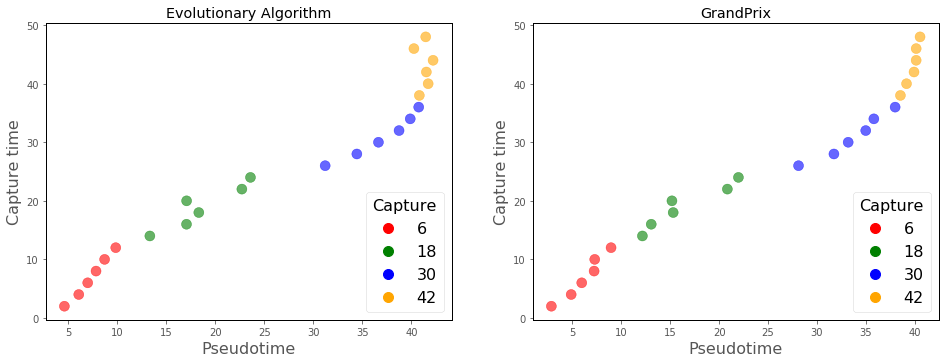

In [49]:
from matplotlib import pyplot as plt
# from utils import plot
actual_capture_time = mData['capture.orig'].values
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 12))
plt.subplot(2, 2, 1)
plot('Evolutionary Algorithm', 'Pseudotime', 'Capture time', best, actual_capture_time, mData['capture'].values)
plt.subplot(2, 2, 2)
plot('GrandPrix', 'Pseudotime', 'Capture time', GrandPrixPseudotime, actual_capture_time, mData['capture'].values)
plt.show()

In [12]:
from scipy import stats
print(stats.spearmanr(best, GrandPrixPseudotime))

SpearmanrResult(correlation=0.9913043478260868, pvalue=7.113899561244949e-21)


In [19]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import  numpy as np
import  pandas as pd
from collections import OrderedDict
from cycler import cycler
import warnings
warnings.filterwarnings('ignore')

matplotlib.style.use('ggplot')
matplotlib.rcParams['axes.facecolor'] = 'white'
matplotlib.rcParams['axes.edgecolor'] = 'black'
# plt.rc('axes', color_cycle=['royalblue', 'orange', 'green', 'red', 'blueviolet', 'sienna', 'hotpink', 'gray', 'y', 'c'])
# plt.rc('axes', color_cycle=['royalblue', 'green', 'sienna', 'c', 'orange', 'red', 'blueviolet', 'hotpink', 'gray', 'y'])
plt.rc('axes', prop_cycle=cycler(color=['royalblue', 'green', 'sienna', 'c', 'orange', 'red', 'blueviolet', 'hotpink', 'gray', 'y']))
# axes.prop_cycle : cycler('color', ['b', 'g', 'r', 'c', 'm', 'y', 'k'])


def plot(title, xLabel, yLabel, xData, yData, cpt, xErr=None, **kwargs):
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'black'
    # plt.figure(figsize=(8, 6))
    plt.title( '%s' % ( title ) )
    plt.xlabel('%s' % (xLabel), fontsize=16)
    plt.ylabel('%s' % (yLabel), fontsize=16)

    cellCapture = OrderedDict((('6', 'red'), ('18', 'green'), ('30', 'blue'), ('42', 'orange')))
    color_map = [0 for i in range(len(cpt))]

    for i in range(0, len(cpt)):
        if cpt[i] == 6:
            color_map[i] = 'red'
        elif cpt[i] == 18:
            color_map[i] = 'green'
        elif cpt[i] == 30:
            color_map[i] = 'blue'
        else:
            color_map[i] = 'orange'

    if 'datset' in kwargs:
        cellCapture = OrderedDict((('0', 'red'), ('2', 'green'), ('4', 'blue'), ('7', 'orange')))
        for i in range(0, len(cpt)):
            if cpt[i] == 1:
                color_map[i] = 'red'
            elif cpt[i] == 2:
                color_map[i] = 'green'
            elif cpt[i] == 3:
                color_map[i] = 'blue'
            else:
                color_map[i] = 'orange'

    # print(cellCapture)
    markers = [plt.Line2D([0, 0], [0, 0], color=color, marker='o', ms=10, linestyle='') for color in cellCapture.values()]

    plt.scatter(xData, yData, 100, c=color_map, alpha=0.6)
    if xErr is not None:
        plt.errorbar(xData, yData, xerr=xErr, fmt='none', marker='none', ecolor=color_map)

    # l = plt.legend(markers, cellCapture.keys(), numpoints=1, title='Capture', bbox_to_anchor=(1.1, 0.5), loc=10, fontsize=16)
    l = plt.legend(markers, cellCapture.keys(), numpoints=1, title='Capture', loc=4, fontsize=16)
    plt.setp(l.get_title(), fontsize=16)
    # plt.show()